In [1]:
setwd("D:/BABI/BABI-18th Residency/Assignment/Assignment_Work")
getwd()

[1] "D:/BABI/BABI-18th Residency/Assignment/Assignment_Work"

In [3]:
library(readxl)
library(writexl)
library(dplyr)
library(readr)
library(kableExtra)
library(ggplot2)
library(naniar)
library(visdat)
library(corrplot)
library(StatMeasures)
library(crayon)
library(gridExtra)
library(DataExplorer)
library(lattice)
library(mlr)
library(explore)
library(lmtest)
library(DMwR)
library(pROC)
library(e1071)
library(caret)

Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following object is masked from 'package:StatMeasures':

    auc

The following objects are masked from 'package:stats':

    cov, smooth, var

Warning message:
"package 'e1071' was built under R version 3.6.3"
Attaching package: 'e1071'

The following object is masked from 'package:mlr':

    impute

Warning message:
"package 'caret' was built under R version 3.6.3"
Attaching package: 'caret'

The following object is masked from 'package:survival':

    cluster

The following object is masked from 'package:mlr':

    train



In [4]:
# reading the raw data #

company <- read_excel("raw-data.xlsx", sheet = "raw data")

In [5]:
# reading the validation data #

validation <- read_excel("validation_data.xlsx", sheet = "valdata")

In [7]:
# creation of a new variable "Default" #

company$Default <- ifelse(company$`Networth Next Year`>0,0,1)
str(company$Default)
company$Default <- as.factor(company$Default)

 num [1:3541] 0 0 0 0 0 0 0 0 0 1 ...


In [8]:
# renaming the "Default-1" column in validation dataset and then converting the datatype of the same #

validation = validation%>% rename(Default = "Default - 1")
str(validation$Default)
validation$Default <- as.factor(validation$Default)

 num [1:715] 0 0 1 0 0 0 0 0 0 0 ...


In [9]:
# Removing the "Deposits column" in company and validation dataset #

company <- company[,-22]
validation <- validation[,-22]

In [10]:
######### Datatype conversion ##########

# company dataset #

company$`PE on BSE` <- as.numeric(company$`PE on BSE`)
company$`Creditors turnover` <- as.numeric(company$`Creditors turnover`)
company$`Debtors turnover` <- as.numeric(company$`Debtors turnover`)
company$`Finished goods turnover` <- as.numeric(company$`Finished goods turnover`)
company$`WIP turnover` <- as.numeric(company$`WIP turnover`)
company$`Raw material turnover` <- as.numeric(company$`Raw material turnover`)
company$`Shares outstanding` <- as.numeric(company$`Shares outstanding`)
company$`Equity face value` <- as.numeric(company$`Equity face value`)

# validation dataset #

validation$`Creditors turnover` <- as.numeric(validation$`Creditors turnover`)
validation$`Debtors turnover` <- as.numeric(validation$`Debtors turnover`)
validation$`Finished goods turnover` <- as.numeric(validation$`Finished goods turnover`)
validation$`WIP turnover` <- as.numeric(validation$`WIP turnover`)
validation$`Raw material turnover` <- as.numeric(validation$`Raw material turnover`)
validation$`Shares outstanding` <- as.numeric(validation$`Shares outstanding`)
validation$`Equity face value` <- as.numeric(validation$`Equity face value`)
validation$`PE on BSE` <- as.numeric(validation$`PE on BSE`)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, e

In [11]:
#################### missing value treatment #########################
 
# percentage of missing values in each column #

contains_any_na <- sapply(company, function(x) {
  count<-as.integer(sum(is.na(x)),length=0)
  percentage<-round(count/NROW(x),4)*100
  datatype<-class(x)
  frame<-c(datatype,count,percentage)
}
)

missing_frame <- t(contains_any_na)
dim(missing_frame)
colnames(missing_frame) <- c("datatype","missing records count", "percentage")
print(missing_frame)
write.csv(missing_frame,"missing_cols.csv")

# since "Networth Next Year" has been encoded as "Default", we can remove that column #

company1 <- subset(company, select = -c(1,2,19,24,31,33,51))
dim(company1)
names(company1)
summary(company1)

validation1 <- subset(validation, select = -c(1,19,24,31,33,51))
dim(validation1)
names(validation1)
summary(validation1)

# outlier function #

outlierpercentage <- function(dt, var) {
  var_name <- eval(substitute(var),eval(dt))
  tot <- sum(!is.na(var_name))
  na1 <- sum(is.na(var_name))
  mean1 <- mean(var_name, na.rm = T)
  outlier <- boxplot.stats(var_name)$out
  mo <- mean(outlier)
  var_name <- ifelse(var_name %in% outlier, NA, var_name)
  na2 <- sum(is.na(var_name))
  cat(paste("Outliers identified: ",(na2 - na1), " from ", tot, " observations \n"))
  cat(paste("Proportion (%) of outliers: ", round((na2 - na1) / tot*100,3),"\n"))
  cat(paste("Number of NA's: ",na1,"\n"))
  cat(paste("NA percentage is:", round(na1/(tot+na1)*100,3),"\n"))
  cat(paste("Mean of the outliers: ", mo,"\n"))
  mean2 <- mean(var_name, na.rm = T)
  cat(paste("Mean without removing outliers: ", round(mean1,3),"\n"))
  cat(paste("Mean if we remove outliers: ", round(mean2,3),"\n"))
  
}

# replace median function #

replace_median<-function(df,colname){
  colname <- eval(substitute(colname),eval(df))
  colname <- ifelse(is.na(colname),median(colname, na.rm = TRUE),colname)
  return (colname)
}

# treat outliers #

treat_outliers<-function(df,colname){
  colname <- eval(substitute(colname),eval(df))
  colname<-ifelse(colname>=quantile(colname,0.99),quantile(colname,0.99),colname)
  colname<-ifelse(colname<=quantile(colname,0.01),quantile(colname,0.01),colname)
  return (colname)
}

# graphs #

graphs<-function(df,colname,dependent,xlabel){ 
  colname <- eval(substitute(colname),eval(df))
  
     if(dependent==TRUE){
    ggplot(company1,aes(x=Default ,y=(colname))) +
      geom_boxplot(fill="orange",outlier.colour="black", outlier.shape=16,
                   outlier.size=2, notch=FALSE)+
      labs(title = paste("Credit risk and ", xlabel),
           x="Default", y= xlabel)+
      theme(panel.background = element_rect(fill = 'light yellow'),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            plot.title = element_text(hjust = 0.5))
  }
}

#histogram (uni-variate) graphs

histogram <- function(df, colname, his, xlabel){
  colname <- eval(substitute(colname), eval(df))
  
  if(his==T){
    hist((colname), xlab = xlabel, col = "green", 
         main = paste("Histogram for ",xlabel),breaks = 10)
  }
}


[1] 52  3

                                            datatype  missing records count
Num                                         "numeric" "0"                  
Networth Next Year                          "numeric" "0"                  
Total assets                                "numeric" "0"                  
Net worth                                   "numeric" "0"                  
Total income                                "numeric" "198"                
Change in stock                             "numeric" "458"                
Total expenses                              "numeric" "139"                
Profit after tax                            "numeric" "131"                
PBDITA                                      "numeric" "131"                
PBT                                         "numeric" "131"                
Cash profit                                 "numeric" "131"                
PBDITA as % of total income                 "numeric" "68"                 
PBT as % of 

[1] 3541   45

[1] "Total assets"                               
 [2] "Net worth"                                  
 [3] "Total income"                               
 [4] "Change in stock"                            
 [5] "Total expenses"                             
 [6] "Profit after tax"                           
 [7] "PBDITA"                                     
 [8] "PBT"                                        
 [9] "Cash profit"                                
[10] "PBDITA as % of total income"                
[11] "PBT as % of total income"                   
[12] "PAT as % of total income"                   
[13] "Cash profit as % of total income"           
[14] "PAT as % of net worth"                      
[15] "Sales"                                      
[16] "Income from financial services"             
[17] "Total capital"                              
[18] "Reserves and funds"                         
[19] "Borrowings"                                 
[20] "Current liabilities & provisions"           
[21] "Shareholders funds"                         
[22] "Cumulative retained profits"                
[23] "Capital employed"                           
[24] "TOL/TNW"                                    
[25] "Total term liabilities / tangible net worth"
[26] "Contingent liabilities / Net worth (%)"     
[27] "Net fixed assets"                           
[28] "Current assets"                             
[29] "Net working capital"                        
[30] "Quick ratio (times)"                        
[31] "Current ratio (times)"                      
[32] "Debt to equity ratio (times)"               
[33] "Cash to current liabilities (times)"        
[34] "Cash to average cost of sales per day"      
[35] "Creditors turnover"                         
[36] "Debtors turnover"                           
[37] "Finished goods turnover"                    
[38] "WIP turnover"                               
[39] "Raw material turnover"                      
[40] "Shares outstanding"                         
[41] "Equity face value"                          
[42] "EPS"                                        
[43] "Adjusted EPS"                               
[44] "Total liabilities"                          
[45] "Default"

  Total assets         Net worth         Total income       Change in stock   
 Min.   :      0.1   Min.   :     0.0   Min.   :      0.0   Min.   :-3029.40  
 1st Qu.:     91.3   1st Qu.:    31.3   1st Qu.:    106.5   1st Qu.:   -1.80  
 Median :    309.7   Median :   102.3   Median :    444.9   Median :    1.60  
 Mean   :   3443.4   Mean   :  1295.9   Mean   :   4582.8   Mean   :   41.49  
 3rd Qu.:   1098.7   3rd Qu.:   377.3   3rd Qu.:   1440.9   3rd Qu.:   18.05  
 Max.   :1176509.2   Max.   :613151.6   Max.   :2442828.2   Max.   :14185.50  
                                        NA's   :198         NA's   :458       
 Total expenses      Profit after tax        PBDITA              PBT           
 Min.   :     -0.1   Min.   : -3908.30   Min.   :  -440.7   Min.   : -3894.80  
 1st Qu.:     95.8   1st Qu.:     0.50   1st Qu.:     6.9   1st Qu.:     0.70  
 Median :    407.7   Median :     8.80   Median :    35.4   Median :    12.40  
 Mean   :   4262.9   Mean   :   277.36   Mean   

[1] 715  45

[1] "Default"                                    
 [2] "Total assets"                               
 [3] "Net worth"                                  
 [4] "Total income"                               
 [5] "Change in stock"                            
 [6] "Total expenses"                             
 [7] "Profit after tax"                           
 [8] "PBDITA"                                     
 [9] "PBT"                                        
[10] "Cash profit"                                
[11] "PBDITA as % of total income"                
[12] "PBT as % of total income"                   
[13] "PAT as % of total income"                   
[14] "Cash profit as % of total income"           
[15] "PAT as % of net worth"                      
[16] "Sales"                                      
[17] "Income from financial services"             
[18] "Total capital"                              
[19] "Reserves and funds"                         
[20] "Borrowings"                                 
[21] "Current liabilities & provisions"           
[22] "Shareholders funds"                         
[23] "Cumulative retained profits"                
[24] "Capital employed"                           
[25] "TOL/TNW"                                    
[26] "Total term liabilities / tangible net worth"
[27] "Contingent liabilities / Net worth (%)"     
[28] "Net fixed assets"                           
[29] "Current assets"                             
[30] "Net working capital"                        
[31] "Quick ratio (times)"                        
[32] "Current ratio (times)"                      
[33] "Debt to equity ratio (times)"               
[34] "Cash to current liabilities (times)"        
[35] "Cash to average cost of sales per day"      
[36] "Creditors turnover"                         
[37] "Debtors turnover"                           
[38] "Finished goods turnover"                    
[39] "WIP turnover"                               
[40] "Raw material turnover"                      
[41] "Shares outstanding"                         
[42] "Equity face value"                          
[43] "EPS"                                        
[44] "Adjusted EPS"                               
[45] "Total liabilities"

 Default  Total assets        Net worth         Total income      
 0:661   Min.   :     0.1   Min.   :     0.1   Min.   :      0.0  
 1: 54   1st Qu.:    93.2   1st Qu.:    34.4   1st Qu.:    110.8  
         Median :   347.7   Median :   120.9   Median :    536.0  
         Mean   :  4218.6   Mean   :  1629.7   Mean   :   5204.7  
         3rd Qu.:  1315.3   3rd Qu.:   451.5   3rd Qu.:   1727.1  
         Max.   :354727.3   Max.   :171840.0   Max.   :1028087.4  
                                               NA's   :33         
 Change in stock   Total expenses      Profit after tax       PBDITA         
 Min.   :-488.10   Min.   :      0.0   Min.   : -998.00   Min.   :  -393.90  
 1st Qu.:  -1.90   1st Qu.:    104.1   1st Qu.:    0.68   1st Qu.:     7.15  
 Median :   1.80   Median :    511.1   Median :   10.20   Median :    42.20  
 Mean   :  54.66   Mean   :   4817.3   Mean   :  382.22   Mean   :   743.35  
 3rd Qu.:  19.35   3rd Qu.:   1642.3   3rd Qu.:   68.95   3rd Qu.:   192.8

The column is "total income"Outliers identified:  427  from  3343  observations 
Proportion (%) of outliers:  12.773 
Number of NA's:  198 
NA percentage is: 5.592 
Mean of the outliers:  31555.8964871194 
Mean without removing outliers:  4582.823 
Mean if we remove outliers:  633.063 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
      0.0     106.4     444.9    4582.8    1440.9 2442828.2       198 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.3   121.2   444.9  2040.7  1340.3 42282.8 

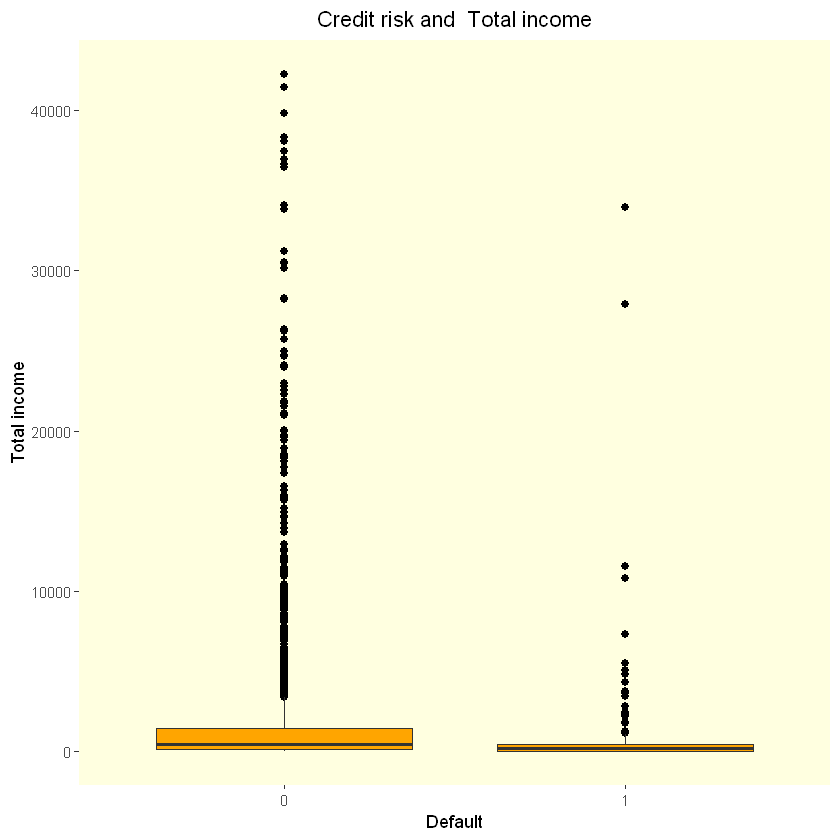

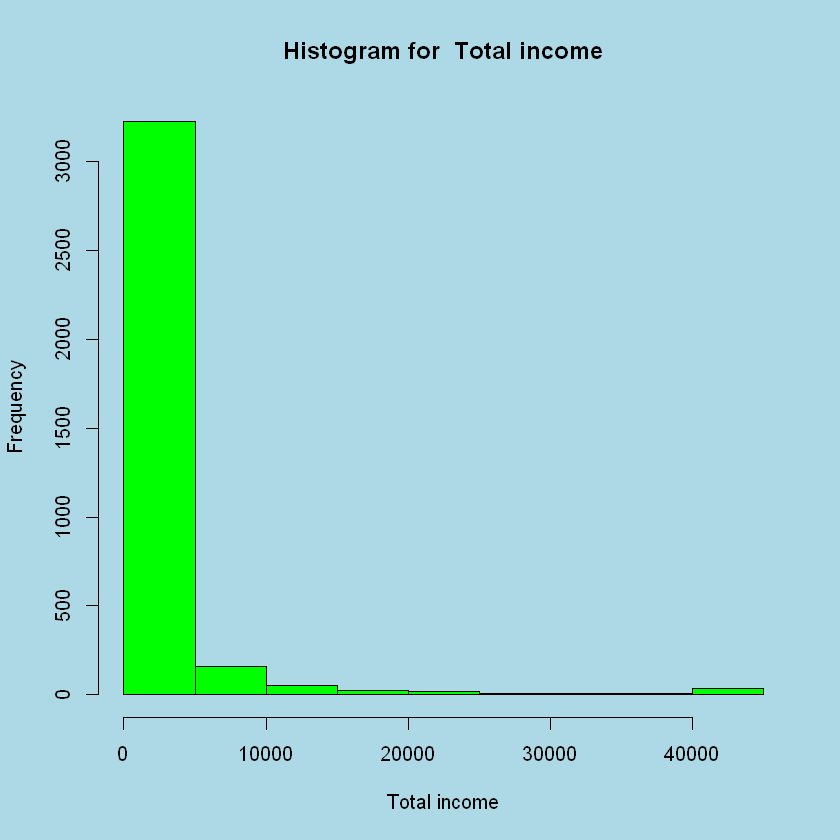

In [12]:
######### Treatment of each and every columns ###########

# company dataset #

# Total income #
par(bg="light blue")
cat(green$bold("The column is \"total income\""))
outlierpercentage(company1, `Total income`)
cat("summary before treatment")
summary(company1$`Total income`)
company1$`Total income`<-replace_median(company1,`Total income`)
company1$`Total income`<-treat_outliers(company1,`Total income`)
cat("summary after treatment")
summary(company1$`Total income`)
graphs(company1,`Total income`,TRUE,"Total income")
histogram(company1,`Total income`,TRUE,"Total income")

The column is "change in stock"Outliers identified:  621  from  3083  observations 
Proportion (%) of outliers:  20.143 
Number of NA's:  458 
NA percentage is: 12.934 
Mean of the outliers:  188.302737520129 
Mean without removing outliers:  41.489 
Mean if we remove outliers:  4.458 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-3029.40    -1.80     1.60    41.49    18.05 14185.50      458 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-234.66   -0.70    1.60   19.46   13.40  600.20 

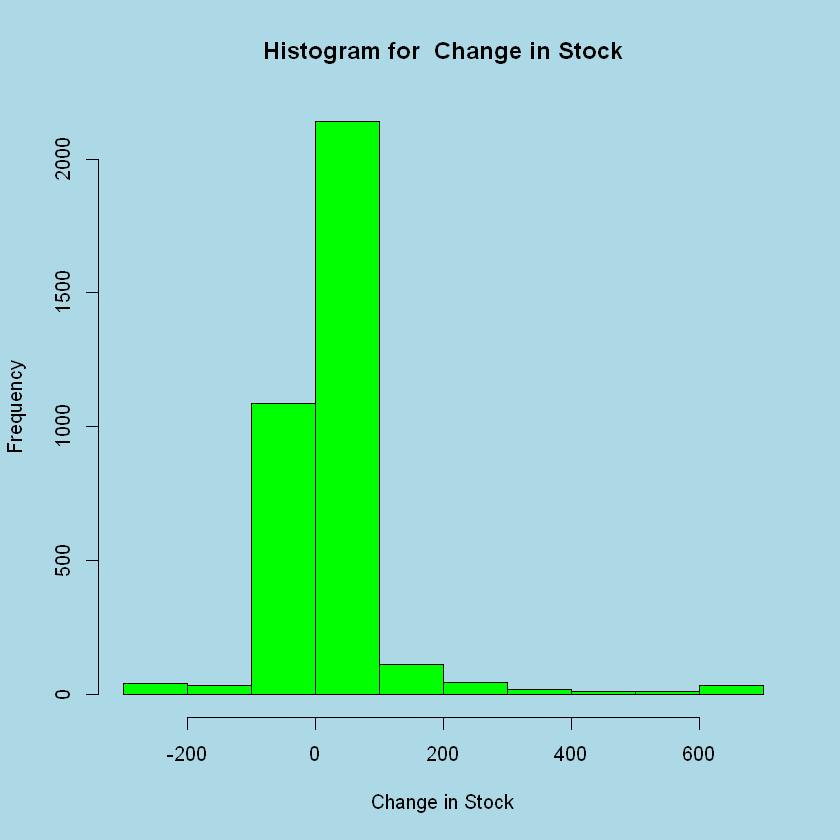

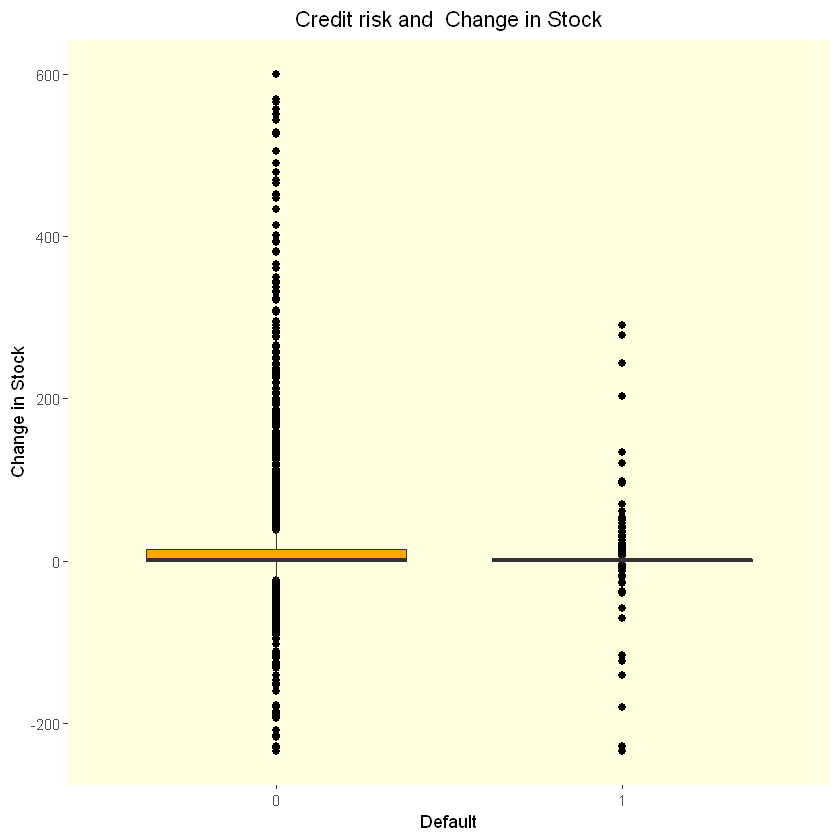

In [13]:
# Change in stock #
par(bg="light blue")
cat(green$bold("The column is \"change in stock\""))
outlierpercentage(company1, `Change in stock`)
cat("summary before treatment")
summary(company1$`Change in stock`)
company1$`Change in stock`<-replace_median(company1,`Change in stock`)
company1$`Change in stock`<-treat_outliers(company1,`Change in stock`)
cat("summary after treatment")
summary(company1$`Change in stock`)
histogram(company1,`Change in stock`,TRUE,"Change in Stock")
graphs(company1,`Change in stock`,TRUE,"Change in Stock")


The column is "income from financial services"Outliers identified:  429  from  2606  observations 
Proportion (%) of outliers:  16.462 
Number of NA's:  935 
NA percentage is: 26.405 
Mean of the outliers:  473.962703962704 
Mean without removing outliers:  80.844 
Mean if we remove outliers:  3.375 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
    0.00     0.40     1.80    80.84     9.67 51938.20      935 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.10    0.70    1.80   23.39    5.40  769.94 

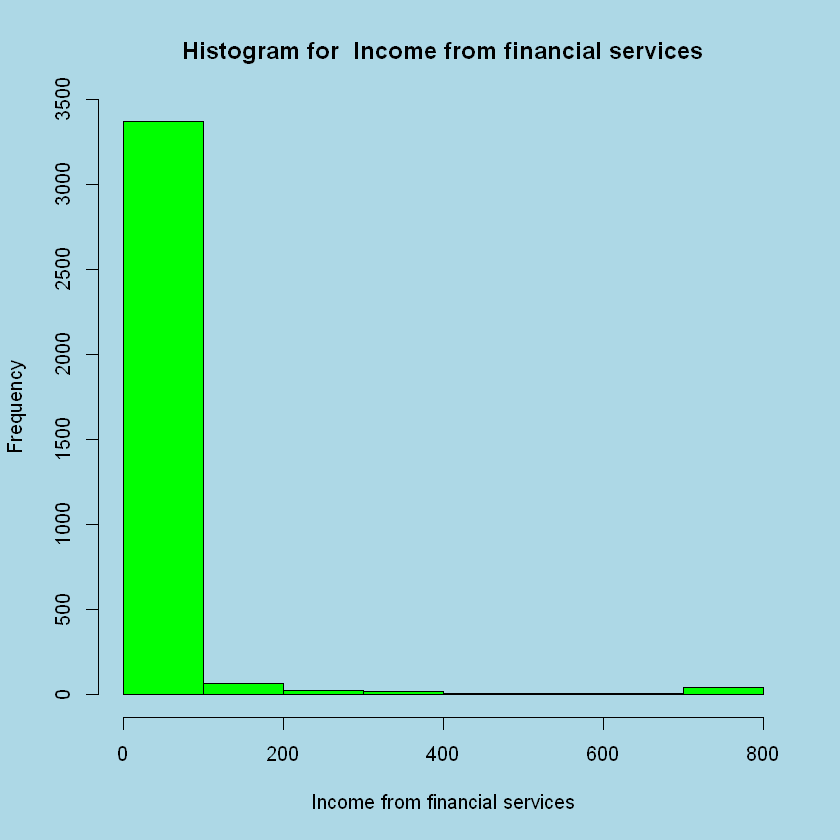

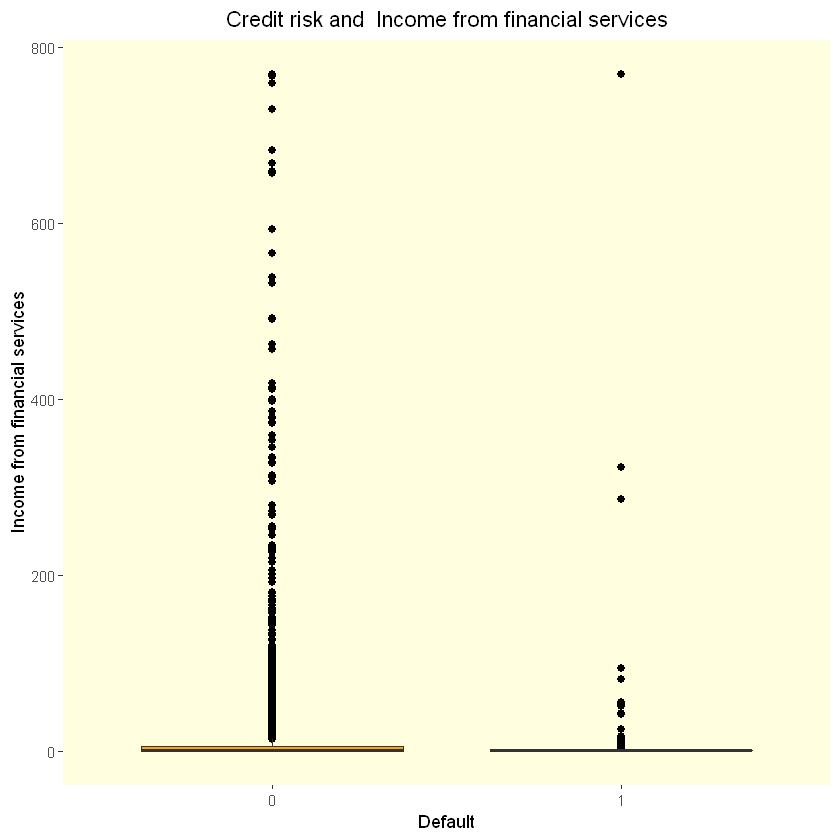

In [14]:
# Income from financial services #
par(bg="light blue")
cat(green$bold("The column is \"income from financial services\""))
outlierpercentage(company1, `Income from financial services`)
cat("summary before treatment")
summary(company1$`Income from financial services`)
company1$`Income from financial services`<-replace_median(company1,`Income from financial services`)
company1$`Income from financial services`<-treat_outliers(company1,`Income from financial services`)
cat("summary after treatment")
summary(company1$`Income from financial services`)
histogram(company1,`Income from financial services`,TRUE,"Income from financial services")
graphs(company1,`Income from financial services`,TRUE,"Income from financial services")

The column is "Finished goods turnover"Outliers identified:  326  from  2801  observations 
Proportion (%) of outliers:  11.639 
Number of NA's:  740 
NA percentage is: 20.898 
Mean of the outliers:  586.740920245399 
Mean without removing outliers:  87.079 
Mean if we remove outliers:  21.265 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
   -0.09     8.20    17.27    87.08    40.35 17947.60      740 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.894  10.210  17.270  46.369  30.720 857.220 

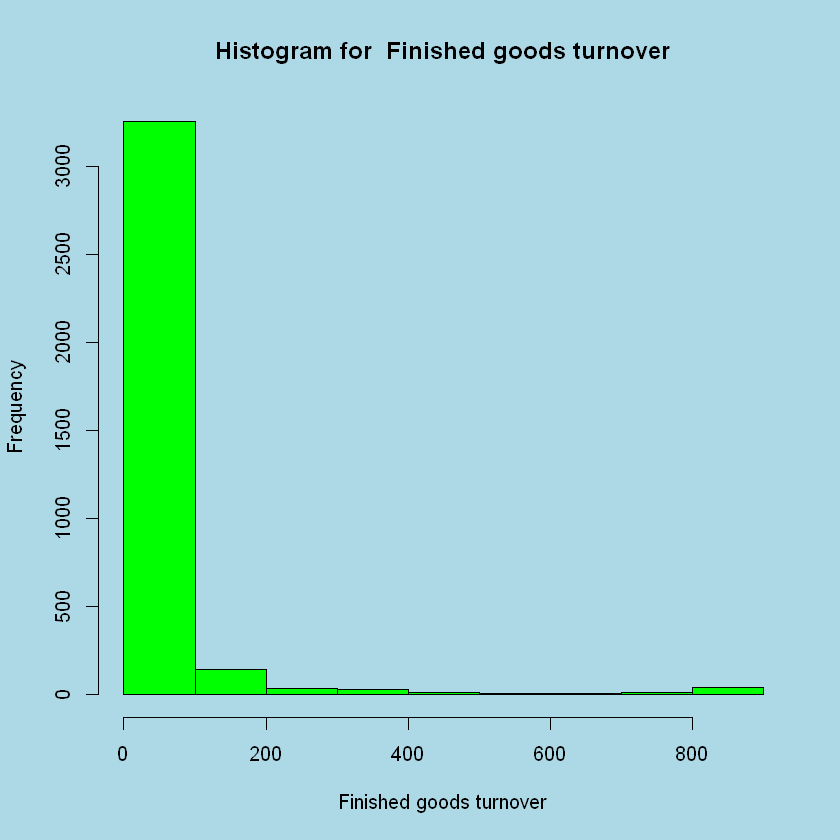

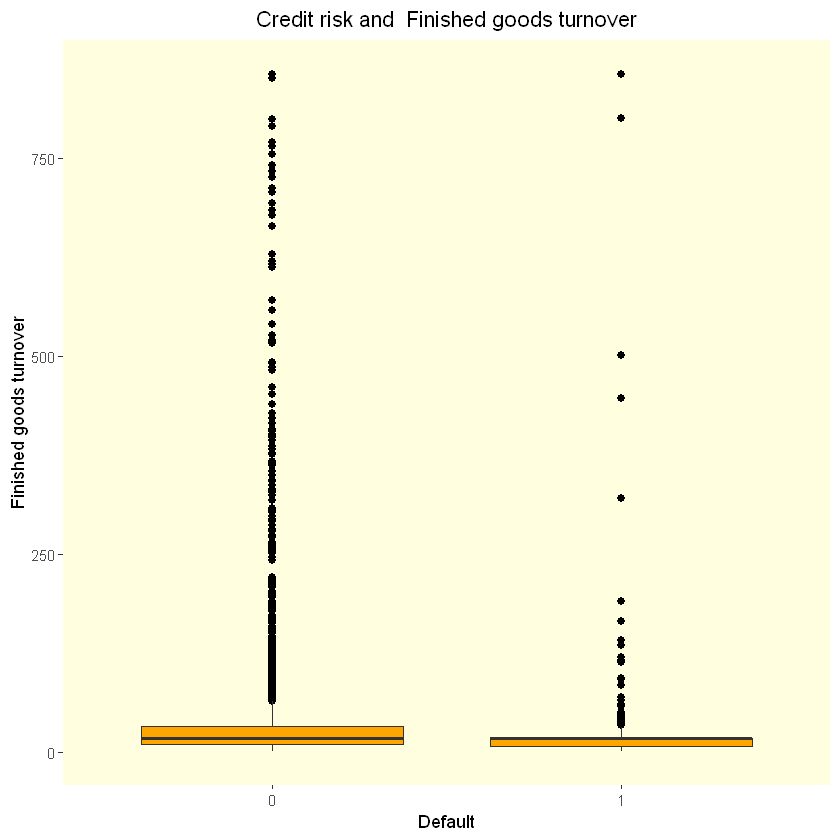

In [15]:
# Finished goods turnover #
par(bg="light blue")
cat(green$bold("The column is \"Finished goods turnover\""))
outlierpercentage(company1, `Finished goods turnover`)
cat("summary before treatment")
summary(company1$`Finished goods turnover`)
company1$`Finished goods turnover`<-replace_median(company1,`Finished goods turnover`)
company1$`Finished goods turnover`<-treat_outliers(company1,`Finished goods turnover`)
cat("summary after treatment")
summary(company1$`Finished goods turnover`)
histogram(company1,`Finished goods turnover`,TRUE,"Finished goods turnover")
graphs(company1,`Finished goods turnover`,TRUE,"Finished goods turnover")

The column is "Shares outstanding"Outliers identified:  393  from  2849  observations 
Proportion (%) of outliers:  13.794 
Number of NA's:  692 
NA percentage is: 19.543 
Mean of the outliers:  127870525.768448 
Mean without removing outliers:  22067387.536 
Mean if we remove outliers:  5137162.24 
summary before treatment

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max.       NA's 
-2.147e+09  1.316e+06  4.672e+06  2.207e+07  1.065e+07  4.130e+09        692 

summary after treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    16855   2209860   4672063  14433527   8320000 268509911 

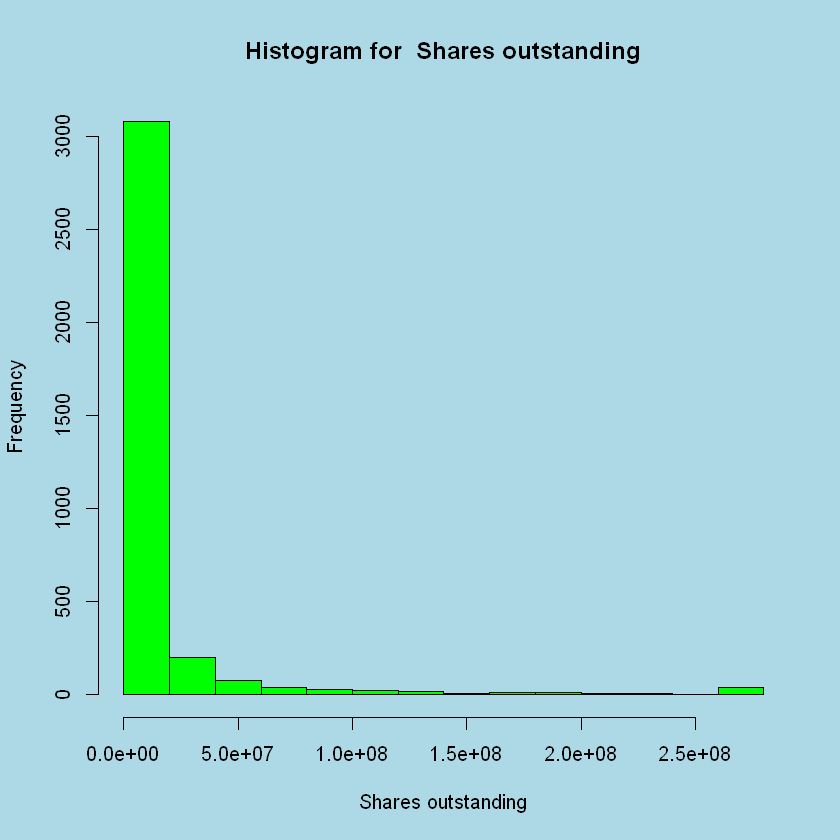

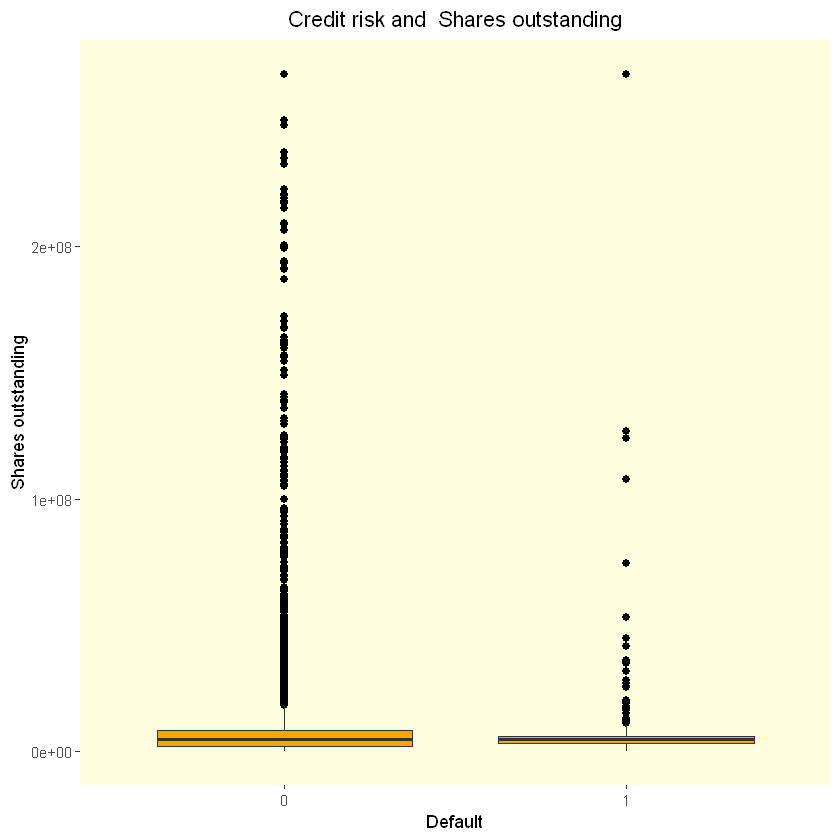

In [16]:
# Shares outstanding #
par(bg="light blue")
cat(green$bold("The column is \"Shares outstanding\""))
outlierpercentage(company1, `Shares outstanding`)
cat("summary before treatment")
summary(company1$`Shares outstanding`)
company1$`Shares outstanding`<-replace_median(company1,`Shares outstanding`)
company1$`Shares outstanding`<-treat_outliers(company1,`Shares outstanding`)
cat("summary after treatment")
summary(company1$`Shares outstanding`)
histogram(company1,`Shares outstanding`,TRUE,"Shares outstanding")
graphs(company1,`Shares outstanding`,TRUE,"Shares outstanding")

The column is "Total expenses"Outliers identified:  432  from  3402  observations 
Proportion (%) of outliers:  12.698 
Number of NA's:  139 
NA percentage is: 3.925 
Mean of the outliers:  29477.8097222222 
Mean without removing outliers:  4262.931 
Mean if we remove outliers:  595.312 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
     -0.1      95.8     407.7    4262.9    1359.8 2366035.3       139 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.2   104.1   407.7  1917.7  1284.6 38283.8 

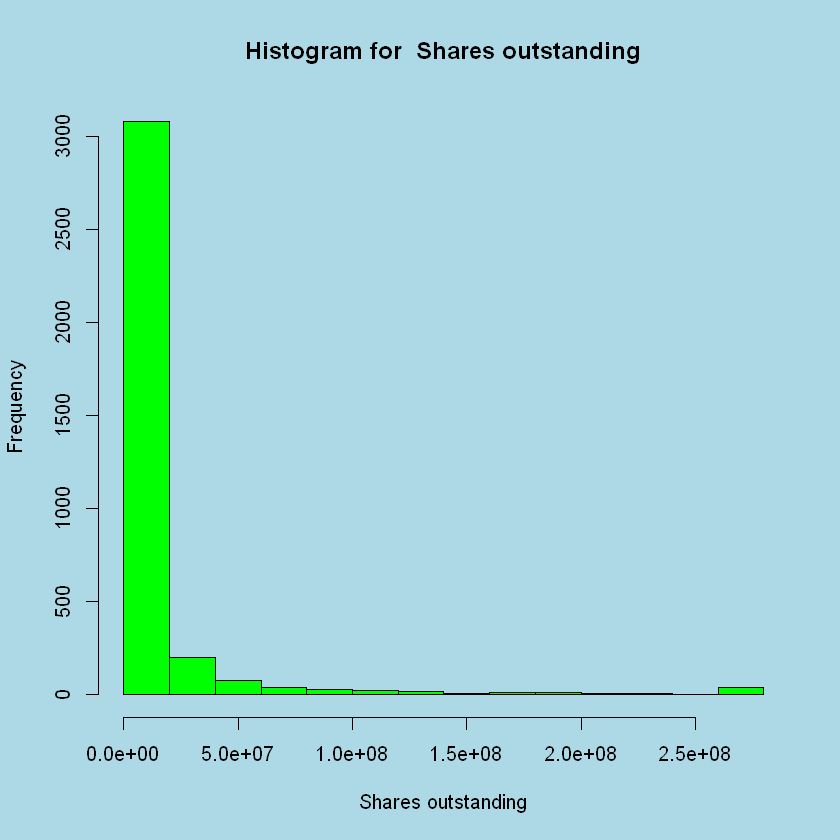

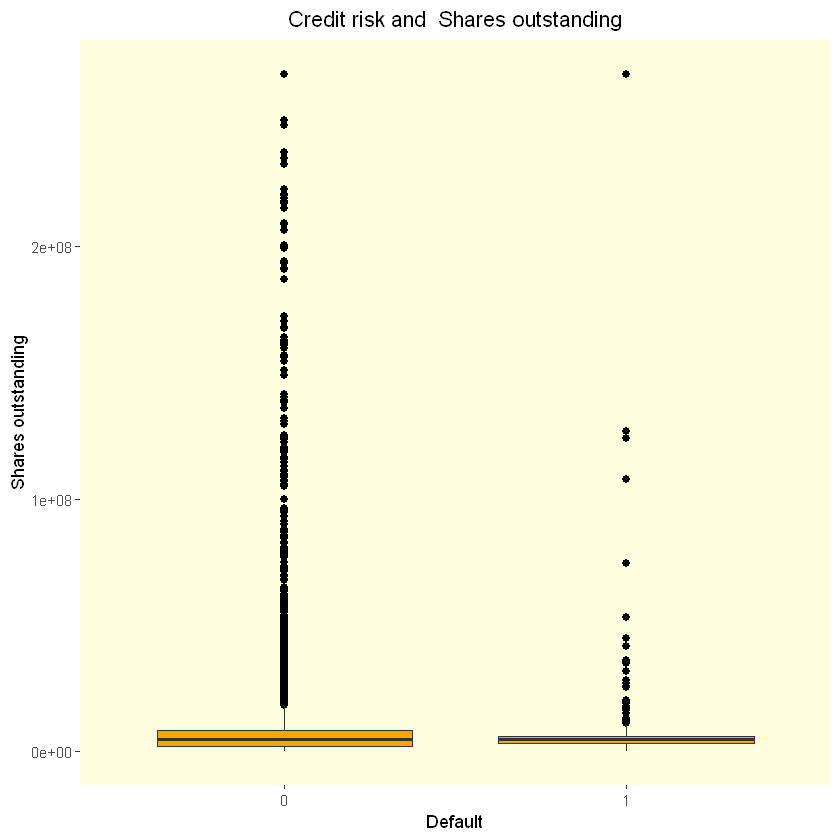

In [17]:
# Total expenses #
par(bg="light blue")
cat(green$bold("The column is \"Total expenses\""))
outlierpercentage(company1, `Total expenses`)
cat("summary before treatment")
summary(company1$`Total expenses`)
company1$`Total expenses`<-replace_median(company1,`Total expenses`)
company1$`Total expenses`<-treat_outliers(company1,`Total expenses`)
cat("summary after treatment")
summary(company1$`Total expenses`)
histogram(company1,`Shares outstanding`,TRUE,"Shares outstanding")
graphs(company1,`Shares outstanding`,TRUE,"Shares outstanding")

The column is "Profit after Tax"Outliers identified:  577  from  3410  observations 
Proportion (%) of outliers:  16.921 
Number of NA's:  131 
NA percentage is: 3.7 
Mean of the outliers:  1560.80103986135 
Mean without removing outliers:  277.36 
Mean if we remove outliers:  15.961 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
 -3908.30      0.50      8.80    277.36     52.27 119439.10       131 

summary after treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -3908.3      0.6      8.8    267.4     48.1 119439.1 

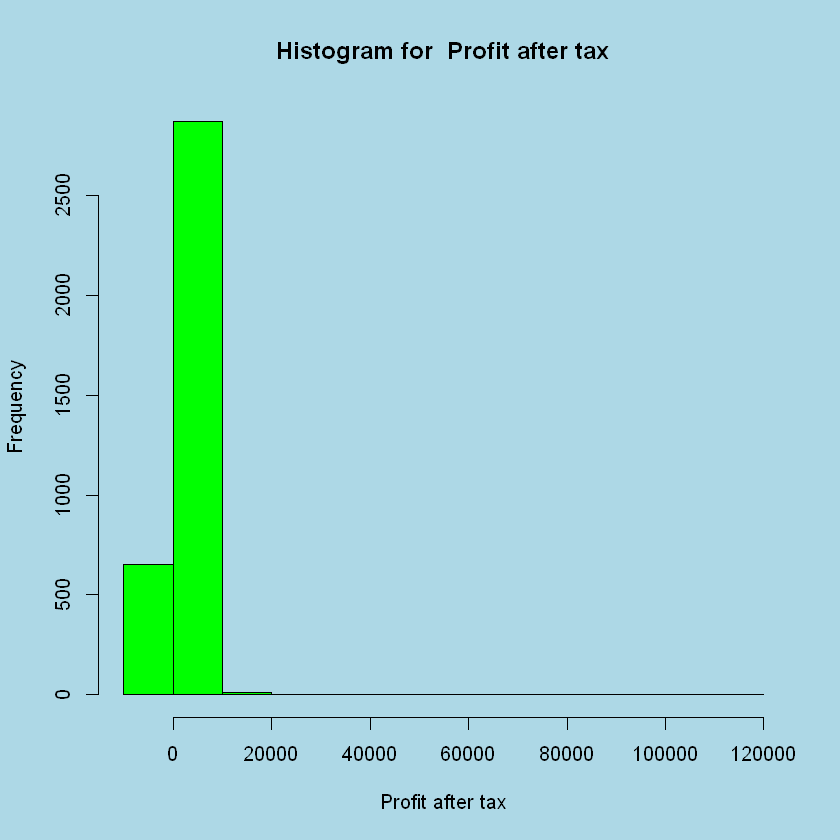

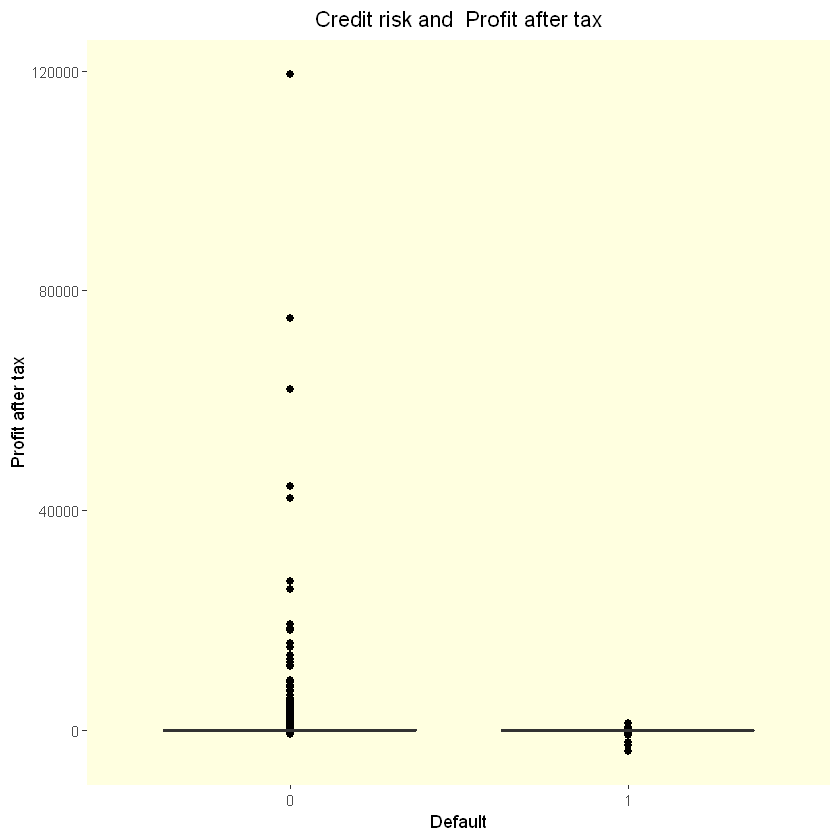

In [18]:
# Profit after tax #
par(bg="light blue")
cat(green$bold("The column is \"Profit after Tax\""))
outlierpercentage(company1, `Profit after tax`)
cat("summary before treatment")
summary(company1$`Profit after tax`)
company1$`Profit after tax`<-replace_median(company1,`Profit after tax`)
company1$Profit.after.tax<-treat_outliers(company1,`Profit after tax`)
cat("summary after treatment")
summary(company1$`Profit after tax`)
histogram(company1,`Profit after tax`,TRUE,"Profit after tax")
graphs(company1,`Profit after tax`,TRUE,"Profit after tax")

The column is "PBDITA"Outliers identified:  483  from  3410  observations 
Proportion (%) of outliers:  14.164 
Number of NA's:  131 
NA percentage is: 3.7 
Mean of the outliers:  3731.19109730849 
Mean without removing outliers:  578.056 
Mean if we remove outliers:  57.741 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
  -440.7      6.9     35.4    578.1    150.2 208576.5      131 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -22.22    7.30   35.40  285.37  139.10 7370.08 

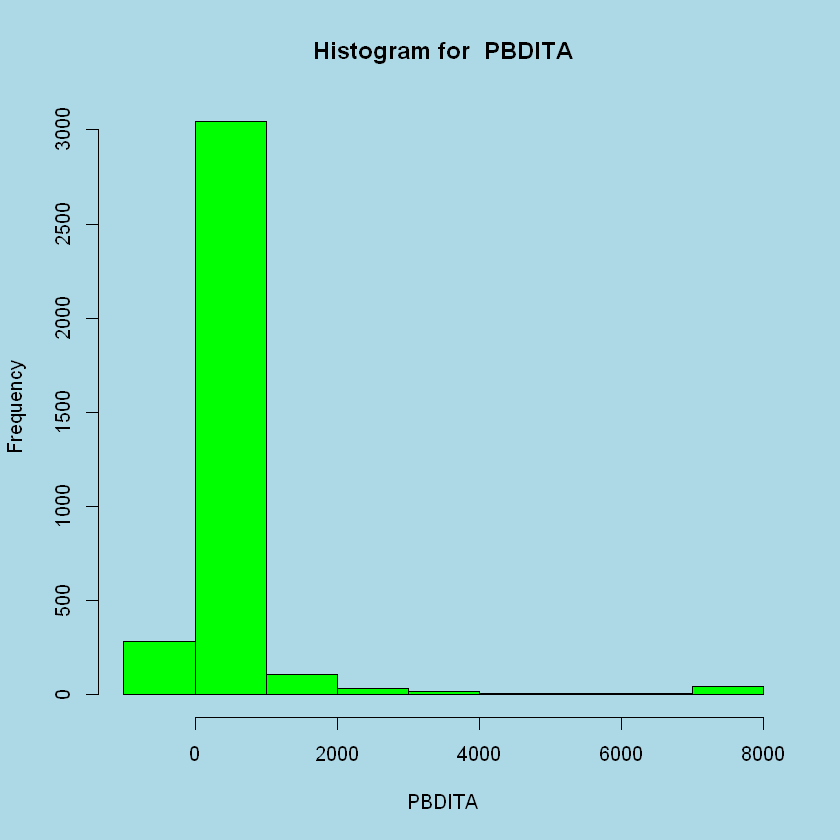

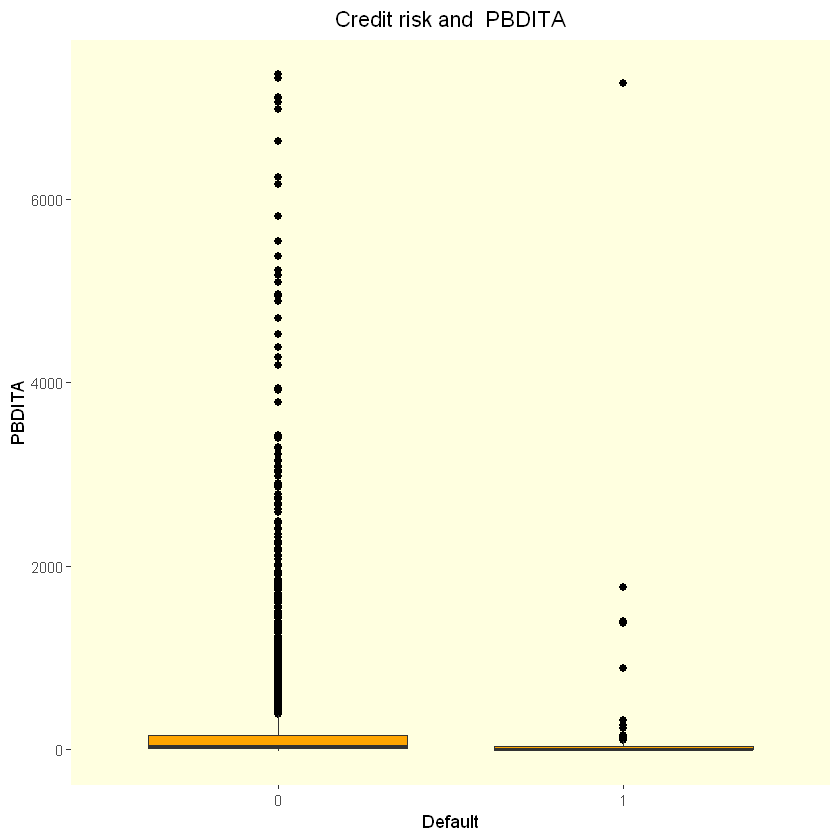

In [19]:
# PBDITA #
par(bg="light blue")
cat(green$bold("The column is \"PBDITA\""))
outlierpercentage(company1, PBDITA)
cat("summary before treatment")
summary(company1$PBDITA)
company1$PBDITA<-replace_median(company1,PBDITA)
company1$PBDITA<-treat_outliers(company1,PBDITA)
cat("summary after treatment")
summary(company1$PBDITA)
histogram(company1,PBDITA,TRUE,"PBDITA")
graphs(company1,PBDITA,TRUE,"PBDITA")

The column is "PBT"Outliers identified:  576  from  3410  observations 
Proportion (%) of outliers:  16.891 
Number of NA's:  131 
NA percentage is: 3.7 
Mean of the outliers:  2163.603125 
Mean without removing outliers:  383.81 
Mean if we remove outliers:  22.074 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
 -3894.80      0.70     12.40    383.81     71.97 145292.60       131 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -191.7     0.9    12.4   172.3    67.5  5421.4 

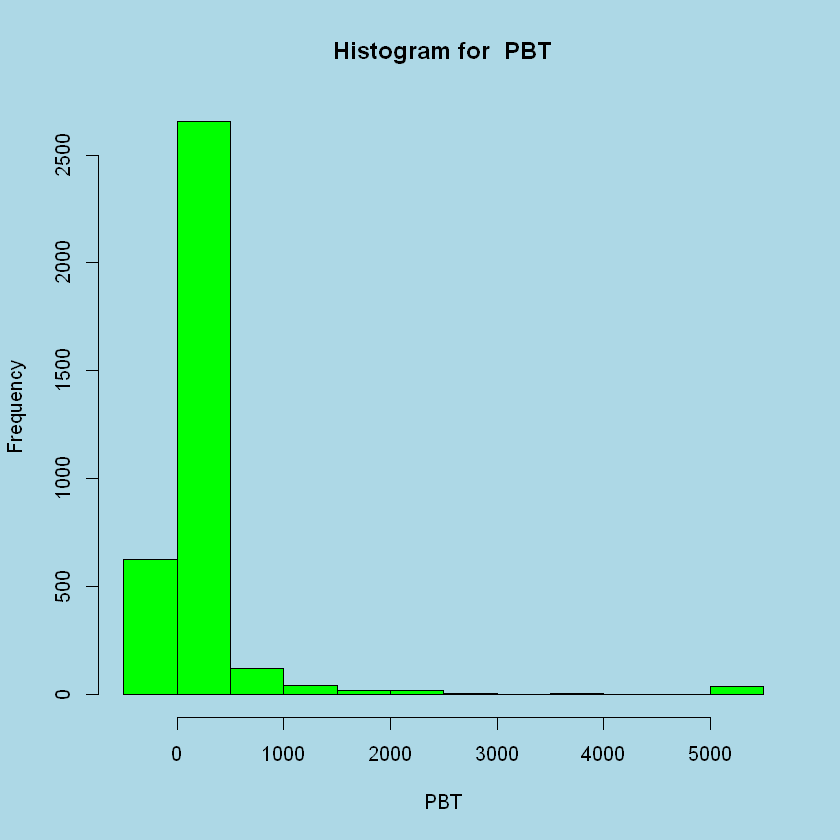

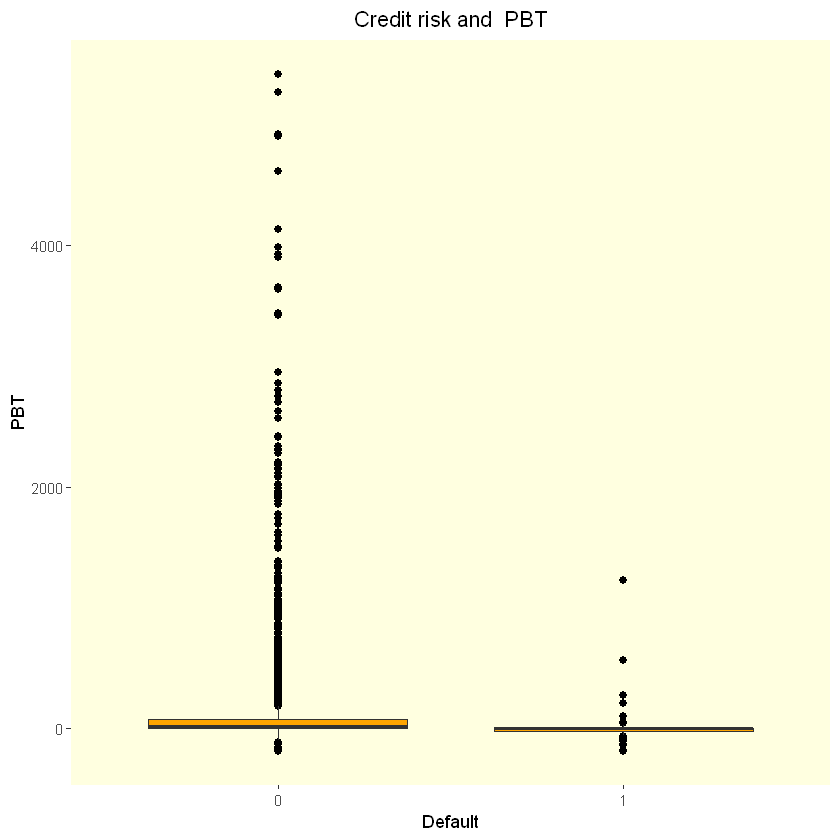

In [20]:
# PBT #
par(bg="light blue")
cat(green$bold("The column is \"PBT\""))
outlierpercentage(company1, PBT)
cat("summary before treatment")
summary(company1$PBT)
company1$PBT<-replace_median(company1,PBT)
company1$PBT<-treat_outliers(company1,PBT)
cat("summary after treatment")
summary(company1$PBT)
histogram(company1,PBT,TRUE,"PBT")
graphs(company1,PBT,TRUE,"PBT")

The column is "Cash profit"Outliers identified:  515  from  3410  observations 
Proportion (%) of outliers:  15.103 
Number of NA's:  131 
NA percentage is: 3.7 
Mean of the outliers:  2410.89242718447 
Mean without removing outliers:  392.065 
Mean if we remove outliers:  32.93 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
 -2245.70      2.90     18.85    392.07     93.20 176911.80       131 

summary after treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 -2245.70      3.10     18.85    378.26     86.80 176911.80 

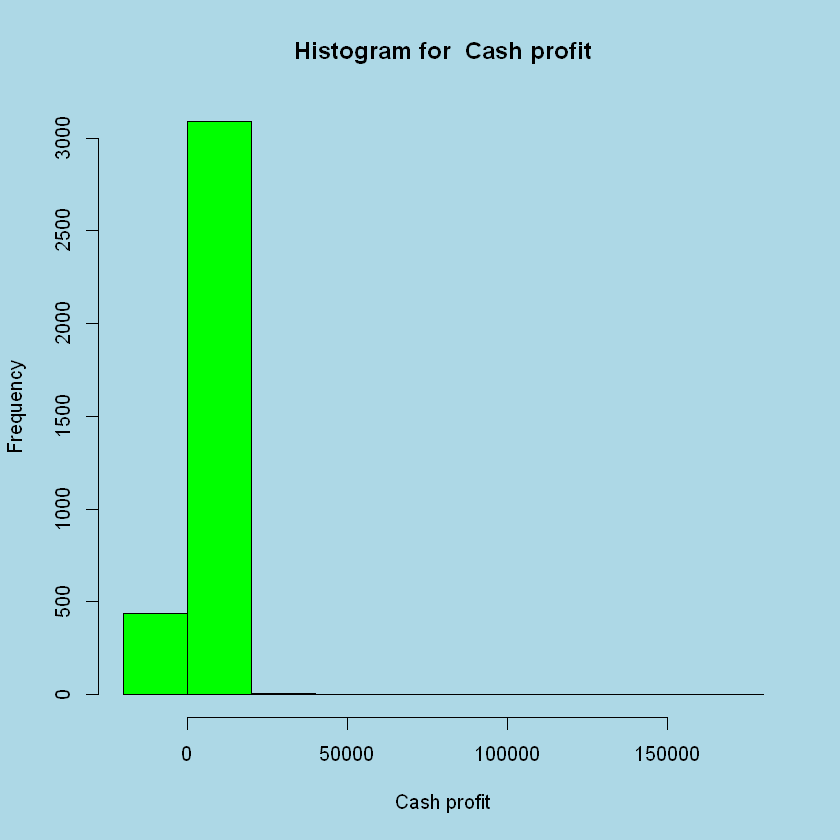

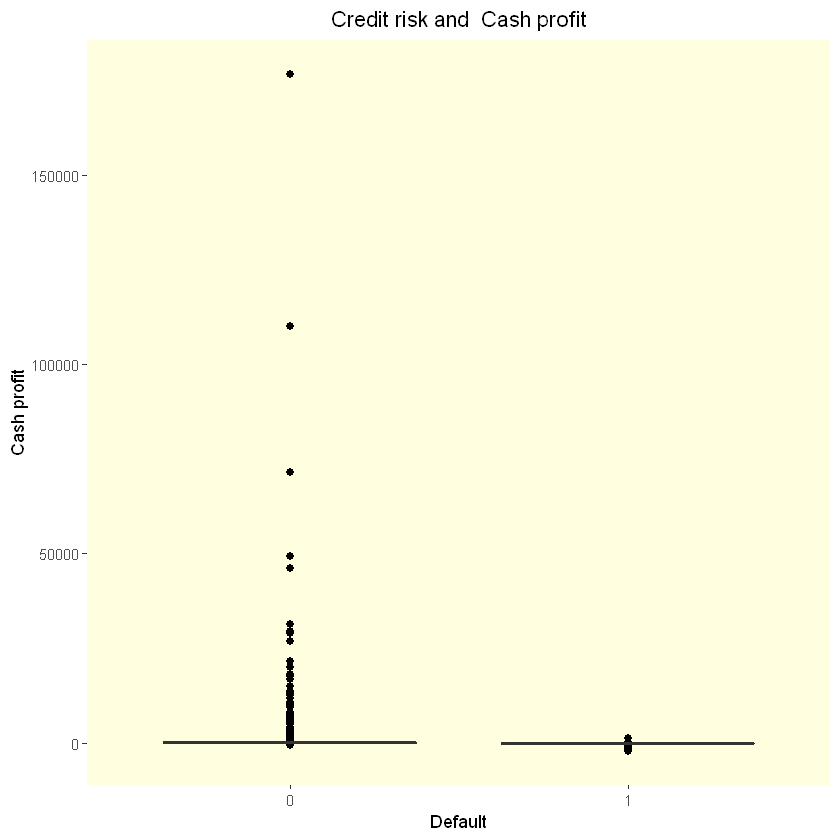

In [21]:
# Cash profit #
par(bg="light blue")
cat(green$bold("The column is \"Cash profit\""))
outlierpercentage(company1, `Cash profit`)
cat("summary before treatment")
summary(company1$`Cash profit`)
company1$`Cash profit`<-replace_median(company1,`Cash profit`)
company1$Cash.profit<-treat_outliers(company1,`Cash profit`)
cat("summary after treatment")
summary(company1$`Cash profit`)
histogram(company1,`Cash profit`,TRUE,"Cash profit")
graphs(company1,`Cash profit`,TRUE,"Cash profit")

The column is "PBDITA as % of total income"Outliers identified:  287  from  3473  observations 
Proportion (%) of outliers:  8.264 
Number of NA's:  68 
NA percentage is: 1.92 
Mean of the outliers:  -60.9889895470383 
Mean without removing outliers:  4.571 
Mean if we remove outliers:  10.476 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
-6400.000     5.000     9.660     4.571    16.390   100.000        68 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -62.72    5.07    9.66   11.25   16.15   80.81 

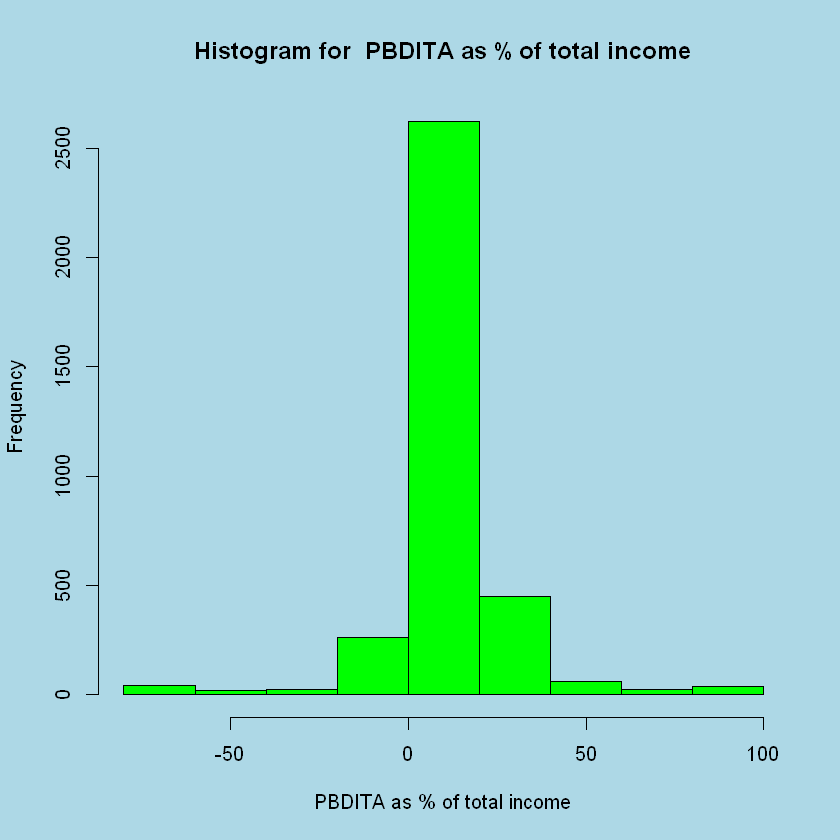

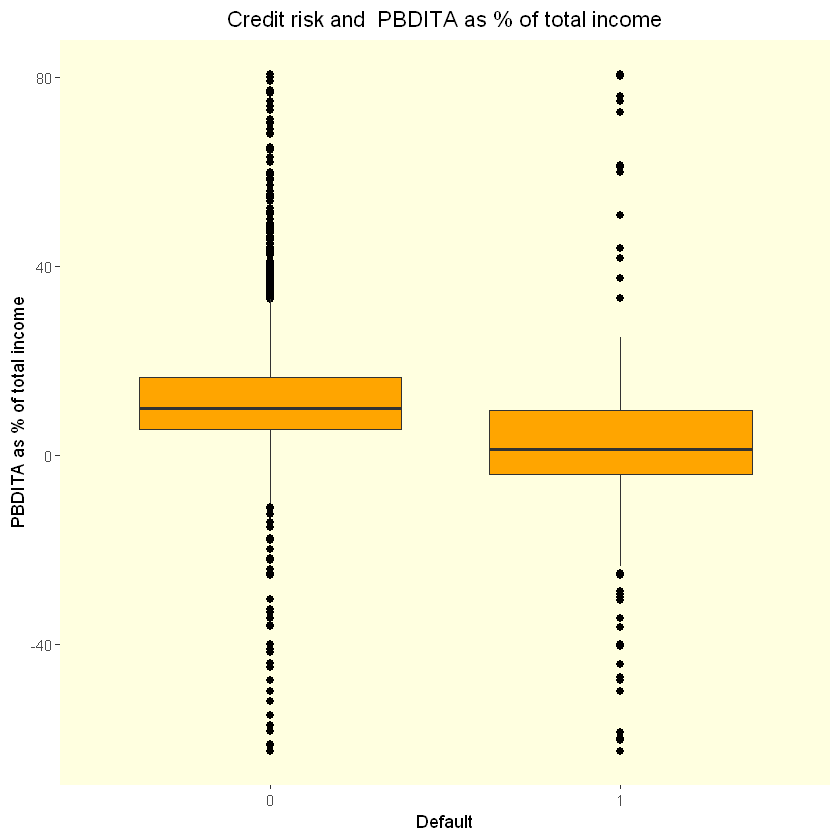

In [22]:
# PBDITA as % of total income #
par(bg="light blue")
cat(green$bold("The column is \"PBDITA as % of total income\""))
outlierpercentage(company1, `PBDITA as % of total income`)
cat("summary before treatment")
summary(company1$`PBDITA as % of total income`)
company1$`PBDITA as % of total income`<-replace_median(company1,`PBDITA as % of total income`)
company1$`PBDITA as % of total income`<-treat_outliers(company1,`PBDITA as % of total income`)
cat("summary after treatment")
summary(company1$`PBDITA as % of total income`)
histogram(company1,`PBDITA as % of total income`,TRUE,"PBDITA as % of total income")
graphs(company1,`PBDITA as % of total income`,TRUE,"PBDITA as % of total income")

The column is "Equity face value"Outliers identified:  436  from  2849  observations 
Proportion (%) of outliers:  15.304 
Number of NA's:  692 
NA percentage is: 19.543 
Mean of the outliers:  -8770.26628440367 
Mean without removing outliers:  -1333.698 
Mean if we remove outliers:  10 
summary before treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-999999      10      10   -1334      10  100000     692 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   10.00   10.00   17.95   10.00  190.00 

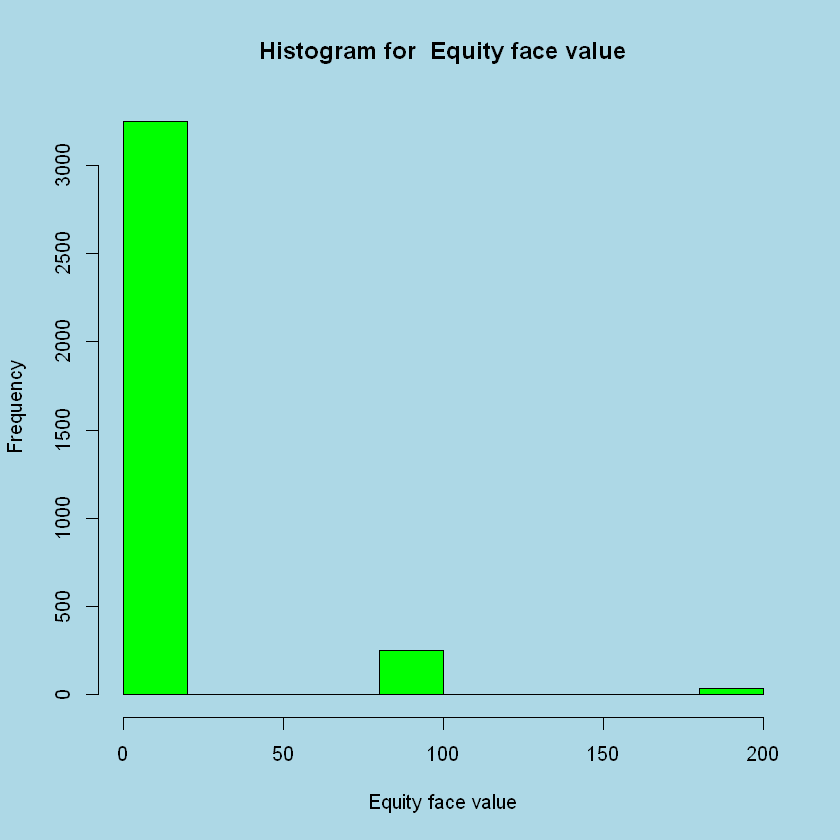

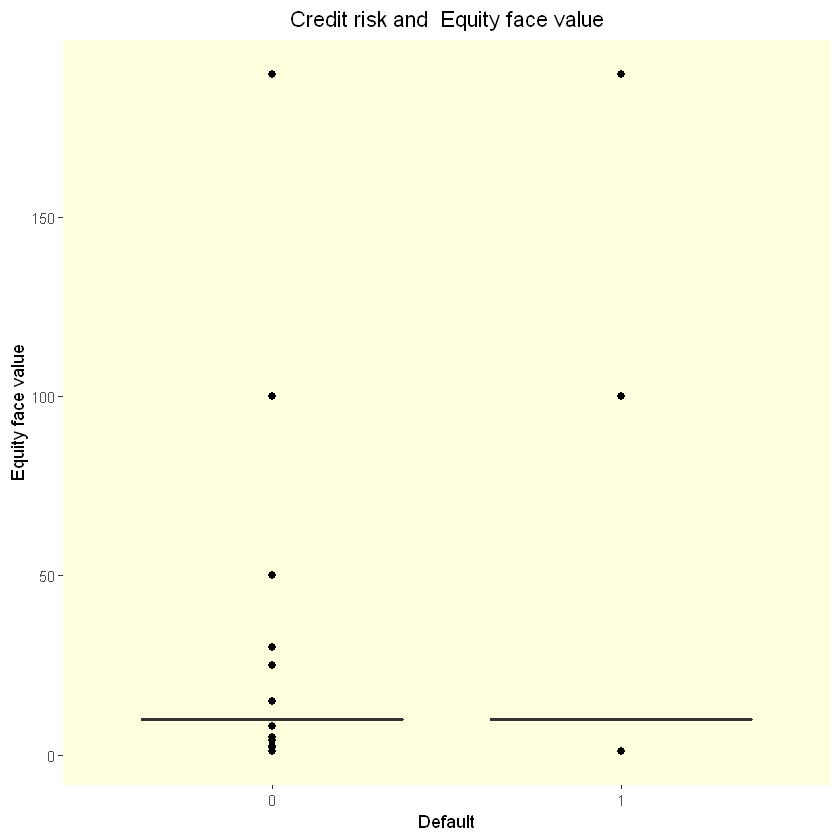

In [23]:
# Equity face value #
par(bg="light blue")
cat(green$bold("The column is \"Equity face value\""))
outlierpercentage(company1, `Equity face value`)
cat("summary before treatment")
summary(company1$`Equity face value`)
company1$`Equity face value`<-replace_median(company1,`Equity face value`)
company1$`Equity face value`<-treat_outliers(company1,`Equity face value`)
cat("summary after treatment")
summary(company1$`Equity face value`)
histogram(company1,`Equity face value`,TRUE,"Equity face value")
graphs(company1,`Equity face value`,TRUE,"Equity face value")

The column is "WIP turnover"Outliers identified:  316  from  2901  observations 
Proportion (%) of outliers:  10.893 
Number of NA's:  640 
NA percentage is: 18.074 
Mean of the outliers:  163.854778481013 
Mean without removing outliers:  27.93 
Mean if we remove outliers:  11.315 
summary before treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -0.18    5.10    9.76   27.93   20.24 5651.40     640 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.238   5.930   9.760  18.628  16.940 218.878 

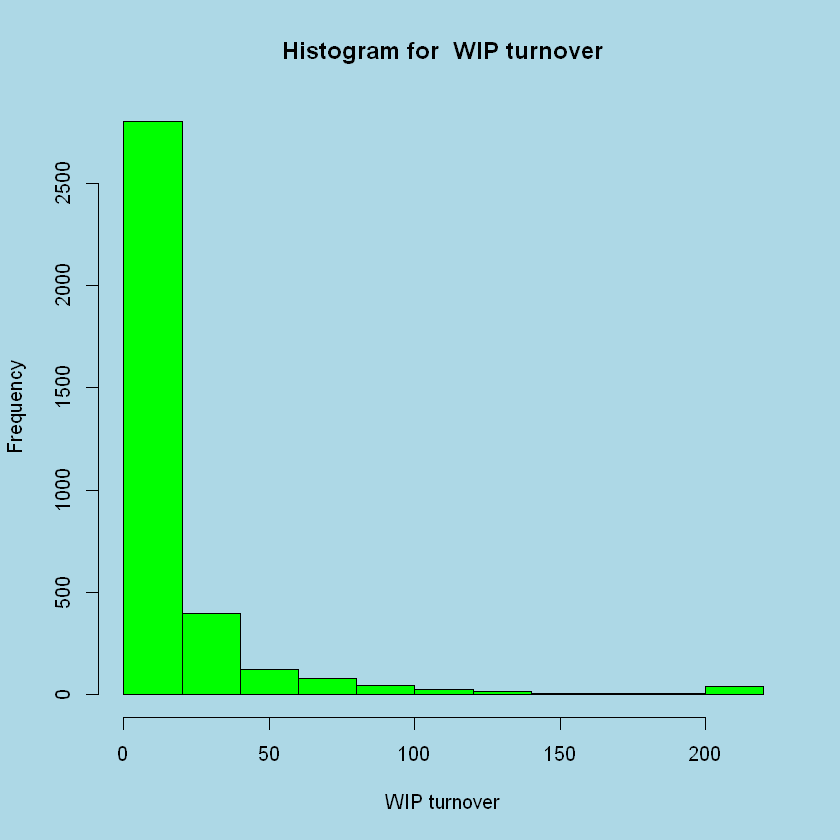

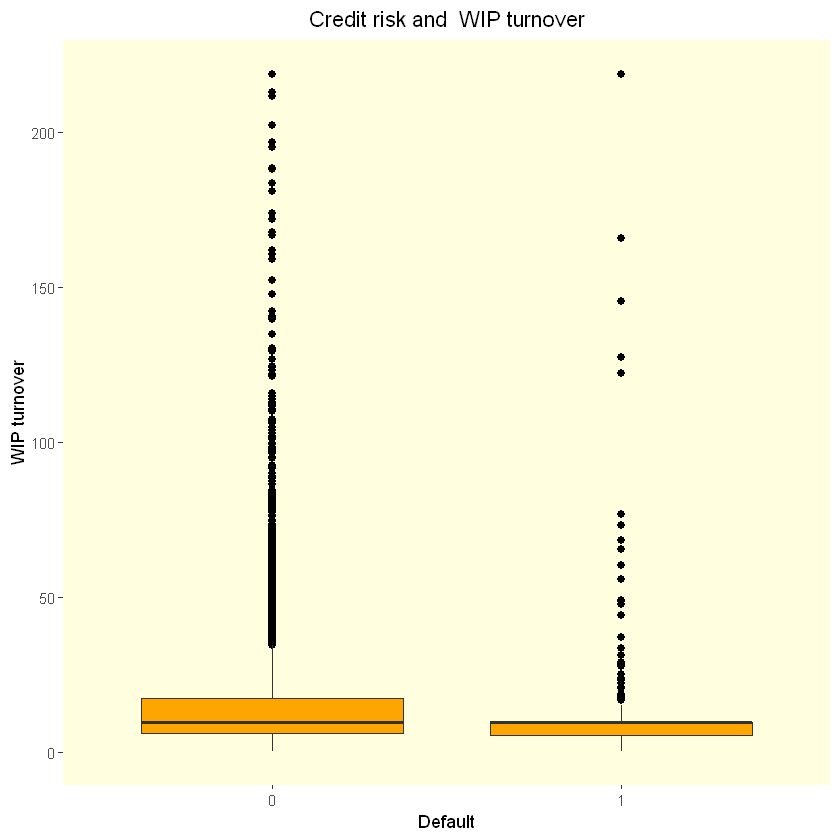

In [24]:
# WIP turnover #
par(bg="light blue")
cat(green$bold("The column is \"WIP turnover\""))
outlierpercentage(company1, `WIP turnover`)
cat("summary before treatment")
summary(company1$`WIP turnover`)
company1$`WIP turnover`<-replace_median(company1,`WIP turnover`)
company1$`WIP turnover`<-treat_outliers(company1,`WIP turnover`)
cat("summary after treatment")
summary(company1$`WIP turnover`)
histogram(company1,`WIP turnover`,TRUE,"WIP turnover")
graphs(company1,`WIP turnover`,TRUE,"WIP turnover")

The column is "Borrowings"Outliers identified:  432  from  3175  observations 
Proportion (%) of outliers:  13.606 
Number of NA's:  366 
NA percentage is: 10.336 
Mean of the outliers:  7310.75162037037 
Mean without removing outliers:  1122.279 
Mean if we remove outliers:  147.646 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
     0.10     23.95     99.20   1122.28    352.60 278257.30       366 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.2    29.7    99.2   600.7   296.0 14803.4 

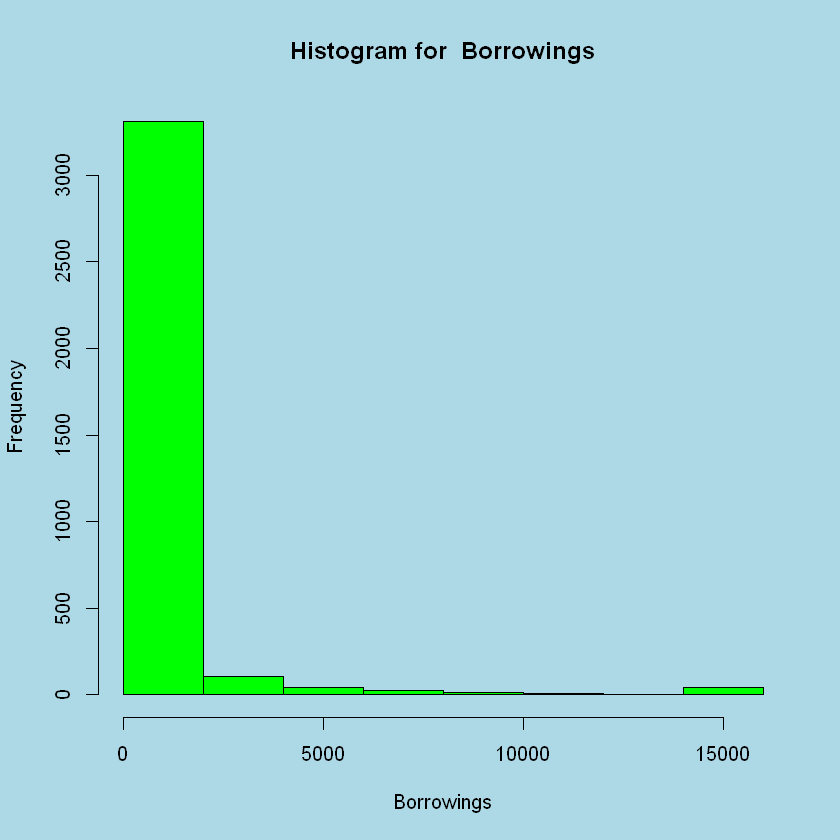

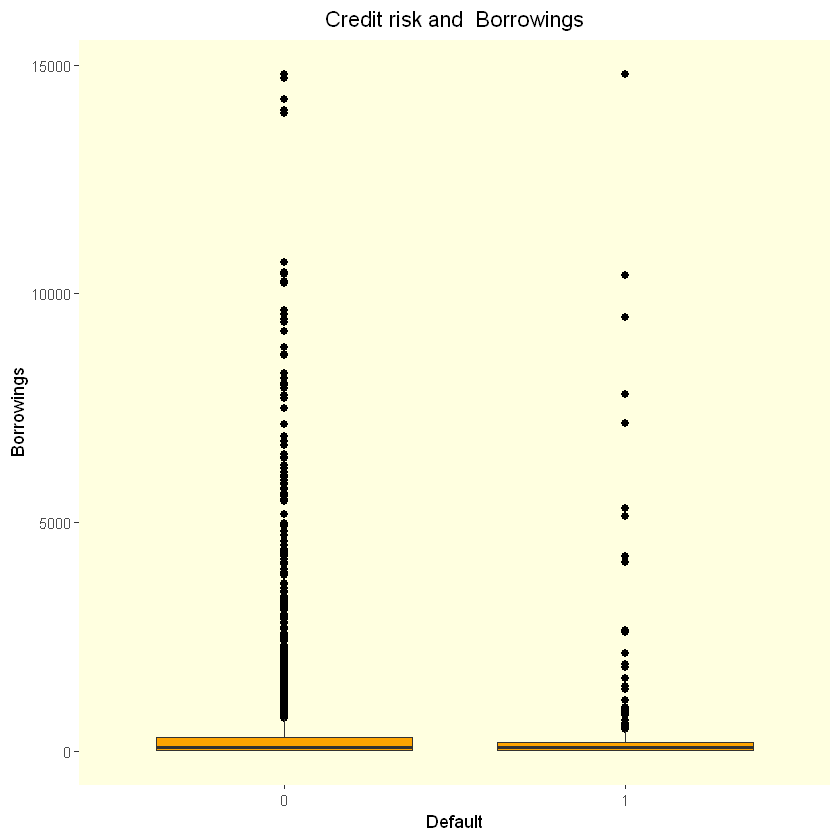

In [25]:
# Borrowings #
par(bg="light blue")
cat(green$bold("The column is \"Borrowings\""))
outlierpercentage(company1, Borrowings)
cat("summary before treatment")
summary(company1$Borrowings)
company1$Borrowings<-replace_median(company1,Borrowings)
company1$Borrowings<-treat_outliers(company1,Borrowings)
cat("summary after treatment")
summary(company1$Borrowings)
histogram(company1,Borrowings,TRUE,"Borrowings")
graphs(company1,Borrowings,TRUE,"Borrowings")

The column is "Raw material turnover"Outliers identified:  247  from  3180  observations 
Proportion (%) of outliers:  7.767 
Number of NA's:  361 
NA percentage is: 10.195 
Mean of the outliers:  161.566923076923 
Mean without removing outliers:  19.088 
Mean if we remove outliers:  7.09 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
   -2.00     2.99     6.40    19.09    11.85 21092.00      361 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    3.41    6.40   10.06   10.92   97.82 

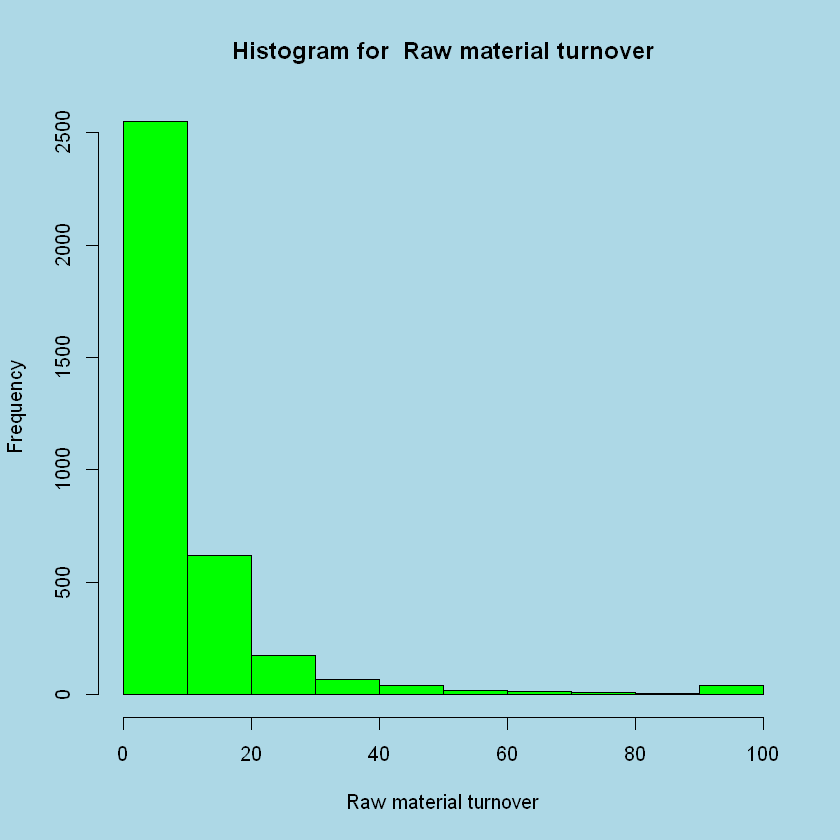

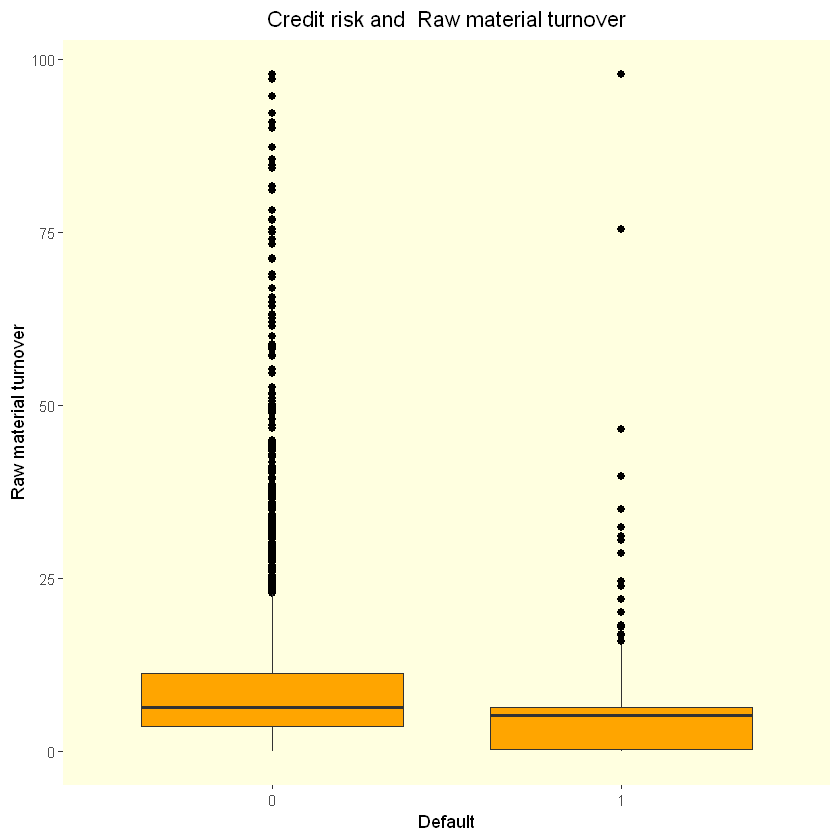

In [26]:
# Raw material turnover #
par(bg="light blue")
cat(green$bold("The column is \"Raw material turnover\""))
outlierpercentage(company1, `Raw material turnover`)
cat("summary before treatment")
summary(company1$`Raw material turnover`)
company1$`Raw material turnover`<-replace_median(company1,`Raw material turnover`)
company1$`Raw material turnover`<-treat_outliers(company1,`Raw material turnover`)
cat("summary after treatment")
summary(company1$`Raw material turnover`)
histogram(company1,`Raw material turnover`,TRUE,"Raw material turnover")
graphs(company1,`Raw material turnover`,TRUE,"Raw material turnover")


The column is "Creditors turnover"Outliers identified:  369  from  3208  observations 
Proportion (%) of outliers:  11.502 
Number of NA's:  333 
NA percentage is: 9.404 
Mean of the outliers:  83.0920325203252 
Mean without removing outliers:  15.446 
Mean if we remove outliers:  6.653 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
   0.000    3.700    6.095   15.446   11.490 2401.000      333 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.940   6.095  11.604  10.550 131.374 

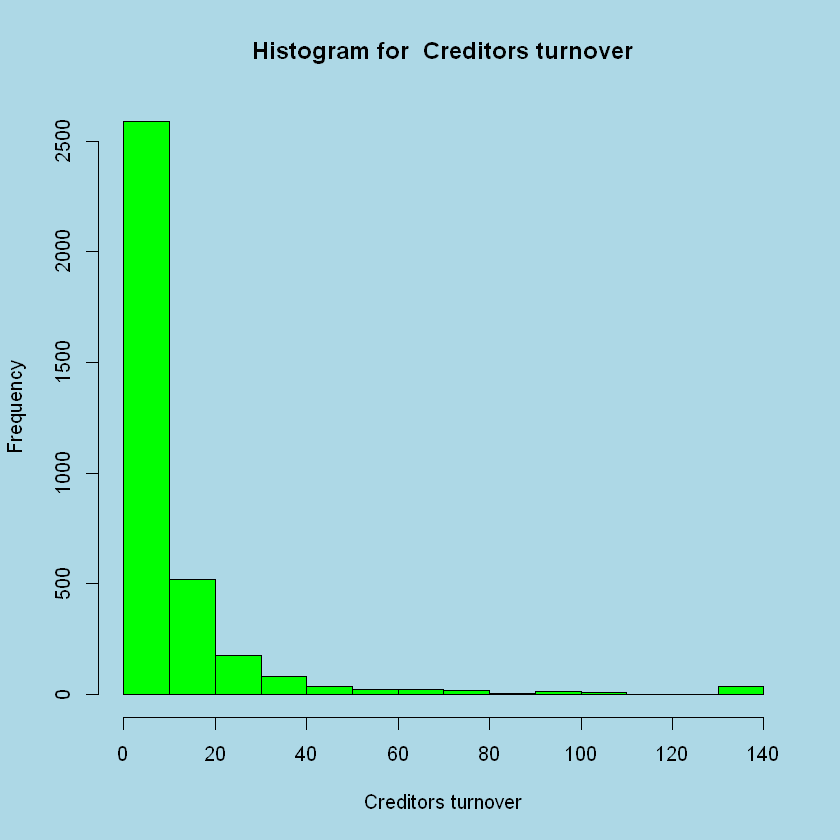

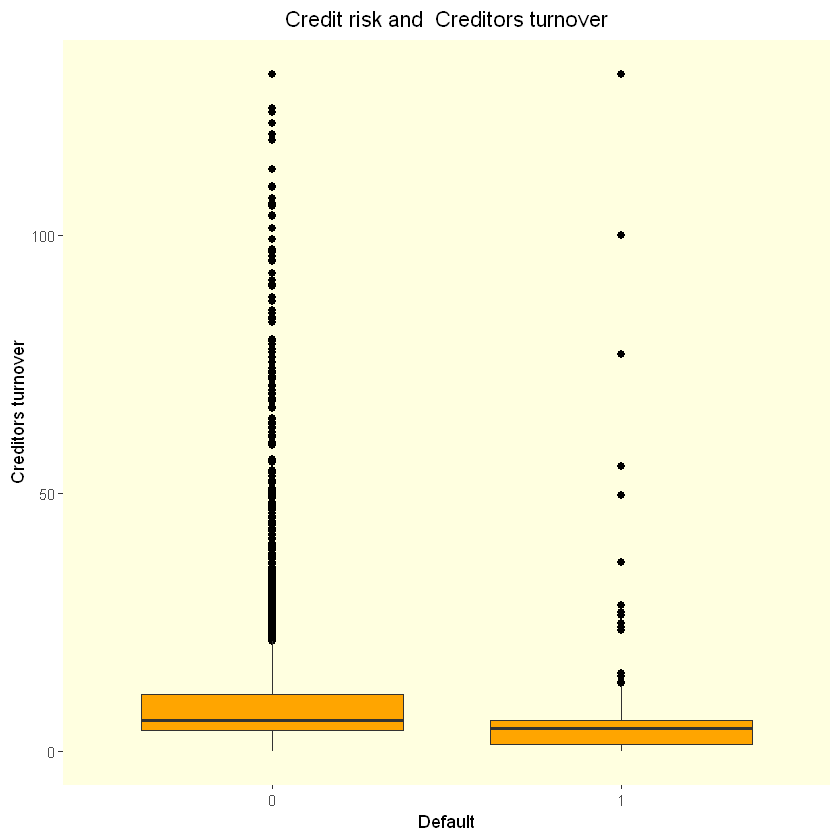

In [27]:
# Creditors turnover #
par(bg="light blue")
cat(green$bold("The column is \"Creditors turnover\""))
outlierpercentage(company1, `Creditors turnover`)
cat("summary before treatment")
summary(company1$`Creditors turnover`)
company1$`Creditors turnover`<-replace_median(company1,`Creditors turnover`)
company1$`Creditors turnover`<-treat_outliers(company1,`Creditors turnover`)
cat("summary after treatment")
summary(company1$`Creditors turnover`)
histogram(company1,`Creditors turnover`,TRUE,"Creditors turnover")
graphs(company1,`Creditors turnover`,TRUE,"Creditors turnover")

The column is "Debtors turnover"Outliers identified:  336  from  3213  observations 
Proportion (%) of outliers:  10.458 
Number of NA's:  328 
NA percentage is: 9.263 
Mean of the outliers:  104.024583333333 
Mean without removing outliers:  17.041 
Mean if we remove outliers:  6.883 
summary before treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    3.76    6.32   17.04   11.68 3135.20     328 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    4.01    6.32   12.69   10.82  182.90 

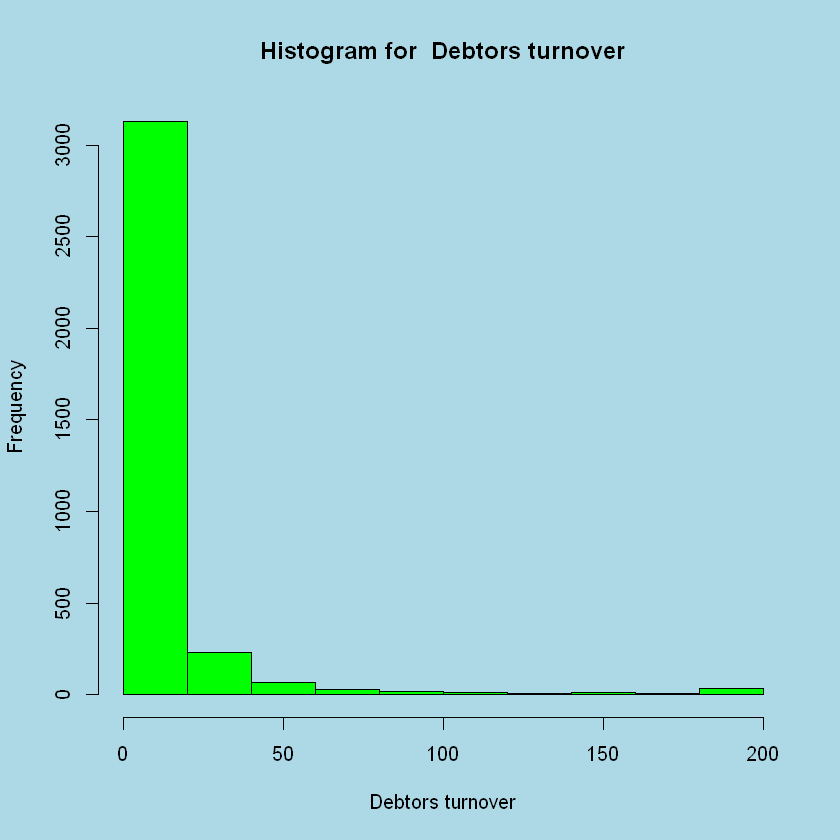

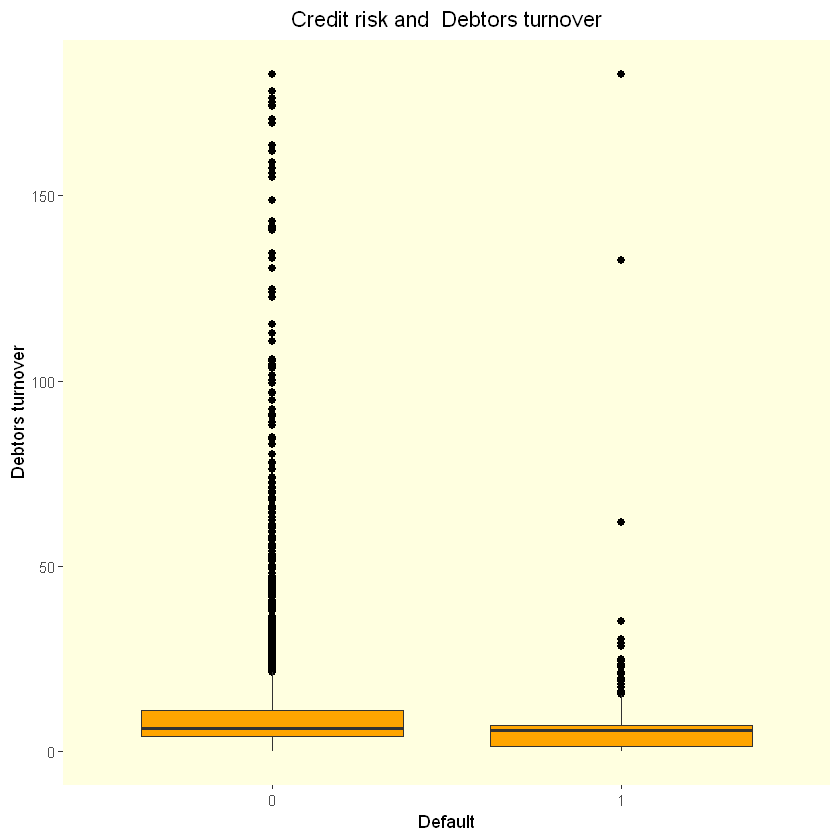

In [28]:
#Debtors turnover #
par(bg="light blue")
cat(green$bold("The column is \"Debtors turnover\""))
outlierpercentage(company1, `Debtors turnover`)
cat("summary before treatment")
summary(company1$`Debtors turnover`)
company1$`Debtors turnover`<-replace_median(company1,`Debtors turnover`)
company1$`Debtors turnover`<-treat_outliers(company1,`Debtors turnover`)
cat("summary after treatment")
summary(company1$`Debtors turnover`)
histogram(company1,`Debtors turnover`,TRUE,"Debtors turnover")
graphs(company1,`Debtors turnover`,TRUE,"Debtors turnover")

The column is "Sales"Outliers identified:  417  from  3282  observations 
Proportion (%) of outliers:  12.706 
Number of NA's:  259 
NA percentage is: 7.314 
Mean of the outliers:  31422.3503597122 
Mean without removing outliers:  4549.52 
Mean if we remove outliers:  638.187 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
      0.1     112.7     453.1    4549.5    1433.5 2384984.4       259 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.5   133.3   453.1  1987.5  1314.7 40605.1 

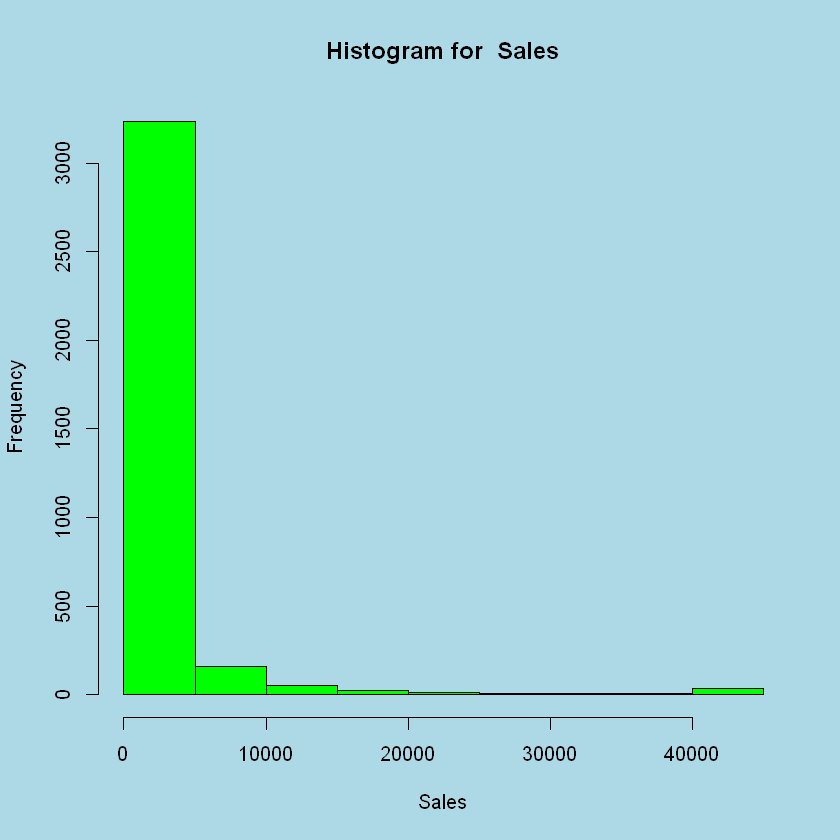

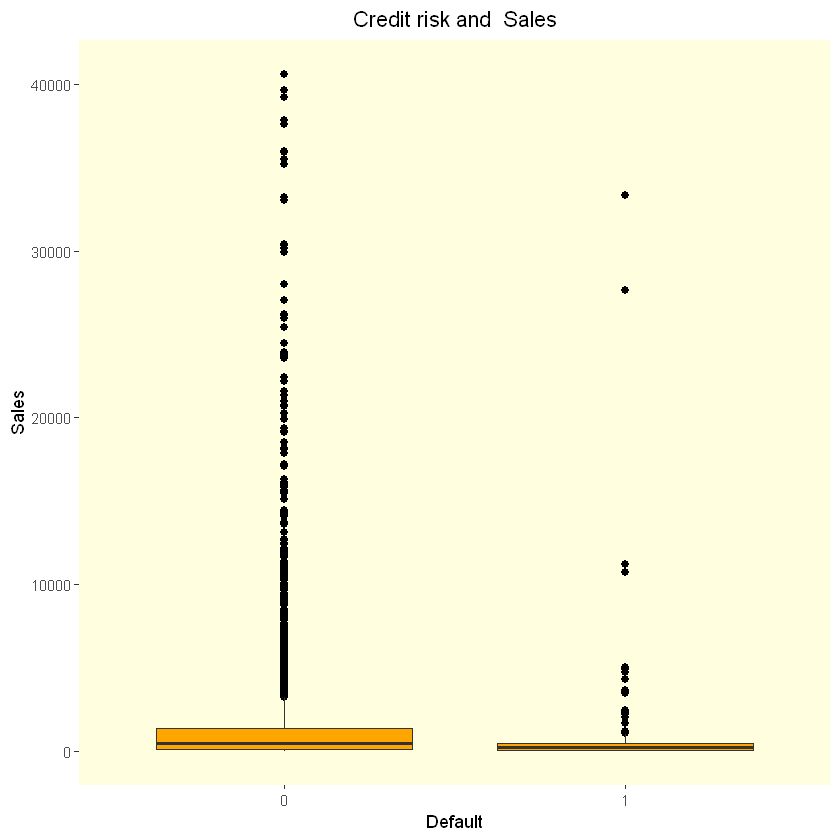

In [29]:
# Sales #
par(bg="light blue")
cat(green$bold("The column is \"Sales\""))
outlierpercentage(company1, Sales)
cat("summary before treatment")
summary(company1$Sales)
company1$Sales<-replace_median(company1,Sales)
company1$Sales<-treat_outliers(company1,Sales)
cat("summary after treatment")
summary(company1$Sales)
histogram(company1,Sales,TRUE,"Sales")
graphs(company1,Sales,TRUE,"Sales")


The column is "Net fixed assets"Outliers identified:  468  from  3423  observations 
Proportion (%) of outliers:  13.672 
Number of NA's:  118 
NA percentage is: 3.332 
Mean of the outliers:  7799.80235042735 
Mean without removing outliers:  1189.678 
Mean if we remove outliers:  142.795 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
     0.0     26.0     93.5   1189.7    344.9 636604.6      118 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.3    27.3    93.5   648.5   328.8 16862.2 

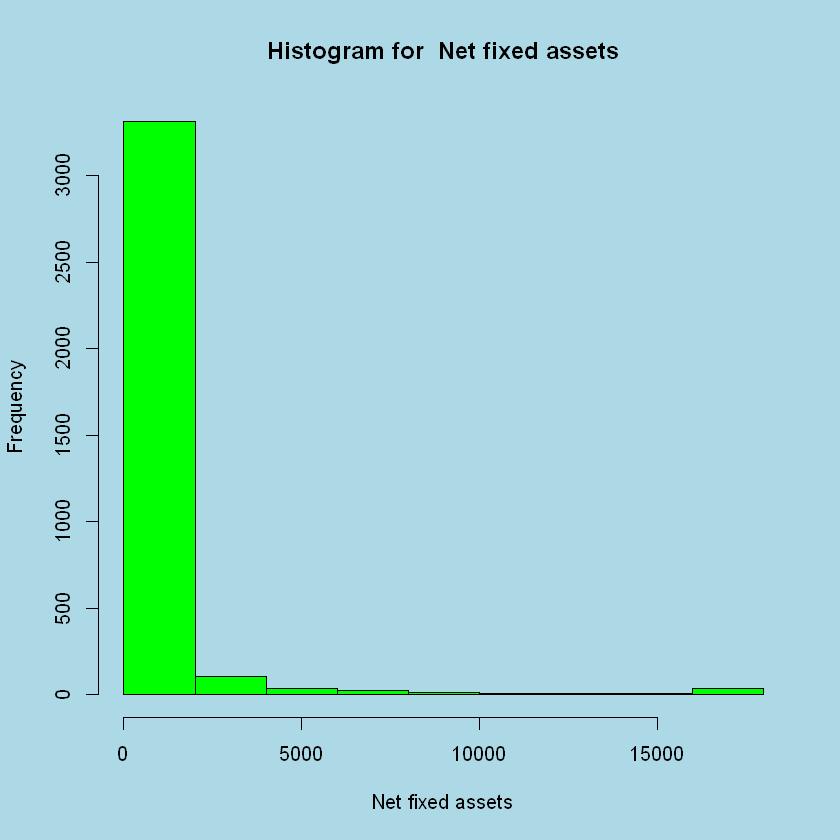

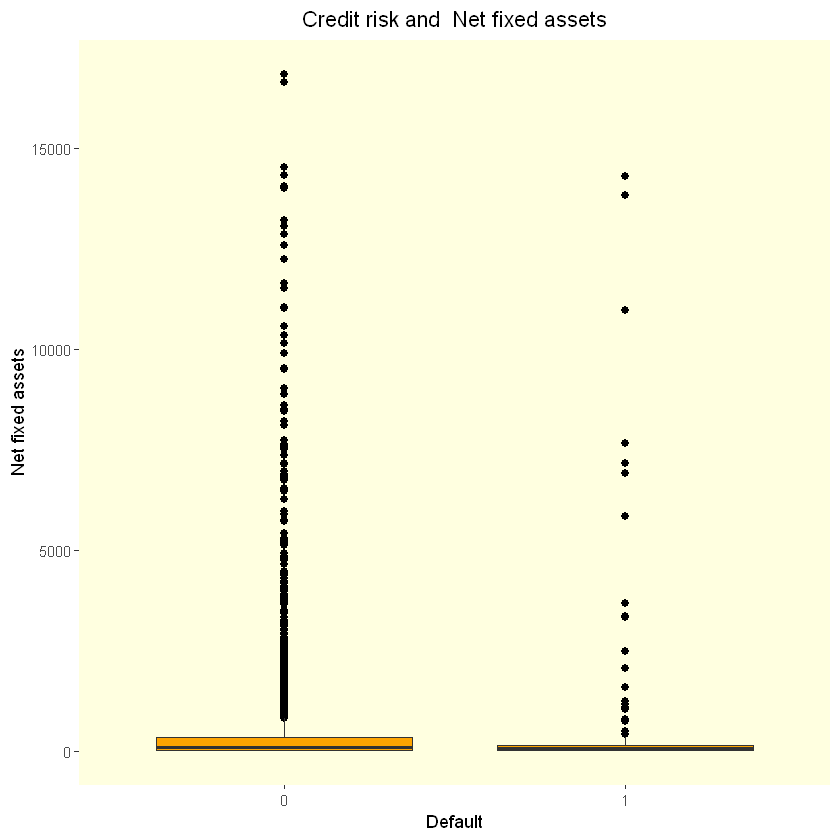

In [30]:
# Net fixed assets #
par(bg="light blue")
cat(green$bold("The column is \"Net fixed assets\""))
outlierpercentage(company1, `Net fixed assets`)
cat("summary before treatment")
summary(company1$`Net fixed assets`)
company1$`Net fixed assets`<-replace_median(company1,`Net fixed assets`)
company1$`Net fixed assets`<-treat_outliers(company1,`Net fixed assets`)
cat("summary after treatment")
summary(company1$`Net fixed assets`)
histogram(company1,`Net fixed assets`,TRUE,"Net fixed assets")
graphs(company1,`Net fixed assets`,TRUE,"Net fixed assets")

The column is "Current liabilities & provisions"Outliers identified:  482  from  3445  observations 
Proportion (%) of outliers:  13.991 
Number of NA's:  96 
NA percentage is: 2.711 
Mean of the outliers:  6073.47116182573 
Mean without removing outliers:  940.627 
Mean if we remove outliers:  105.652 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
     0.1     17.8     69.4    940.6    261.7 352240.3       96 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.1    18.7    69.4   473.2   249.1 11092.0 

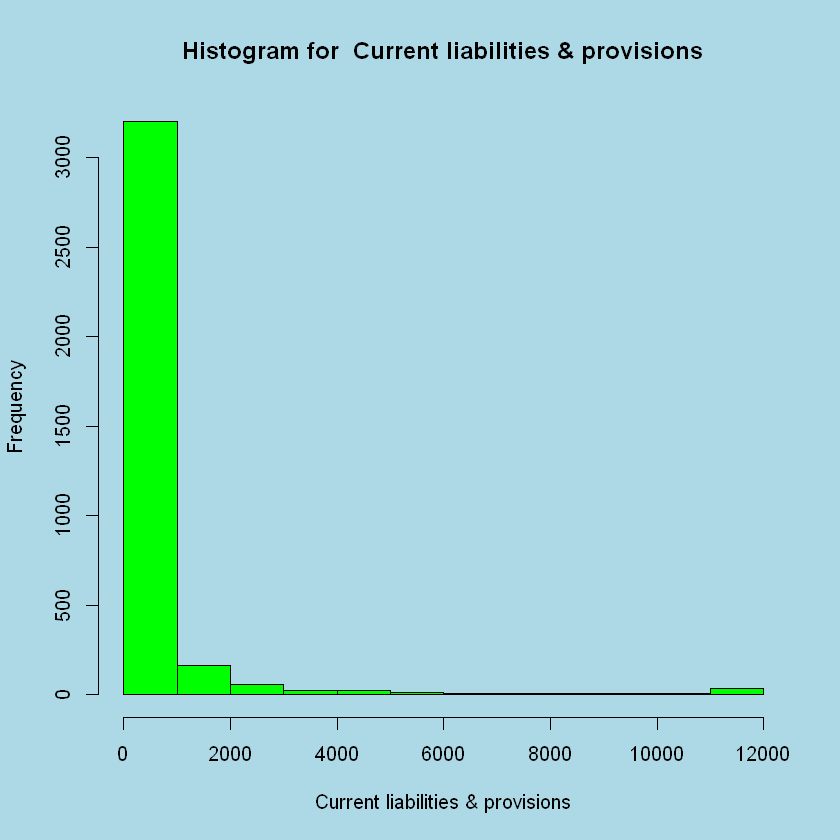

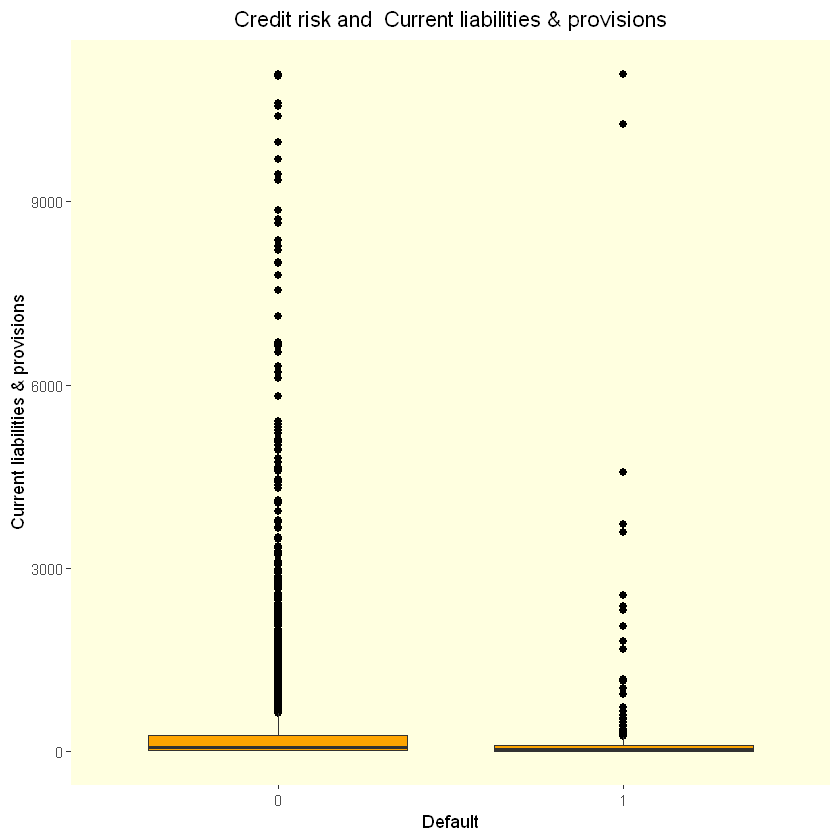

In [31]:
# Current liabilities & provisions #
par(bg="light blue")
cat(green$bold("The column is \"Current liabilities & provisions\""))
outlierpercentage(company1, `Current liabilities & provisions`)
cat("summary before treatment")
summary(company1$`Current liabilities & provisions`)
company1$`Current liabilities & provisions`<-replace_median(company1,`Current liabilities & provisions`)
company1$`Current liabilities & provisions`<-treat_outliers(company1,`Current liabilities & provisions`)
cat("summary after treatment")
summary(company1$`Current liabilities & provisions`)
histogram(company1,`Current liabilities & provisions`,TRUE,"Current liabilities & provisions")
graphs(company1,`Current liabilities & provisions`,TRUE,"Current liabilities & provisions")


The column is "Quick ratio (times)"Outliers identified:  313  from  3448  observations 
Proportion (%) of outliers:  9.078 
Number of NA's:  93 
NA percentage is: 2.626 
Mean of the outliers:  8.66392971246006 
Mean without removing outliers:  1.401 
Mean if we remove outliers:  0.676 
summary before treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.410   0.670   1.401   1.030 341.000      93 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.420   0.670   1.055   1.020  14.000 

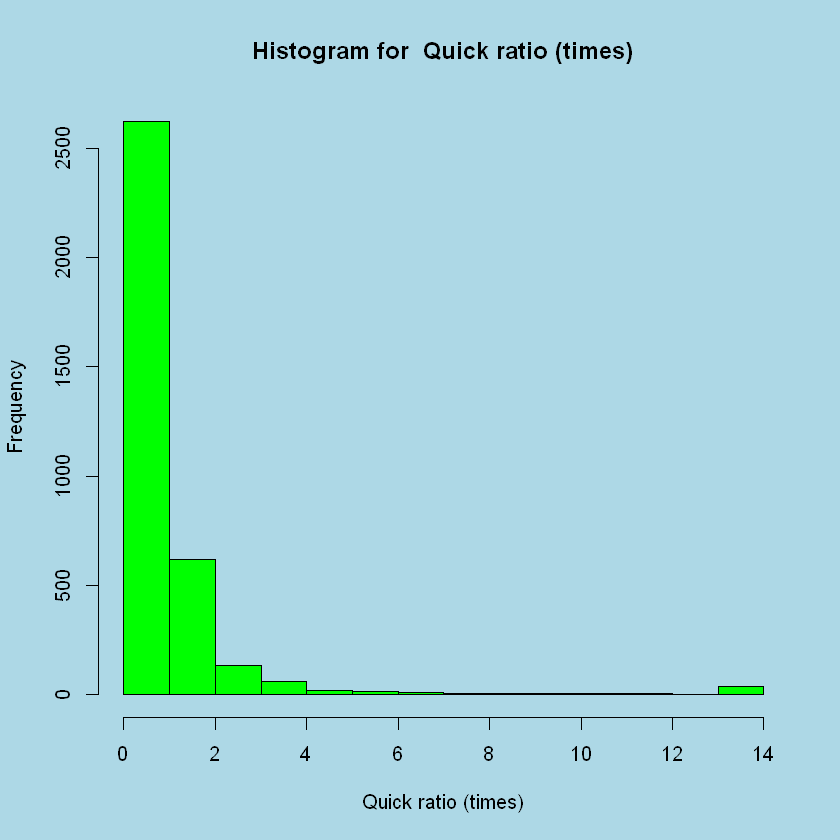

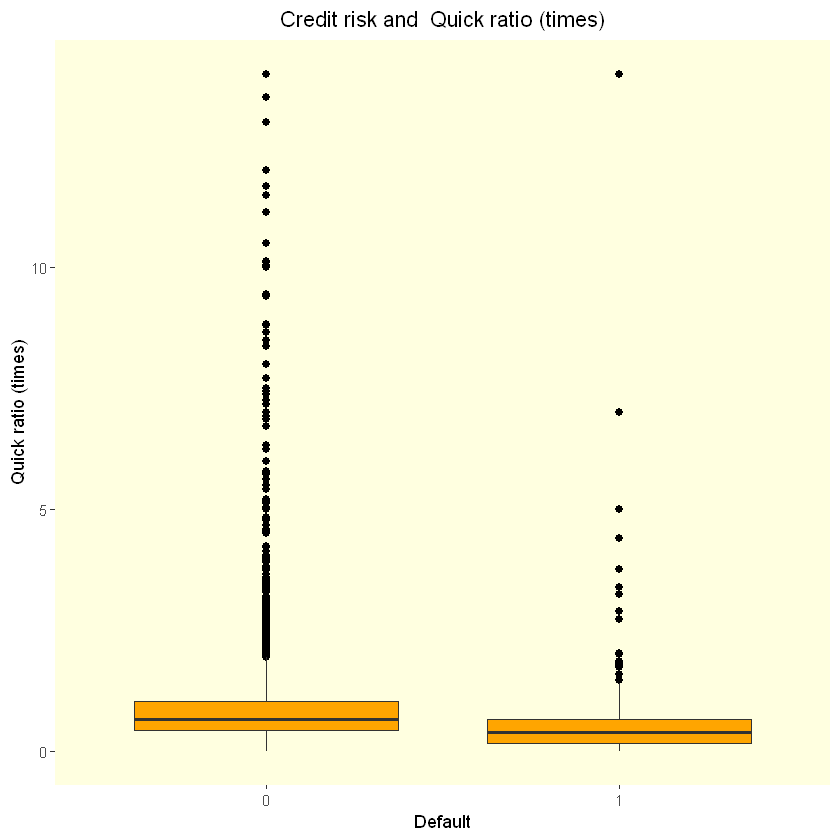

In [32]:
# Quick ratio (times) #
par(bg="light blue")
cat(green$bold("The column is \"Quick ratio (times)\""))
outlierpercentage(company1, `Quick ratio (times)`)
cat("summary before treatment")
summary(company1$`Quick ratio (times)`)
company1$`Quick ratio (times)`<-replace_median(company1,`Quick ratio (times)`)
company1$`Quick ratio (times)`<-treat_outliers(company1,`Quick ratio (times)`)
cat("summary after treatment")
summary(company1$`Quick ratio (times)`)
histogram(company1,`Quick ratio (times)`,TRUE,"Quick ratio (times)")
graphs(company1,`Quick ratio (times)`,TRUE,"Quick ratio (times)")

The column is "Current ratio (times)"Outliers identified:  335  from  3448  observations 
Proportion (%) of outliers:  9.716 
Number of NA's:  93 
NA percentage is: 2.626 
Mean of the outliers:  10.5608059701493 
Mean without removing outliers:  2.13 
Mean if we remove outliers:  1.223 
summary before treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    0.93    1.23    2.13    1.71  505.00      93 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.940   1.230   1.745   1.690  18.920 

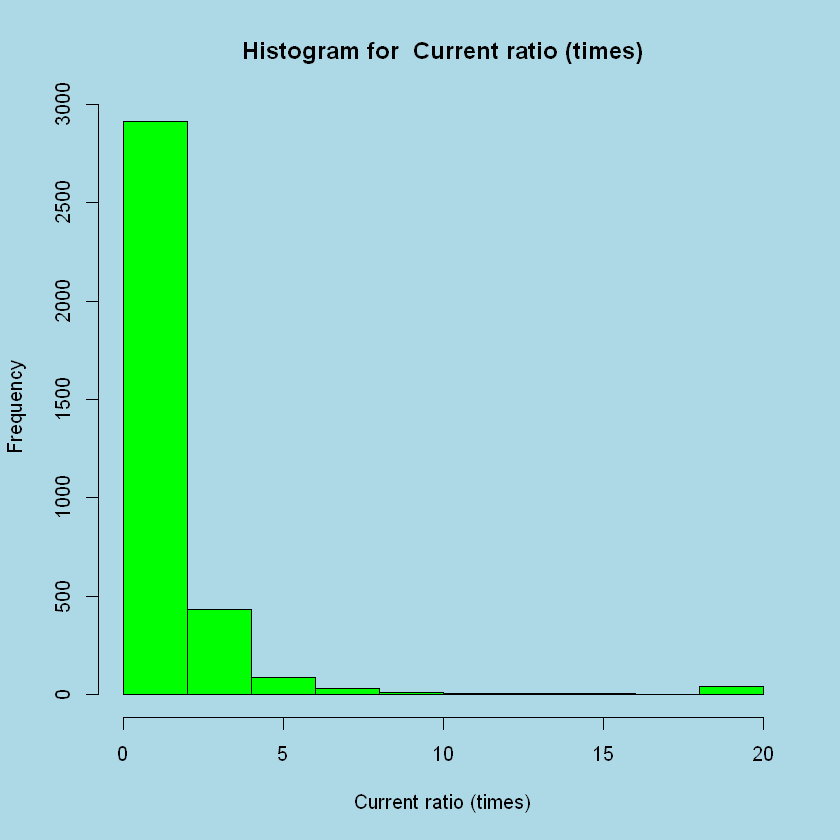

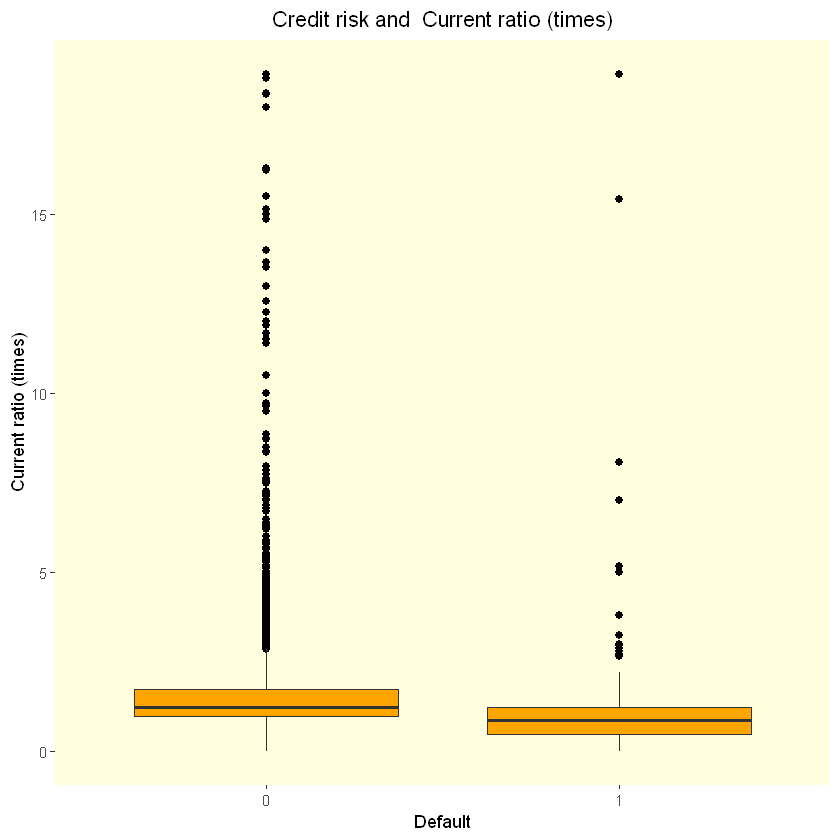

In [33]:
# Current ratio (times) #
par(bg="light blue")
cat(green$bold("The column is \"Current ratio (times)\""))
outlierpercentage(company1, `Current ratio (times)`)
cat("summary before treatment")
summary(company1$`Current ratio (times)`)
company1$`Current ratio (times)`<-replace_median(company1,`Current ratio (times)`)
company1$`Current ratio (times)`<-treat_outliers(company1,`Current ratio (times)`)
cat("summary after treatment")
summary(company1$`Current ratio (times)`)
histogram(company1,`Current ratio (times)`,TRUE,"Current ratio (times)")
graphs(company1,`Current ratio (times)`,TRUE,"Current ratio (times)")

The column is "Cash to current liabilities (times)"Outliers identified:  452  from  3448  observations 
Proportion (%) of outliers:  13.109 
Number of NA's:  93 
NA percentage is: 2.626 
Mean of the outliers:  3.15712389380531 
Mean without removing outliers:  0.49 
Mean if we remove outliers:  0.088 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
  0.0000   0.0200   0.0700   0.4904   0.1900 165.0000       93 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0200  0.0700  0.2883  0.1900  5.7780 

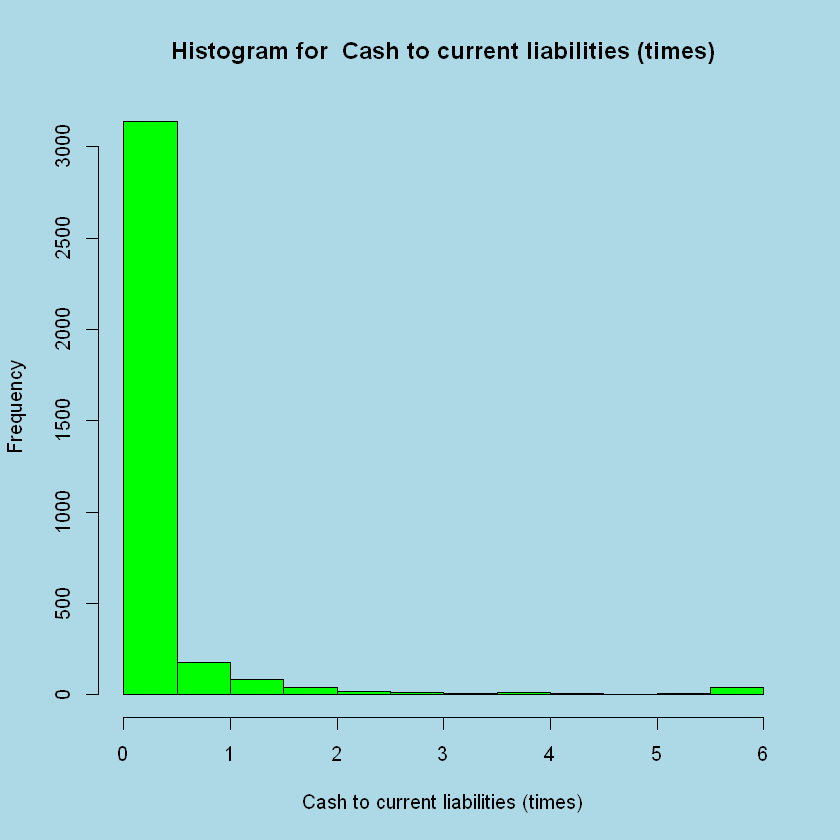

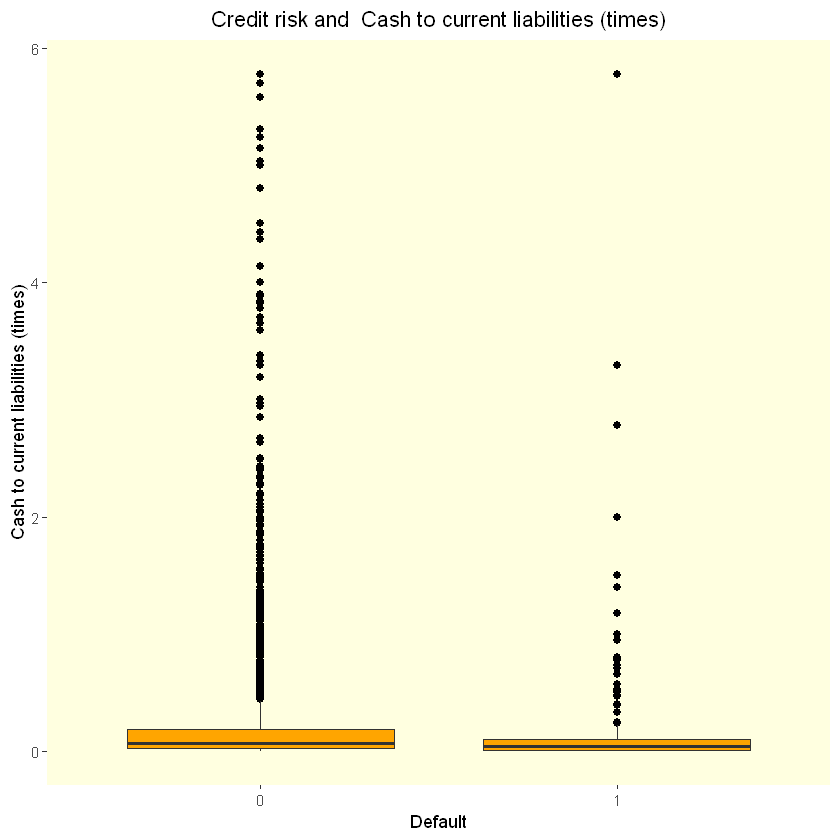

In [34]:
# Cash to current liabilities (times) #
par(bg="light blue")
cat(green$bold("The column is \"Cash to current liabilities (times)\""))
outlierpercentage(company1, `Cash to current liabilities (times)`)
cat("summary before treatment")
summary(company1$`Cash to current liabilities (times)`)
company1$`Cash to current liabilities (times)`<-replace_median(company1,`Cash to current liabilities (times)`)
company1$`Cash to current liabilities (times)`<-treat_outliers(company1,`Cash to current liabilities (times)`)
cat("summary after treatment")
summary(company1$`Cash to current liabilities (times)`)
histogram(company1,`Cash to current liabilities (times)`,TRUE,"Cash to current liabilities (times)")
graphs(company1,`Cash to current liabilities (times)`,TRUE,"Cash to current liabilities (times)")

The column is "Reserves and funds"Outliers identified:  526  from  3456  observations 
Proportion (%) of outliers:  15.22 
Number of NA's:  85 
NA percentage is: 2.4 
Mean of the outliers:  7118.59429657795 
Mean without removing outliers:  1163.815 
Mean if we remove outliers:  94.8 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
 -6525.9      5.0     54.8   1163.8    277.3 625137.8       85 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -226.2     5.8    54.8   608.3   263.2 17416.7 

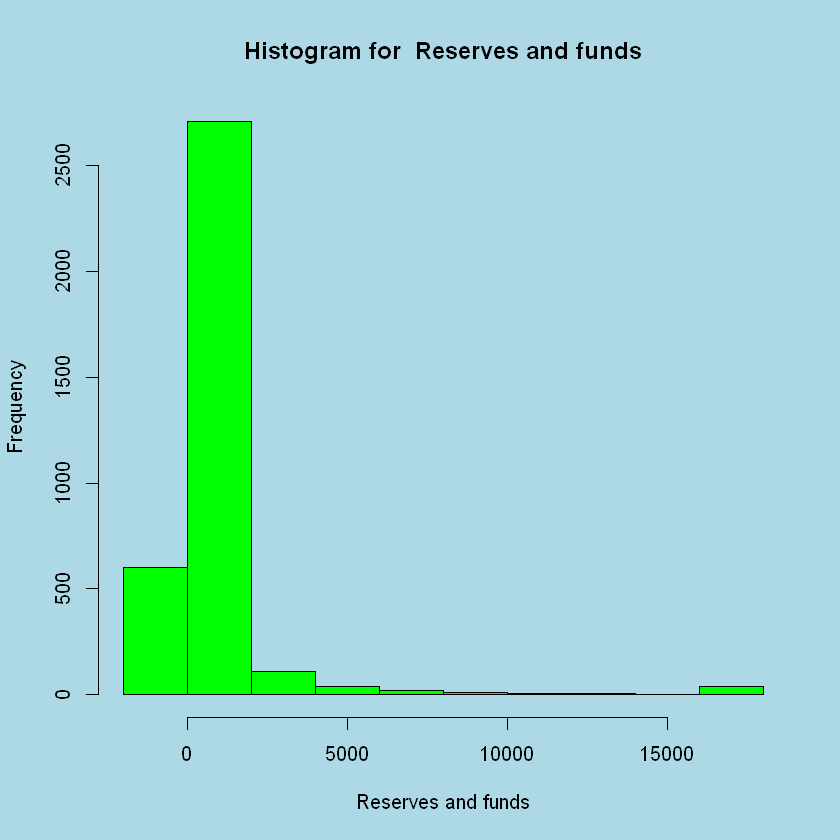

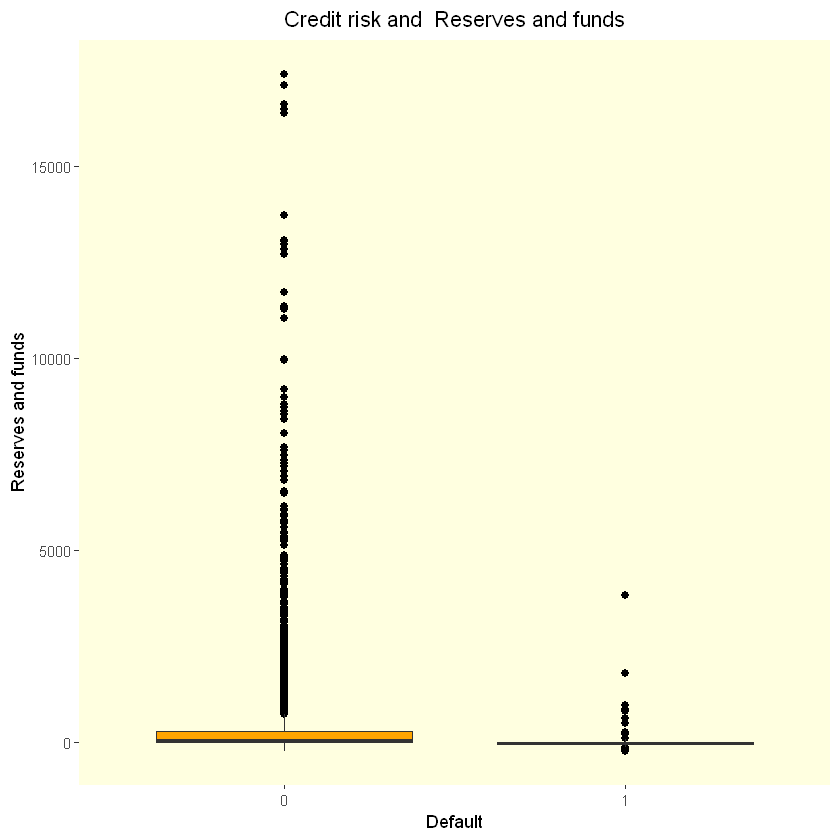

In [35]:
# Reserves and funds #
par(bg="light blue")
cat(green$bold("The column is \"Reserves and funds\""))
outlierpercentage(company1, `Reserves and funds`)
cat("summary before treatment")
summary(company1$`Reserves and funds`)
company1$`Reserves and funds`<-replace_median(company1,`Reserves and funds`)
company1$`Reserves and funds`<-treat_outliers(company1,`Reserves and funds`)
cat("summary after treatment")
summary(company1$`Reserves and funds`)
histogram(company1,`Reserves and funds`,TRUE,"Reserves and funds")
graphs(company1,`Reserves and funds`,TRUE,"Reserves and funds")

The column is "Cash to average cost of sales per day"Outliers identified:  483  from  3456  observations 
Proportion (%) of outliers:  13.976 
Number of NA's:  85 
NA percentage is: 2.4 
Mean of the outliers:  1072.46979296066 
Mean without removing outliers:  158.443 
Mean if we remove outliers:  9.949 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
     0.00      2.79      8.02    158.44     21.79 128040.76        85 

summary after treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    2.890    8.025   47.425   21.150 1277.500 

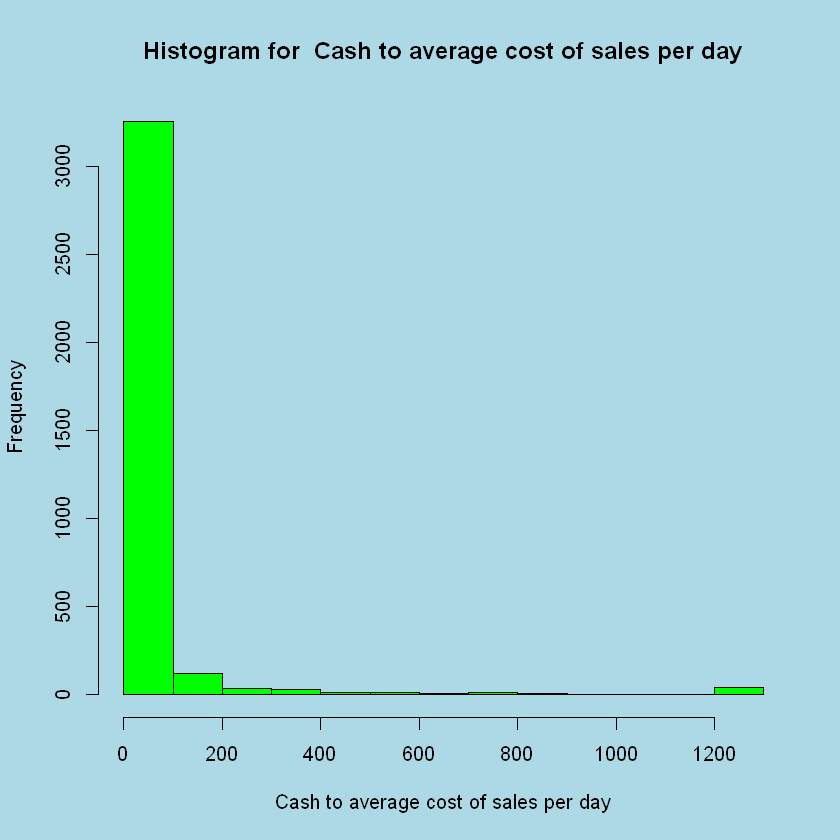

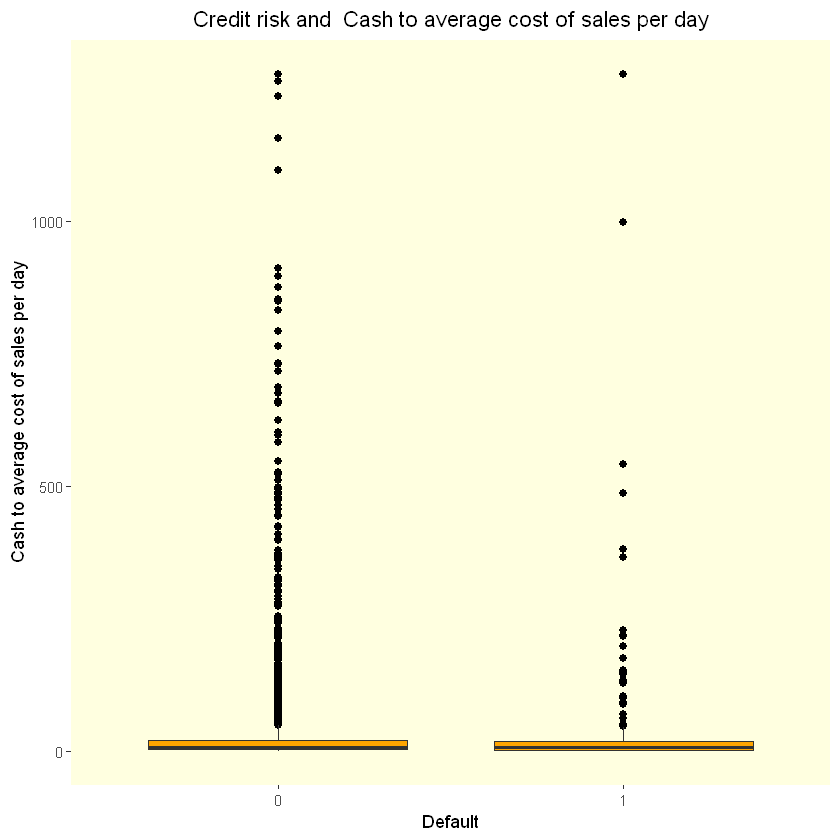

In [36]:
# Cash to average cost of sales per day #
par(bg="light blue")
cat(green$bold("The column is \"Cash to average cost of sales per day\""))
outlierpercentage(company1, `Cash to average cost of sales per day`)
cat("summary before treatment")
summary(company1$`Cash to average cost of sales per day`)
company1$`Cash to average cost of sales per day`<-replace_median(company1,`Cash to average cost of sales per day`)
company1$`Cash to average cost of sales per day`<-treat_outliers(company1,`Cash to average cost of sales per day`)
cat("summary after treatment")
summary(company1$`Cash to average cost of sales per day`)
histogram(company1,`Cash to average cost of sales per day`,TRUE,"Cash to average cost of sales per day")
graphs(company1,`Cash to average cost of sales per day`,TRUE,"Cash to average cost of sales per day")

The column is "PBT as % of total income"Outliers identified:  453  from  3473  observations 
Proportion (%) of outliers:  13.043 
Number of NA's:  68 
NA percentage is: 1.92 
Mean of the outliers:  -163.218697571744 
Mean without removing outliers:  -17.279 
Mean if we remove outliers:  4.612 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
-21340.00      0.55      3.31    -17.28      8.80    100.00        68 

summary after treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-226.2640    0.6000    3.3100    0.6765    8.6300   51.6600 

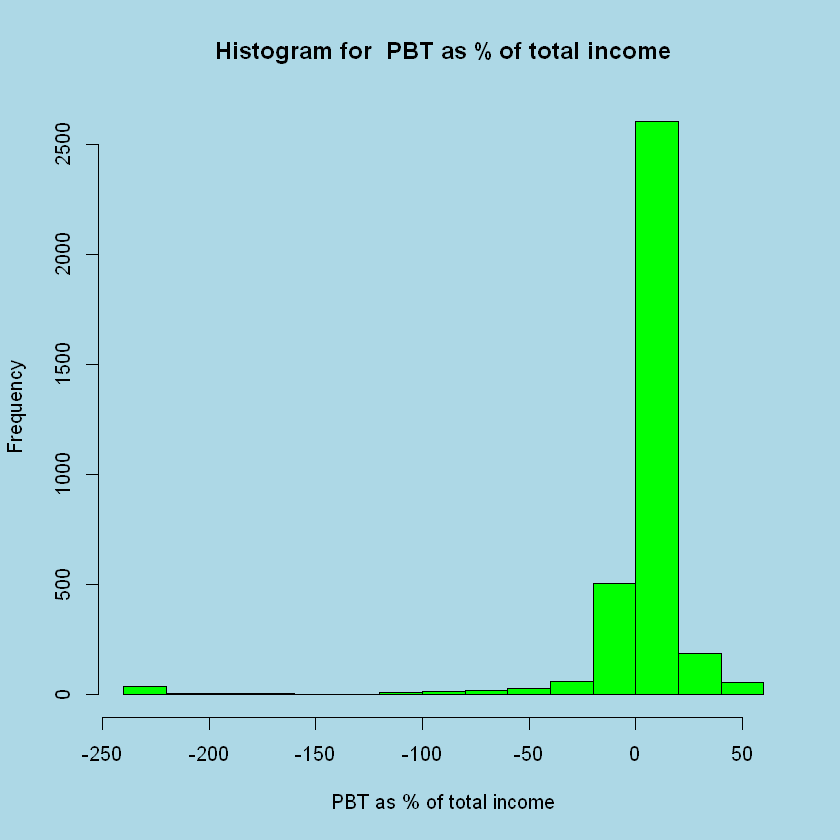

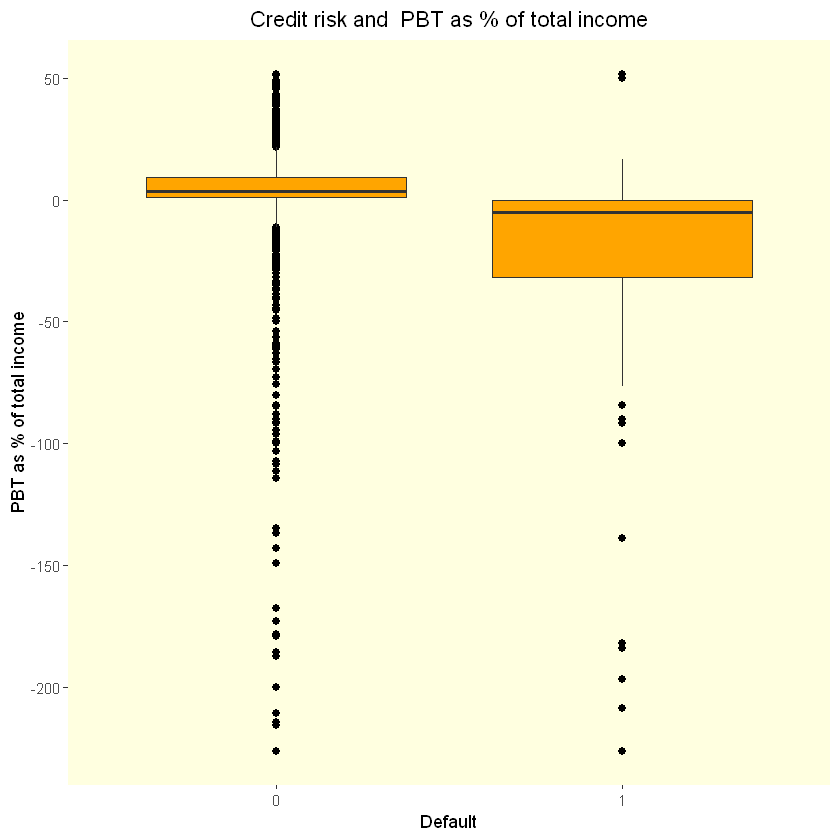

In [37]:
# PBT as % of total income #
par(bg="light blue")
cat(green$bold("The column is \"PBT as % of total income\""))
outlierpercentage(company1, `PBT as % of total income`)
cat("summary before treatment")
summary(company1$`PBT as % of total income`)
company1$`PBT as % of total income`<-replace_median(company1,`PBT as % of total income`)
company1$`PBT as % of total income`<-treat_outliers(company1,`PBT as % of total income`)
cat("summary after treatment")
summary(company1$`PBT as % of total income`)
histogram(company1,`PBT as % of total income`,TRUE,"PBT as % of total income")
graphs(company1,`PBT as % of total income`,TRUE,"PBT as % of total income")

The column is "PAT as % of total income"Outliers identified:  502  from  3473  observations 
Proportion (%) of outliers:  14.454 
Number of NA's:  68 
NA percentage is: 1.92 
Mean of the outliers:  -152.776454183267 
Mean without removing outliers:  -19.2 
Mean if we remove outliers:  3.37 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
-21340.00      0.35      2.34    -19.20      6.34    150.00        68 

summary after treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-219.5640    0.3900    2.3400   -0.6568    6.2500   43.5500 

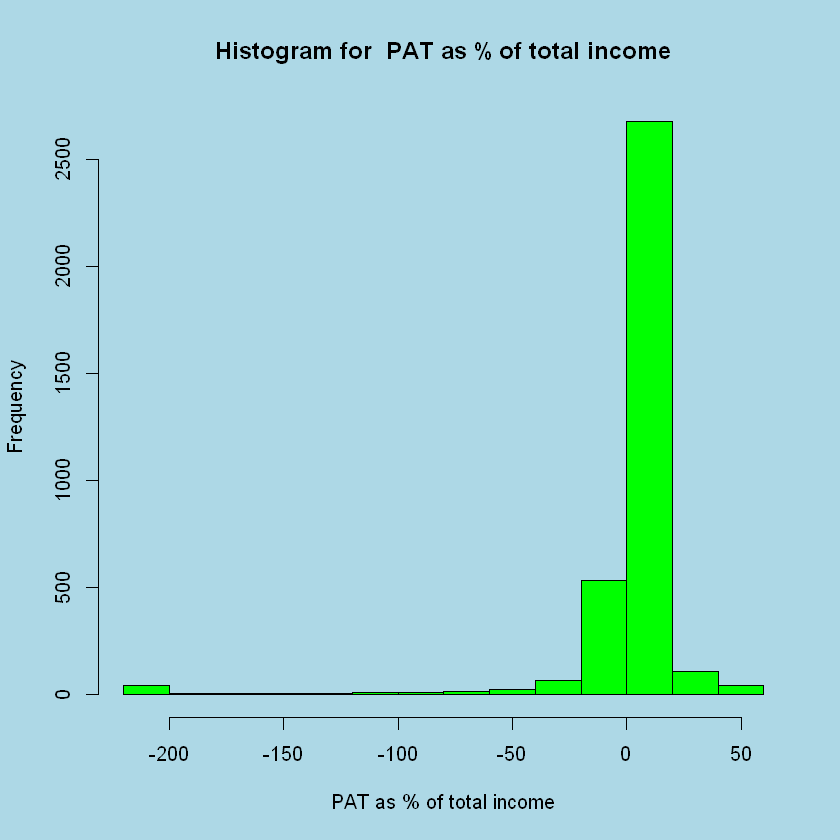

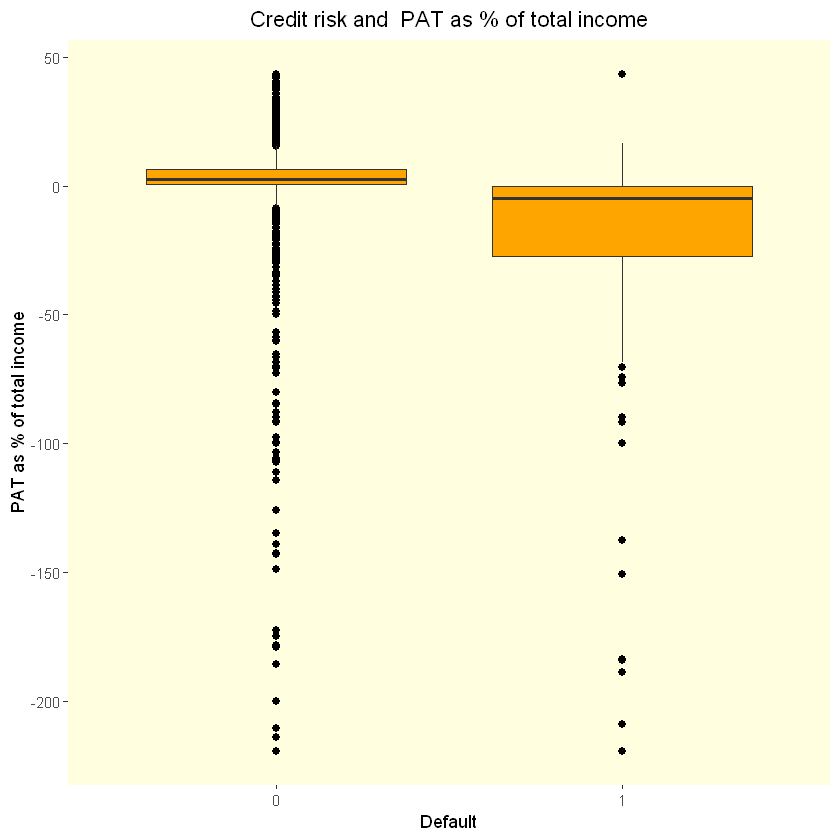

In [38]:
# PAT as % of total income #
par(bg="light blue")
cat(green$bold("The column is \"PAT as % of total income\""))
outlierpercentage(company1, `PAT as % of total income`)
cat("summary before treatment")
summary(company1$`PAT as % of total income`)
company1$`PAT as % of total income`<-replace_median(company1,`PAT as % of total income`)
company1$`PAT as % of total income`<-treat_outliers(company1,`PAT as % of total income`)
cat("summary after treatment")
summary(company1$`PAT as % of total income`)
histogram(company1,`PAT as % of total income`,TRUE,"PAT as % of total income")
graphs(company1,`PAT as % of total income`,TRUE,"PAT as % of total income")

The column is "Cash profit as % of total income"Outliers identified:  353  from  3473  observations 
Proportion (%) of outliers:  10.164 
Number of NA's:  68 
NA percentage is: 1.92 
Mean of the outliers:  -138.217053824363 
Mean without removing outliers:  -8.229 
Mean if we remove outliers:  6.478 
summary before treatment

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max.       NA's 
-15020.000      2.020      5.640     -8.229     10.700    100.000         68 

summary after treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-132.170    2.090    5.640    5.005   10.560   56.244 

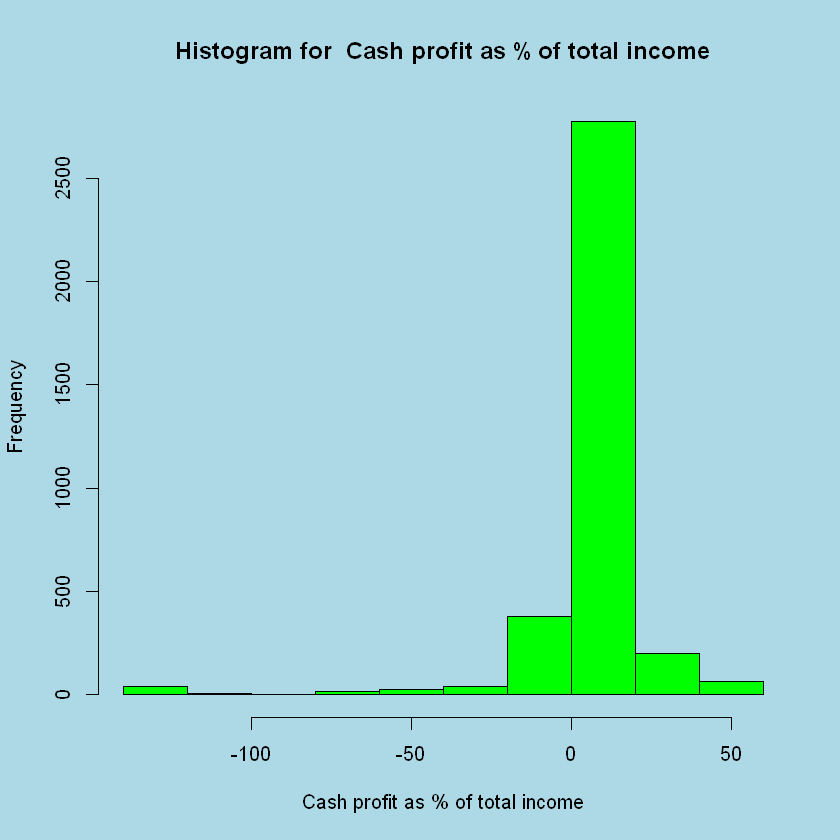

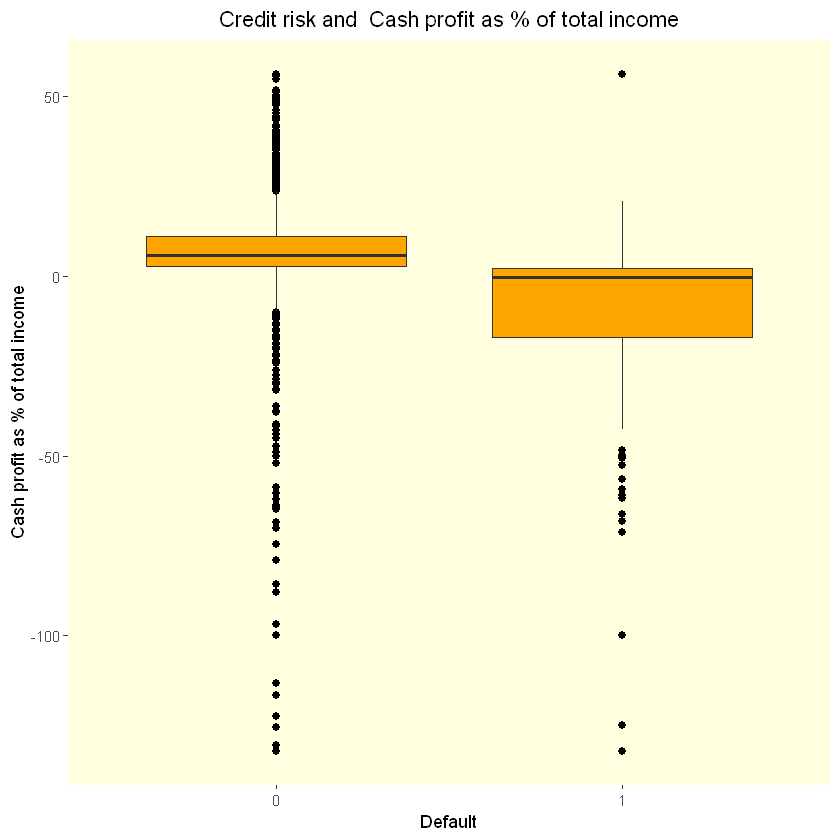

In [39]:
# Cash profit as % of total income #
par(bg="light blue")
cat(green$bold("The column is \"Cash profit as % of total income\""))
outlierpercentage(company1, `Cash profit as % of total income`)
cat("summary before treatment")
summary(company1$`Cash profit as % of total income`)
company1$`Cash profit as % of total income`<-replace_median(company1,`Cash profit as % of total income`)
company1$`Cash profit as % of total income`<-treat_outliers(company1,`Cash profit as % of total income`)
cat("summary after treatment")
summary(company1$`Cash profit as % of total income`)
histogram(company1,`Cash profit as % of total income`,TRUE,"Cash profit as % of total income")
graphs(company1,`Cash profit as % of total income`,TRUE,"Cash profit as % of total income")


The column is "Current assets"Outliers identified:  451  from  3475  observations 
Proportion (%) of outliers:  12.978 
Number of NA's:  66 
NA percentage is: 1.864 
Mean of the outliers:  8514.94678492239 
Mean without removing outliers:  1293.364 
Mean if we remove outliers:  216.336 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
     0.1     36.2    145.1   1293.4    502.2 354815.2       66 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.2    37.2   145.1   778.6   485.9 17377.1 

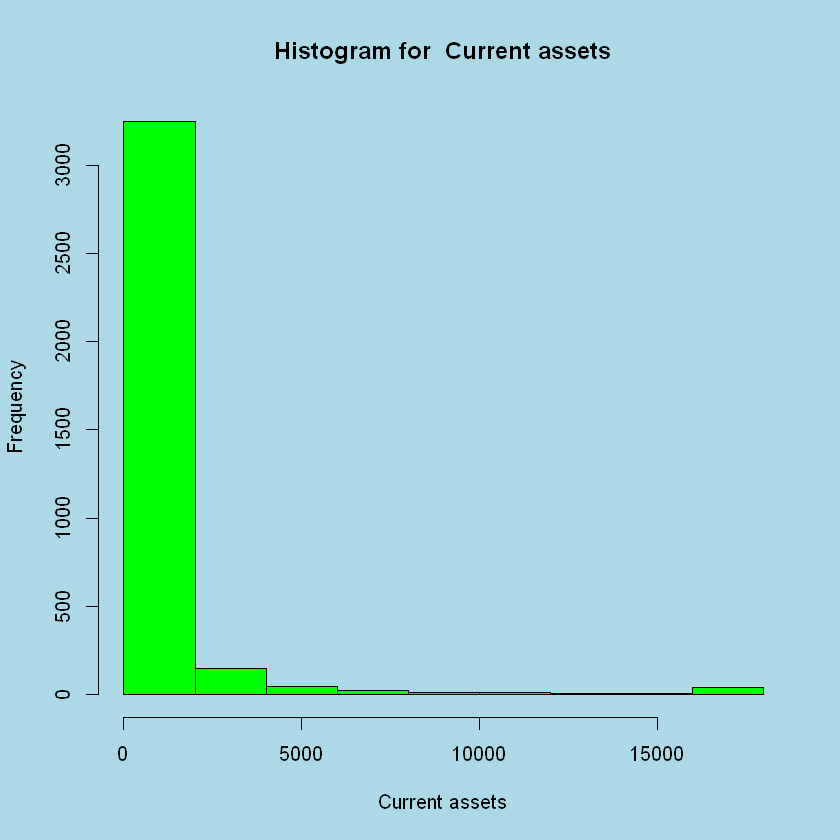

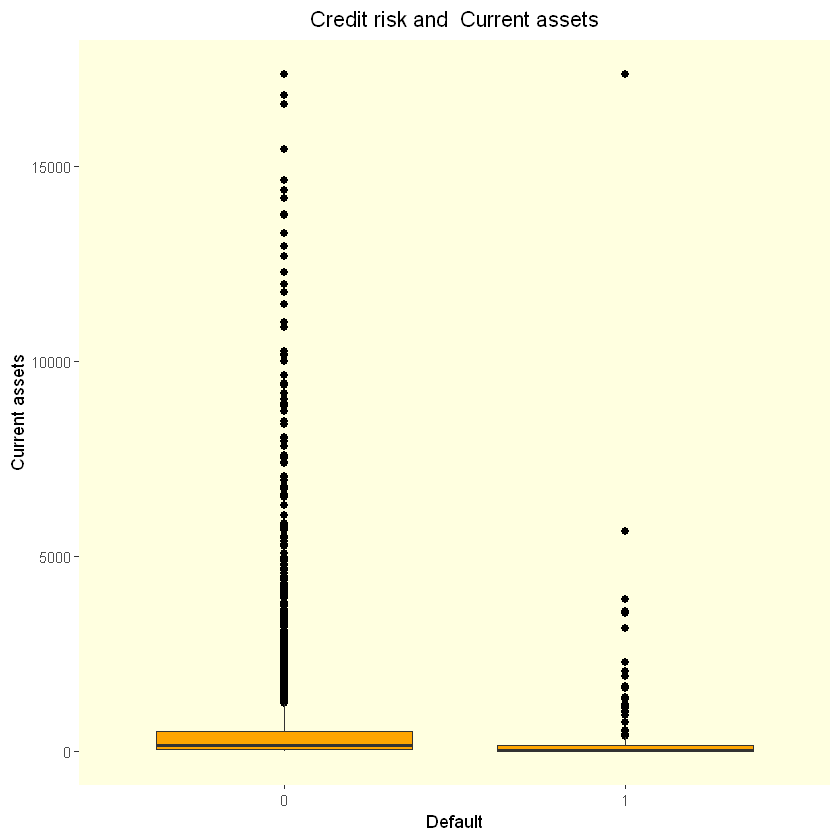

In [40]:
# Current assets #
par(bg="light blue")
cat(green$bold("The column is \"Current assets\""))
outlierpercentage(company1, `Current assets`)
cat("summary before treatment")
summary(company1$`Current assets`)
company1$`Current assets`<-replace_median(company1,`Current assets`)
company1$`Current assets`<-treat_outliers(company1,`Current assets`)
cat("summary after treatment")
summary(company1$`Current assets`)
histogram(company1,`Current assets`,TRUE,"Current assets")
graphs(company1,`Current assets`,TRUE,"Current assets")


The column is "Cumulative retained profits"Outliers identified:  575  from  3503  observations 
Proportion (%) of outliers:  16.415 
Number of NA's:  38 
NA percentage is: 1.073 
Mean of the outliers:  5096.06173913043 
Mean without removing outliers:  890.513 
Mean if we remove outliers:  64.628 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
 -6534.3      1.1     37.1    890.5    202.4 390133.8       38 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -489.3     1.3    37.1   444.4   199.4 13027.3 

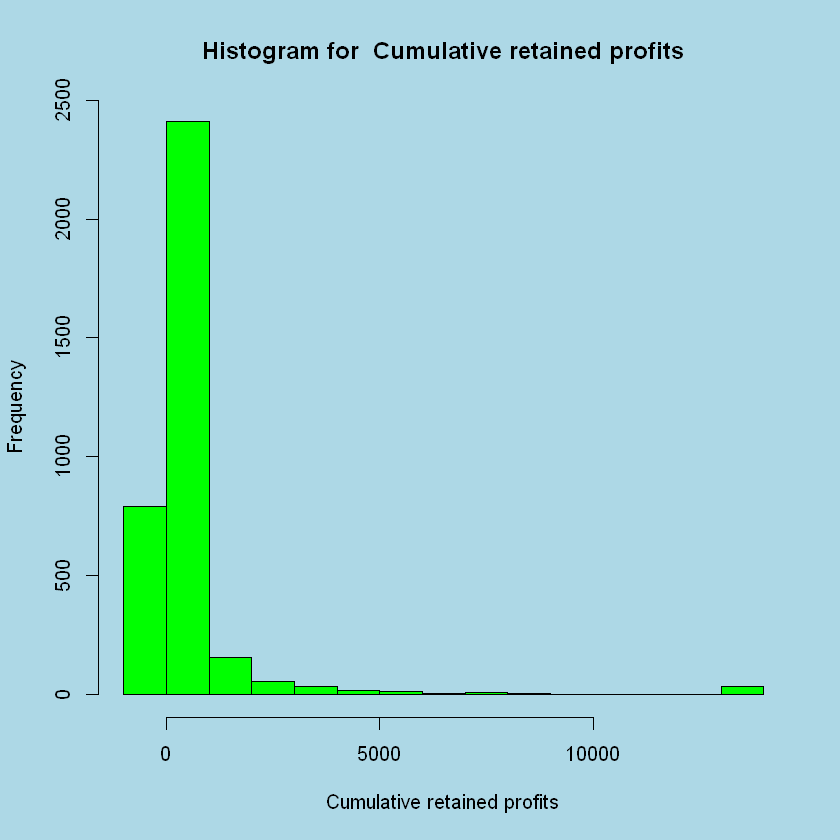

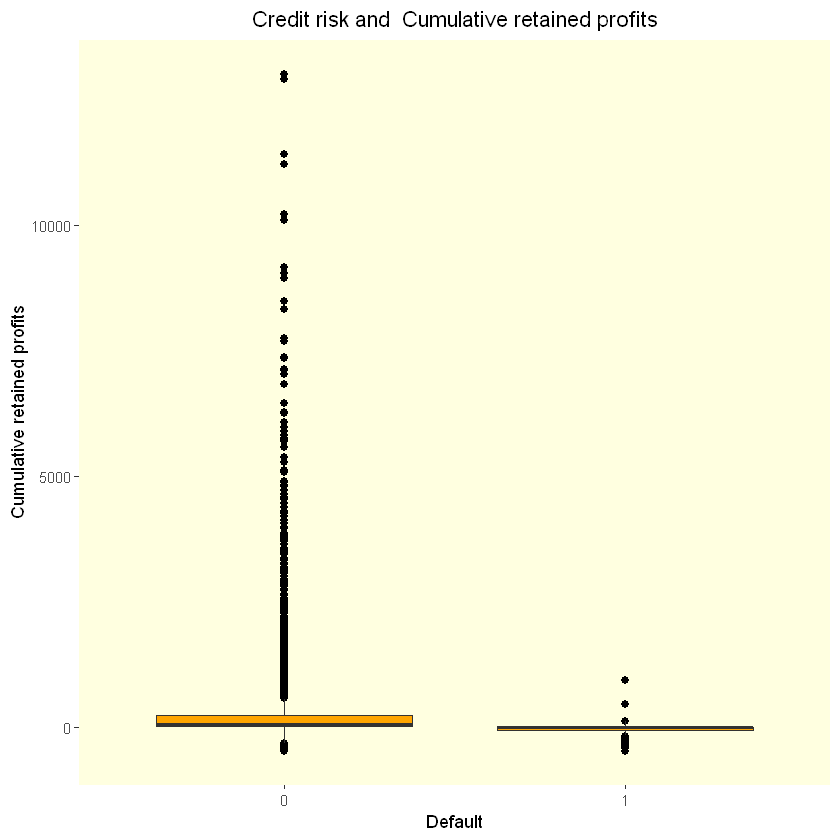

In [41]:
# Cumulative retained profits #
par(bg="light blue")
cat(green$bold("The column is \"Cumulative retained profits\""))
outlierpercentage(company1, `Cumulative retained profits`)
cat("summary before treatment")
summary(company1$`Cumulative retained profits`)
company1$`Cumulative retained profits`<-replace_median(company1,`Cumulative retained profits`)
company1$`Cumulative retained profits`<-treat_outliers(company1,`Cumulative retained profits`)
cat("summary after treatment")
summary(company1$`Cumulative retained profits`)
histogram(company1,`Cumulative retained profits`,TRUE,"Cumulative retained profits")
graphs(company1,`Cumulative retained profits`,TRUE,"Cumulative retained profits")

The column is "Net working capital"Outliers identified:  672  from  3509  observations 
Proportion (%) of outliers:  19.151 
Number of NA's:  32 
NA percentage is: 0.904 
Mean of the outliers:  610.845684523809 
Mean without removing outliers:  138.569 
Mean if we remove outliers:  26.701 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-63839.0     -1.1     16.2    138.6     84.2  85782.8       32 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1695.4    -1.0    16.2   107.7    81.6  3688.2 

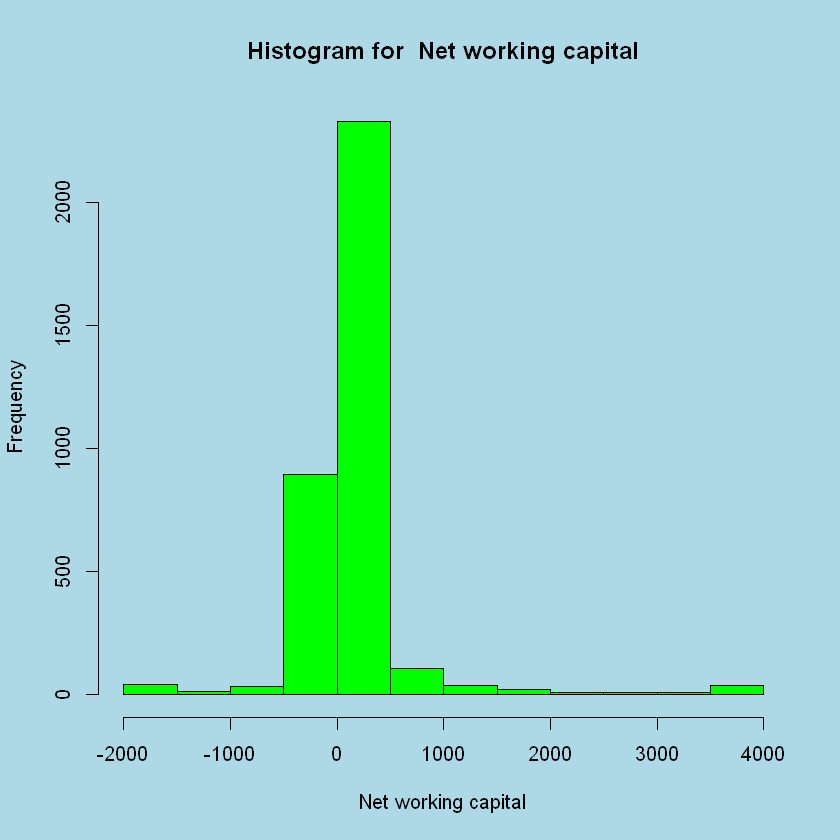

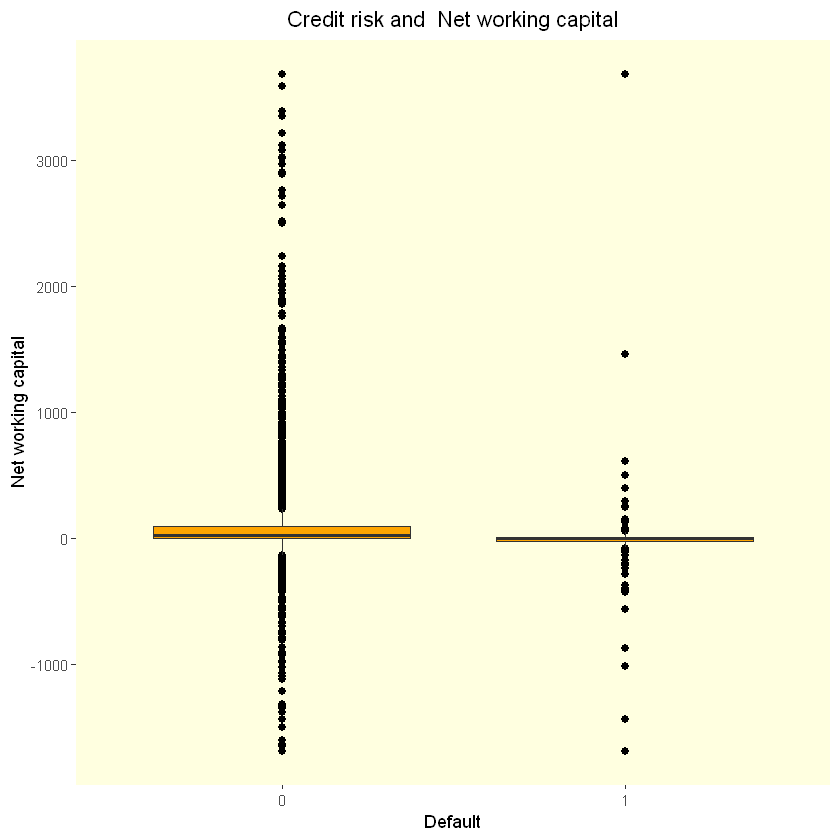

In [42]:
# Net working capital #
par(bg="light blue")
cat(green$bold("The column is \"Net working capital\""))
outlierpercentage(company1, `Net working capital`)
cat("summary before treatment")
summary(company1$`Net working capital`)
company1$`Net working capital`<-replace_median(company1,`Net working capital`)
company1$`Net working capital`<-treat_outliers(company1,`Net working capital`)
cat("summary after treatment")
summary(company1$`Net working capital`)
histogram(company1,`Net working capital`,TRUE,"Net working capital")
graphs(company1,`Net working capital`,TRUE,"Net working capital")

The column is "Total capital"Outliers identified:  444  from  3537  observations 
Proportion (%) of outliers:  12.553 
Number of NA's:  4 
NA percentage is: 0.113 
Mean of the outliers:  1386.45810810811 
Mean without removing outliers:  216.609 
Mean if we remove outliers:  48.677 
summary before treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.1    13.1    42.1   216.6   100.3 78273.2       4 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.5    13.1    42.1   149.8   100.3  2936.7 

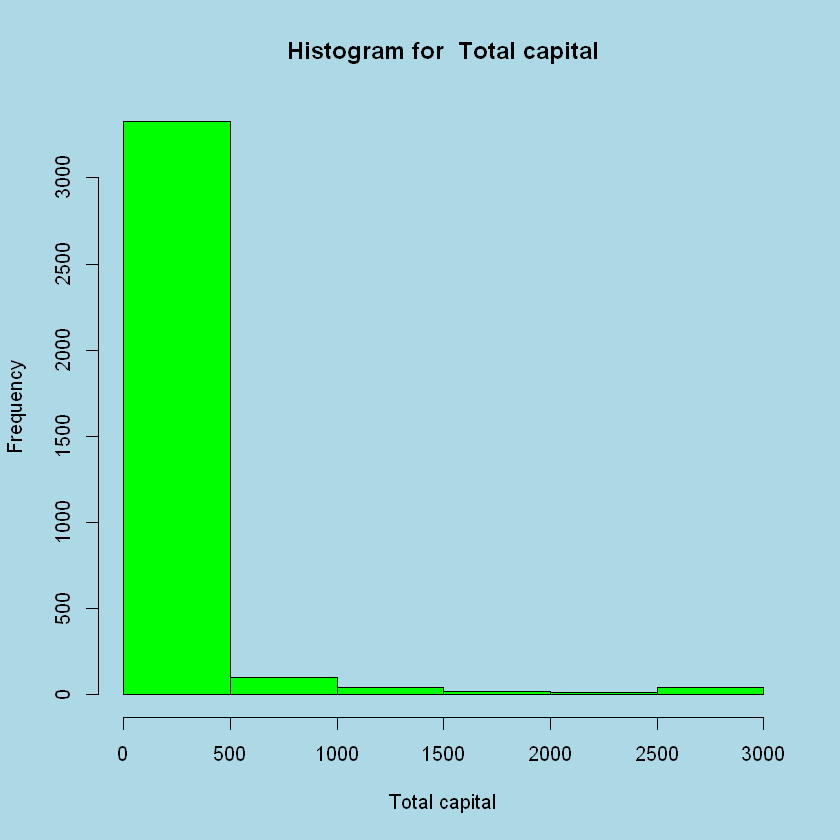

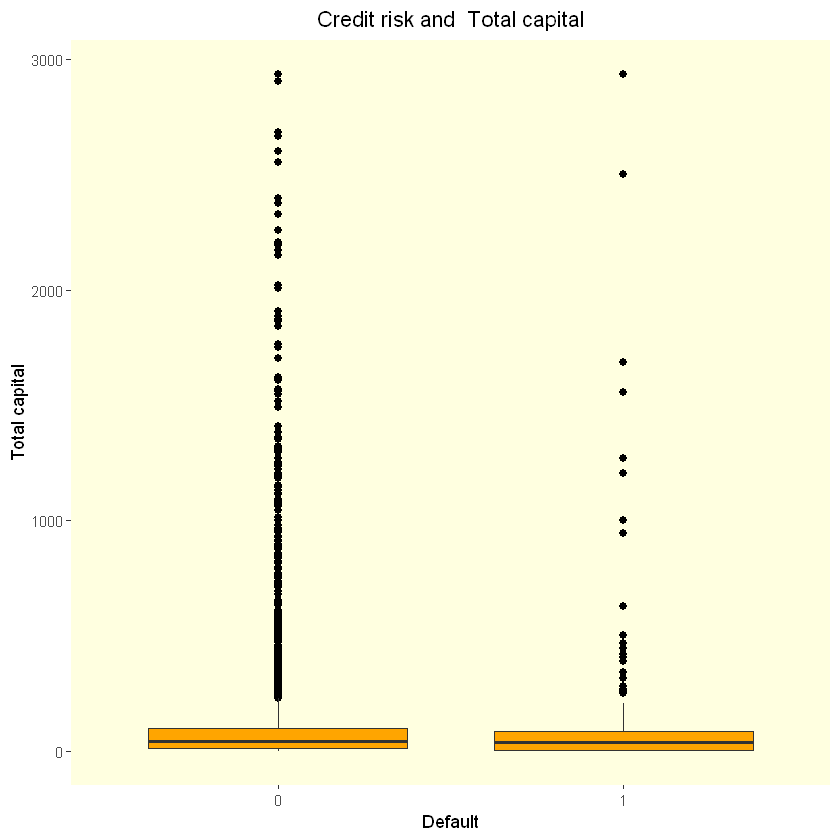

In [43]:
# Total capital #
par(bg="light blue")
cat(green$bold("The column is \"Total capital\""))
outlierpercentage(company1, `Total capital`)
cat("summary before treatment")
summary(company1$`Total capital`)
company1$`Total capital`<-replace_median(company1,`Total capital`)
company1$`Total capital`<-treat_outliers(company1,`Total capital`)
cat("summary after treatment")
summary(company1$`Total capital`)
histogram(company1,`Total capital`,TRUE,"Total capital")
graphs(company1,`Total capital`,TRUE,"Total capital")

The column is "Total assets"Outliers identified:  484  from  3541  observations 
Proportion (%) of outliers:  13.668 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  22276.6648760331 
Mean without removing outliers:  3443.382 
Mean if we remove outliers:  461.6 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      0.1      91.3     309.7    3443.4    1098.7 1176509.2 

summary after treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      0.1      91.3     309.7    3443.4    1098.7 1176509.2 

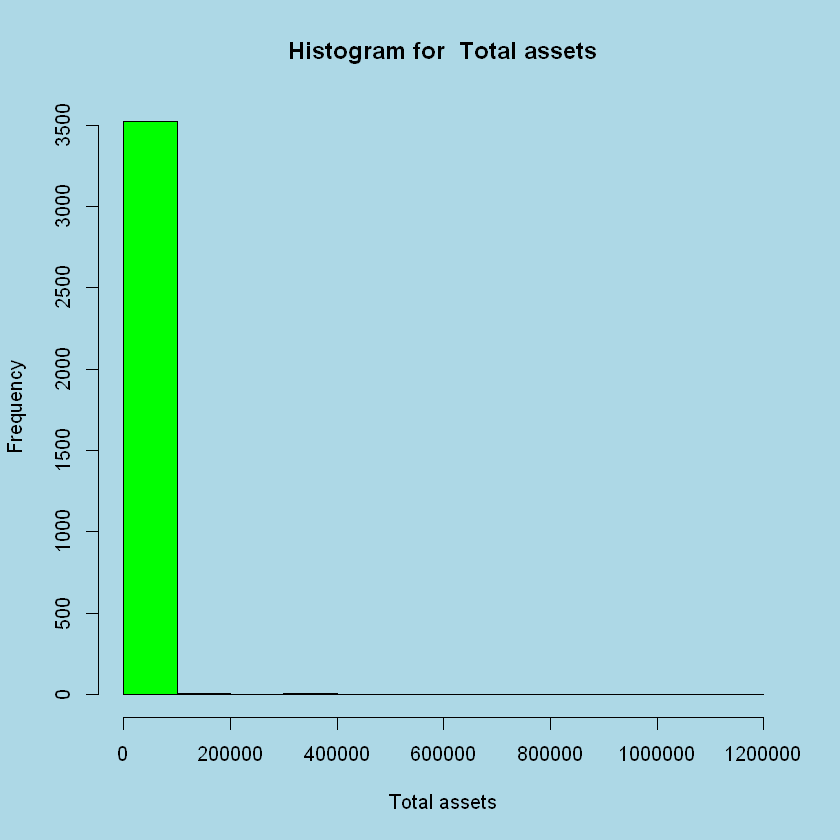

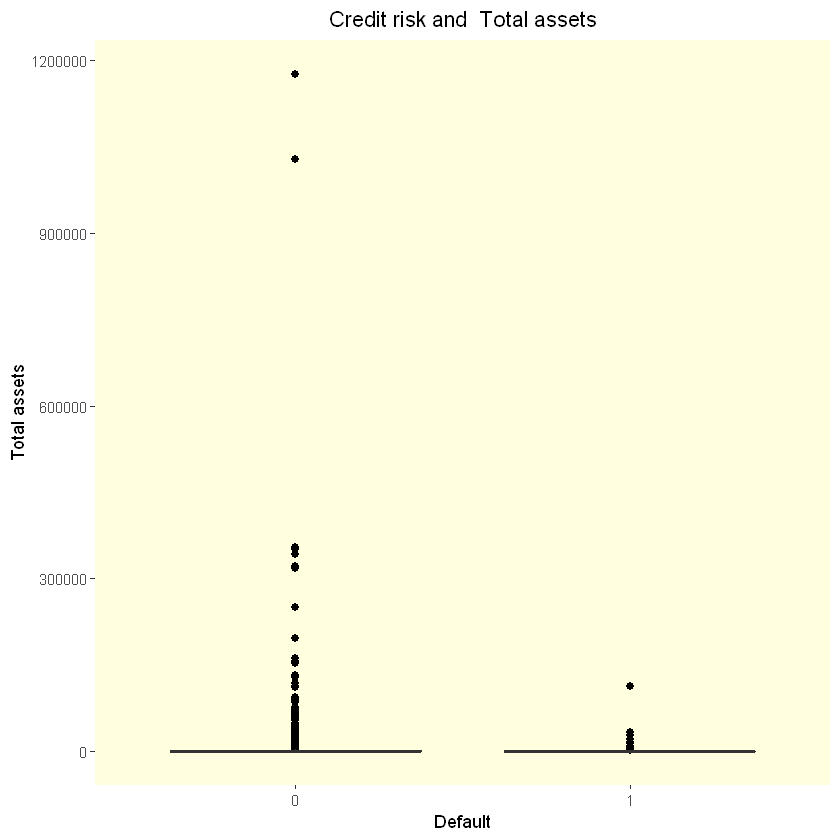

In [44]:
# Total assets #
par(bg="light blue")
cat(green$bold("The column is \"Total assets\""))
outlierpercentage(company1, `Total assets`)
cat("summary before treatment")
summary(company1$`Total assets`)
company1$`Total capital`<-treat_outliers(company1,`Total assets`)
cat("summary after treatment")
summary(company1$`Total assets`)
histogram(company1,`Total assets`,TRUE,"Total assets")
graphs(company1,`Total assets`,TRUE,"Total assets")

The column is "Net worth"Outliers identified:  499  from  3541  observations 
Proportion (%) of outliers:  14.092 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  8261.21923847695 
Mean without removing outliers:  1295.862 
Mean if we remove outliers:  153.287 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0     31.3    102.3   1295.9    377.3 613151.6 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.3    31.3   102.3   754.0   377.3 20920.8 

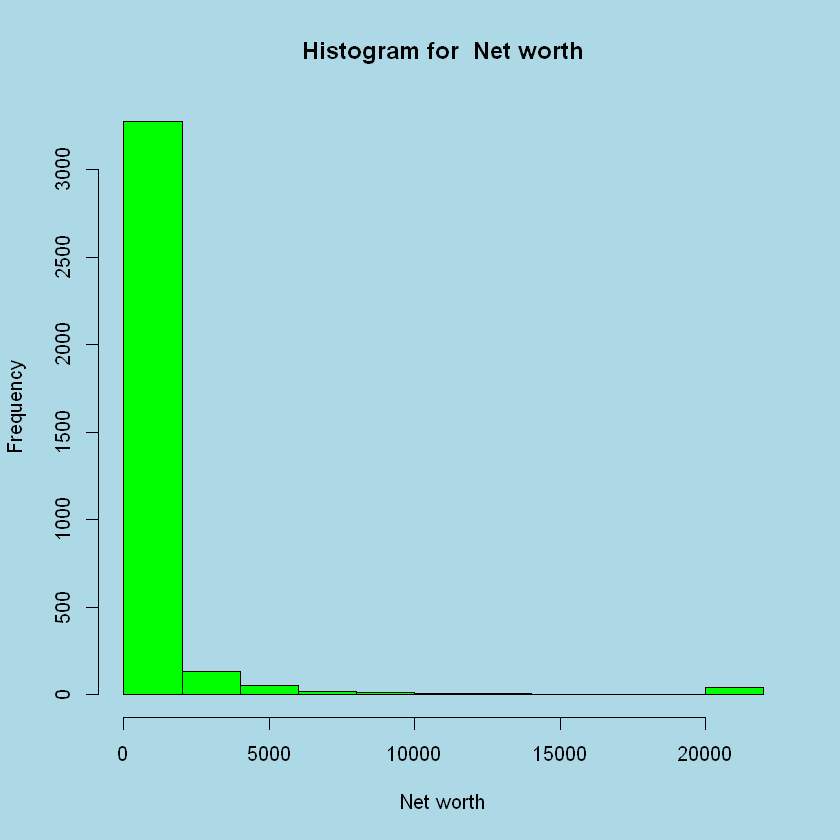

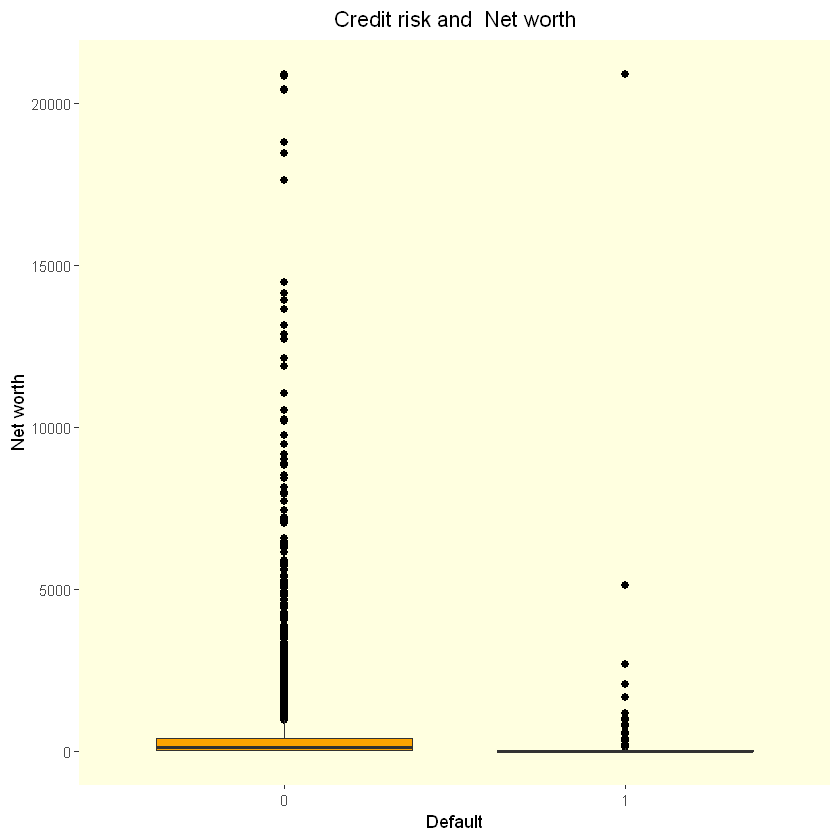

In [45]:
# Net worth #
par(bg="light blue")
cat(green$bold("The column is \"Net worth\""))
outlierpercentage(company1, `Net worth`)
cat("summary before treatment")
summary(company1$`Net worth`)
company1$`Net worth`<-treat_outliers(company1,`Net worth`)
cat("summary after treatment")
summary(company1$`Net worth`)
histogram(company1,`Net worth`,TRUE,"Net worth")
graphs(company1,`Net worth`,TRUE,"Net worth")

The column is "PAT as % of net worth"Outliers identified:  344  from  3541  observations 
Proportion (%) of outliers:  9.715 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  7.38273255813953 
Mean without removing outliers:  10.269 
Mean if we remove outliers:  10.58 
summary before treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-748.72    0.00    7.92   10.27   20.19 2466.67 

summary after treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-138.524    0.000    7.920    8.963   20.190   97.364 

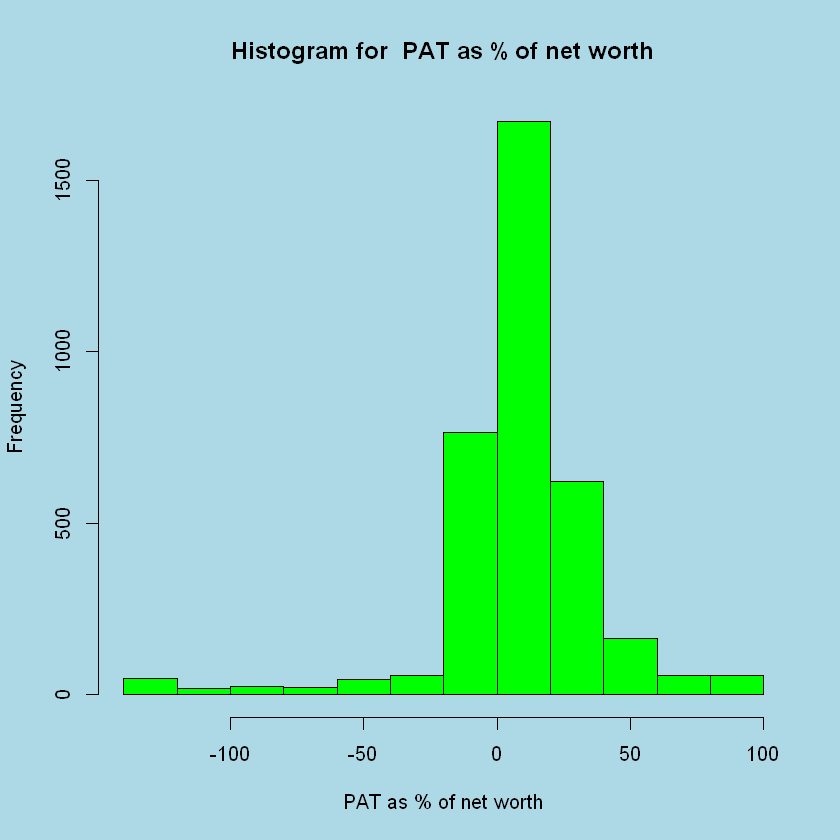

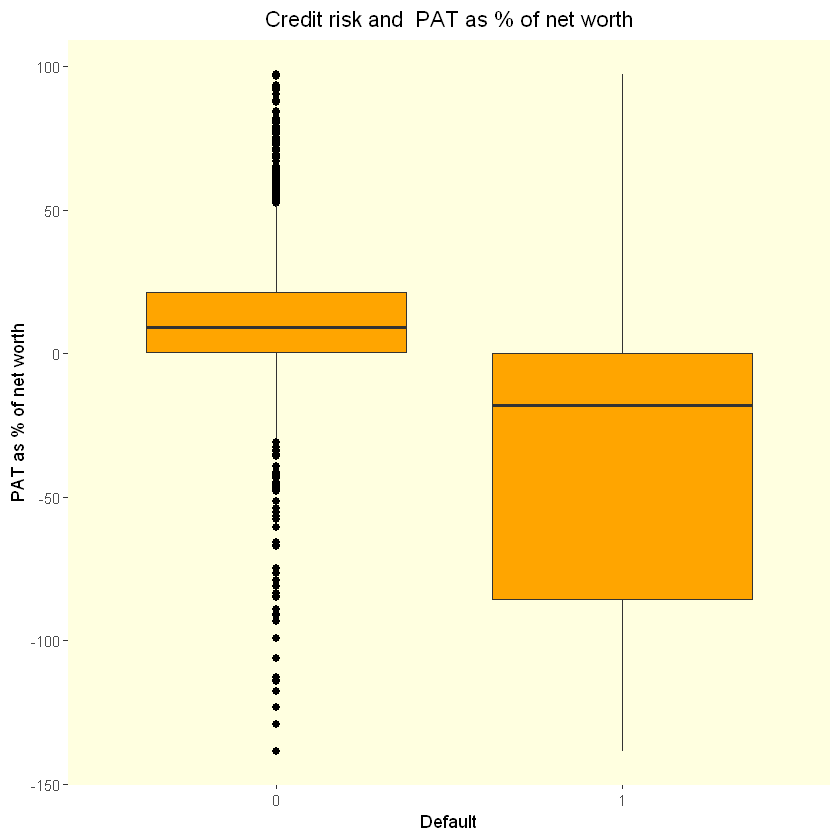

In [46]:
# PAT as % of net worth #
par(bg="light blue")
cat(green$bold("The column is \"PAT as % of net worth\""))
outlierpercentage(company1, `PAT as % of net worth`)
cat("summary before treatment")
summary(company1$`PAT as % of net worth`)
company1$`PAT as % of net worth`<-treat_outliers(company1,`PAT as % of net worth`)
cat("summary after treatment")
summary(company1$`PAT as % of net worth`)
histogram(company1,`PAT as % of net worth`,TRUE,"PAT as % of net worth")
graphs(company1,`PAT as % of net worth`,TRUE,"PAT as % of net worth")

The column is "Shareholders funds"Outliers identified:  495  from  3541  observations 
Proportion (%) of outliers:  13.979 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  8472.15555555556 
Mean without removing outliers:  1322.068 
Mean if we remove outliers:  160.12 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0     32.0    105.6   1322.1    393.2 613151.6 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.3    32.0   105.6   769.5   393.2 20920.8 

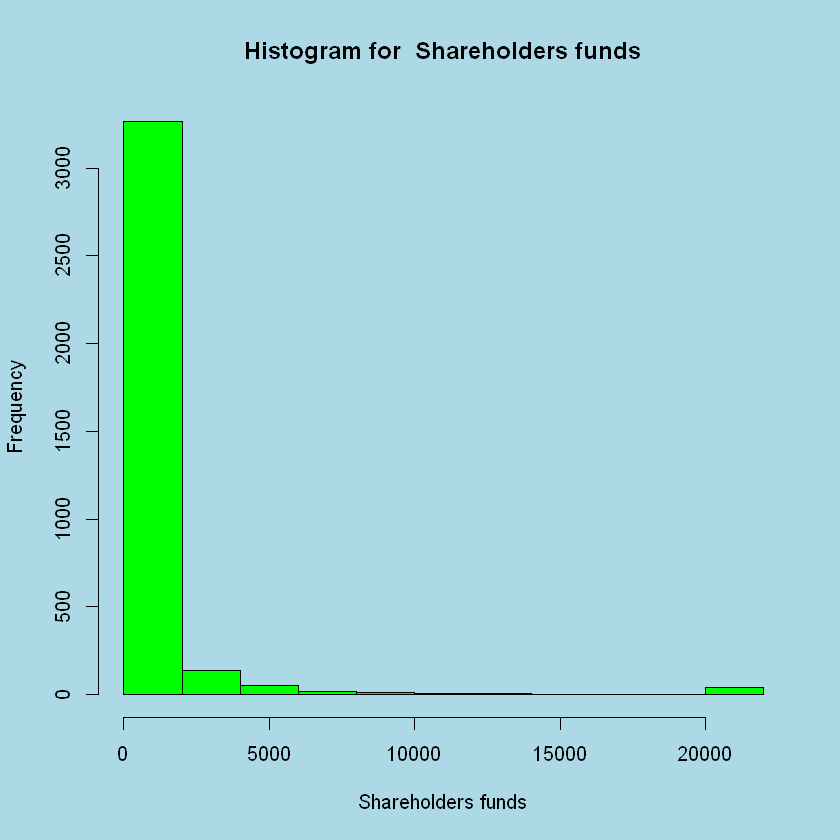

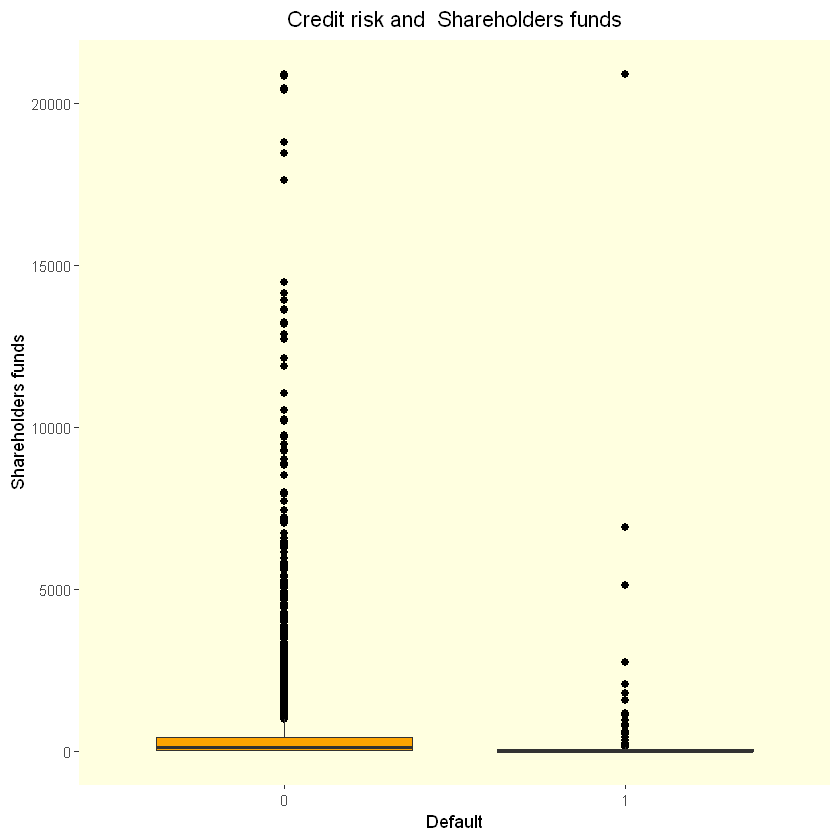

In [47]:
# Shareholders funds #
par(bg="light blue")
cat(green$bold("The column is \"Shareholders funds\""))
outlierpercentage(company1, `Shareholders funds`)
cat("summary before treatment")
summary(company1$`Shareholders funds`)
company1$`Shareholders funds`<-treat_outliers(company1,`Shareholders funds`)
cat("summary after treatment")
summary(company1$`Shareholders funds`)
histogram(company1,`Shareholders funds`,TRUE,"Shareholders funds")
graphs(company1,`Shareholders funds`,TRUE,"Shareholders funds")

The column is "Capital employed"Outliers identified:  477  from  3541  observations 
Proportion (%) of outliers:  13.471 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  15218.0905660377 
Mean without removing outliers:  2328.348 
Mean if we remove outliers:  321.687 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0     60.8    214.7   2328.3    767.3 891408.9 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.1    60.8   214.7  1401.5   767.3 34914.6 

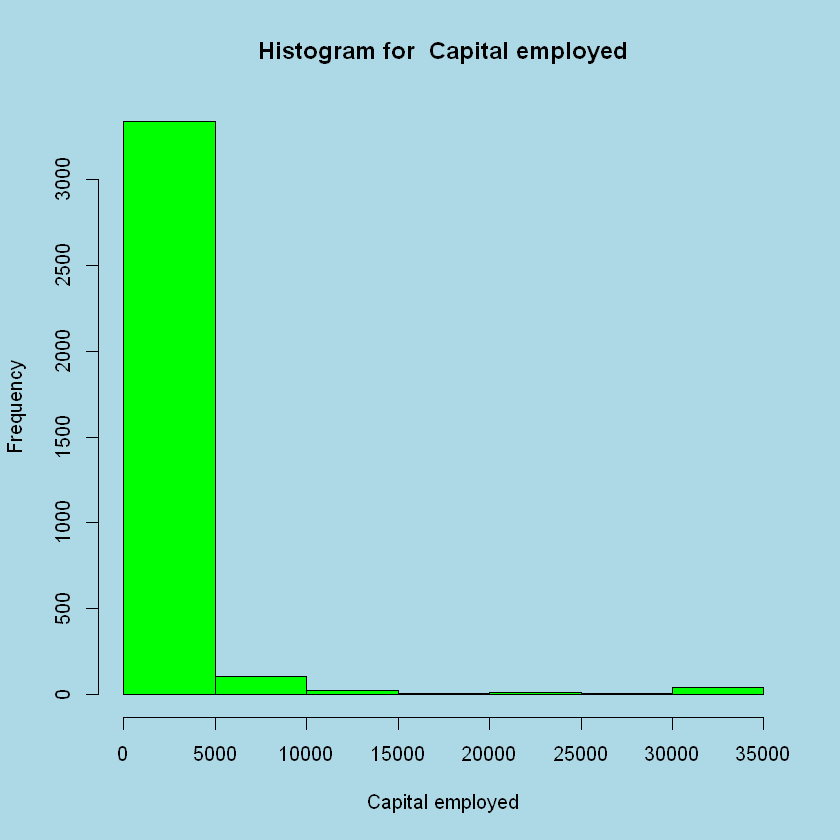

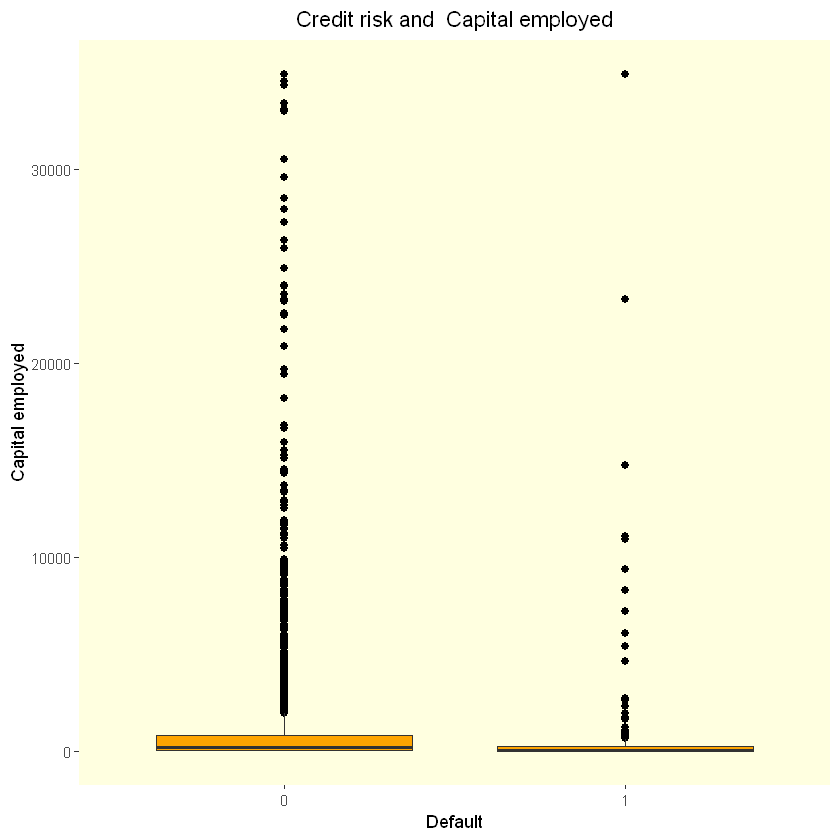

In [48]:
# Capital employed #
par(bg="light blue")
cat(green$bold("The column is \"Capital employed\""))
outlierpercentage(company1, `Capital employed`)
cat("summary before treatment")
summary(company1$`Capital employed`)
company1$`Capital employed`<-treat_outliers(company1,`Capital employed`)
cat("summary after treatment")
summary(company1$`Capital employed`)
histogram(company1,`Capital employed`,TRUE,"Capital employed")
graphs(company1,`Capital employed`,TRUE,"Capital employed")

The column is "TOL/TNW"Outliers identified:  335  from  3541  observations 
Proportion (%) of outliers:  9.461 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  26.9166268656716 
Mean without removing outliers:  3.994 
Mean if we remove outliers:  1.599 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-350.480    0.600    1.430    3.994    2.830  473.000 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.600   1.430   3.213   2.830  55.958 

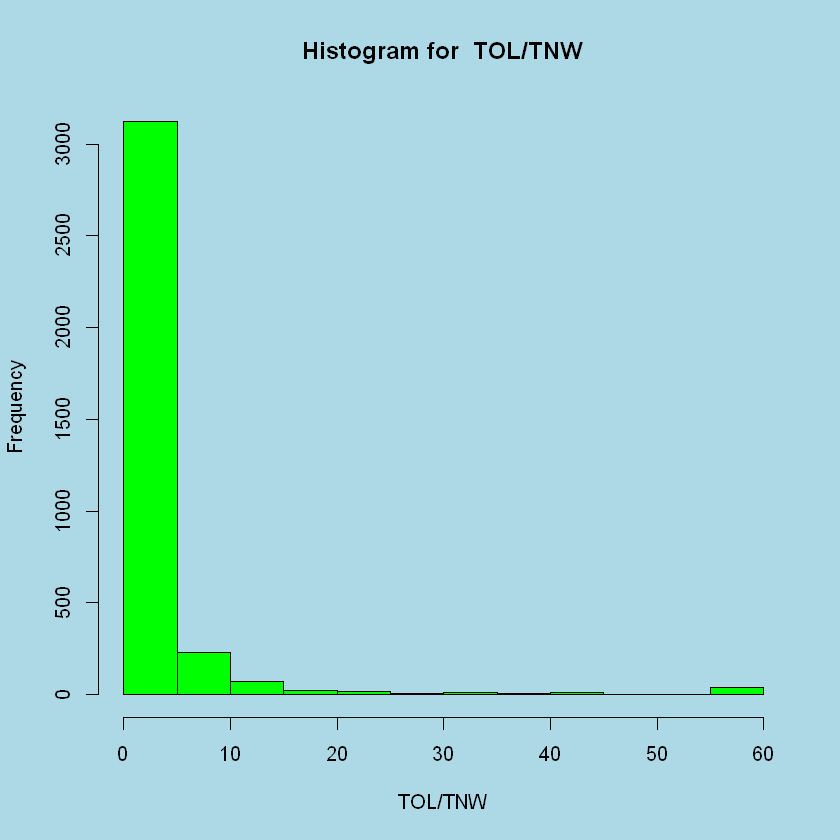

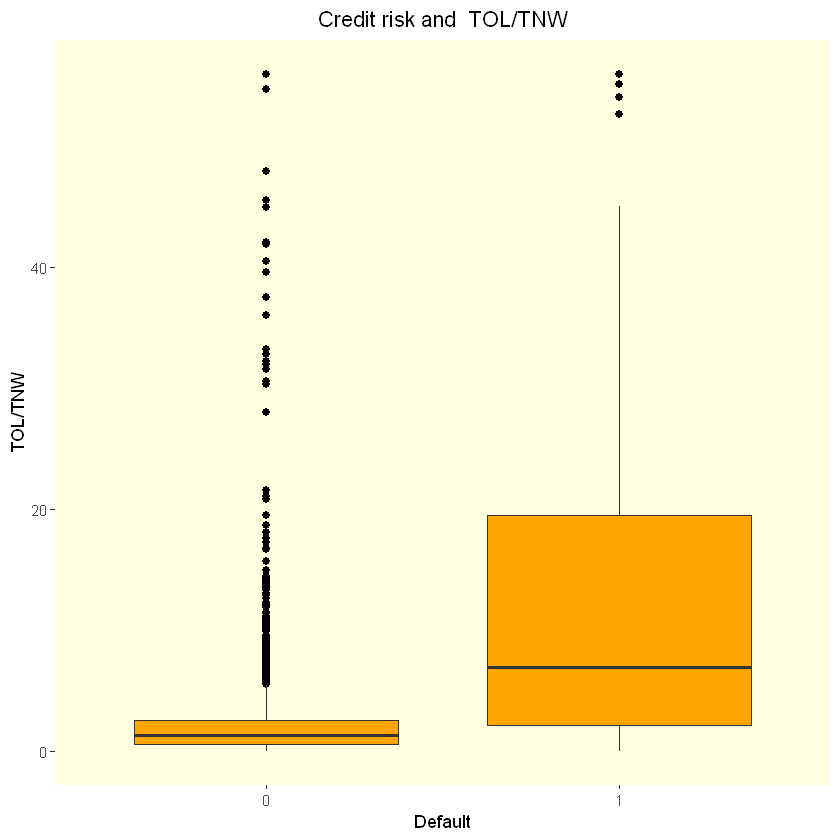

In [49]:
# TOL/TNW #
par(bg="light blue")
cat(green$bold("The column is \"TOL/TNW\""))
outlierpercentage(company1, `TOL/TNW`)
cat("summary before treatment")
summary(company1$`TOL/TNW`)
company1$`TOL/TNW`<-treat_outliers(company1,`TOL/TNW`)
cat("summary after treatment")
summary(company1$`TOL/TNW`)
histogram(company1,`TOL/TNW`,TRUE,"TOL/TNW")
graphs(company1,`TOL/TNW`,TRUE,"TOL/TNW")

The column is "Total term liabilities / tangible net worth"Outliers identified:  328  from  3541  observations 
Proportion (%) of outliers:  9.263 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  15.0866463414634 
Mean without removing outliers:  1.844 
Mean if we remove outliers:  0.492 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-325.600    0.050    0.340    1.844    1.000  456.000 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.050   0.340   1.243   1.000  29.464 

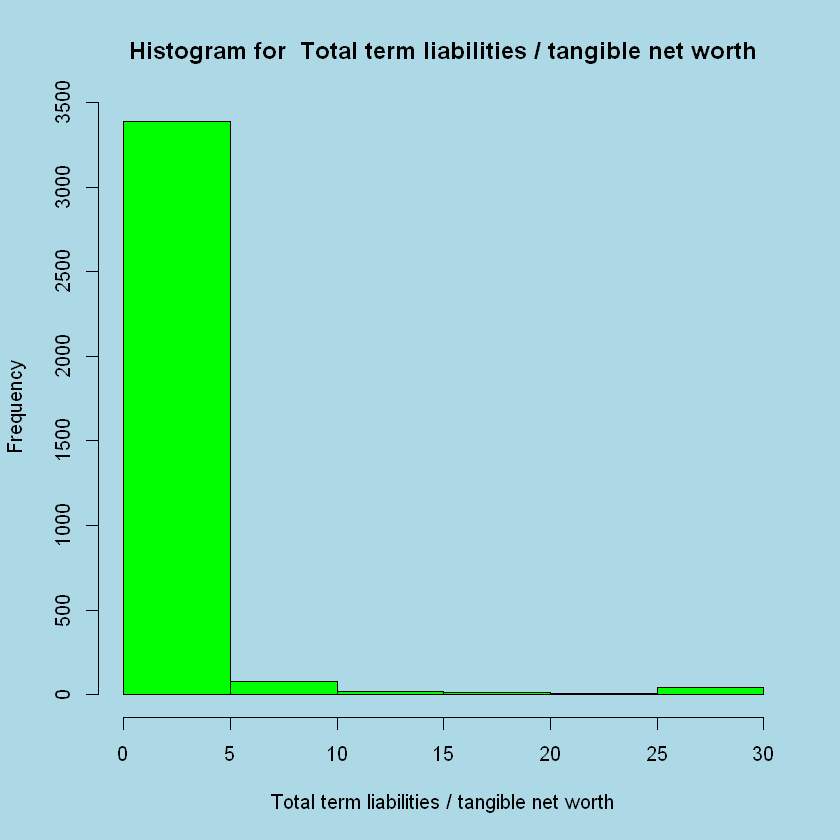

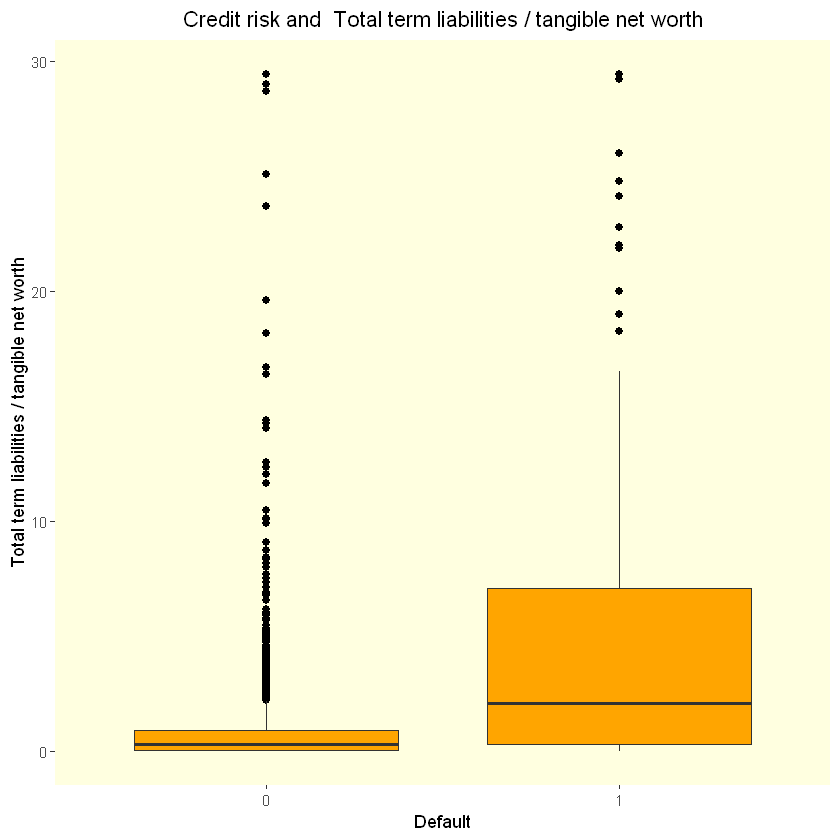

In [50]:
# Total term liabilities / tangible net worth #
par(bg="light blue")
cat(green$bold("The column is \"Total term liabilities / tangible net worth\""))
outlierpercentage(company1, `Total term liabilities / tangible net worth`)
cat("summary before treatment")
summary(company1$`Total term liabilities / tangible net worth`)
company1$`Total term liabilities / tangible net worth`<-treat_outliers(company1,`Total term liabilities / tangible net worth`)
cat("summary after treatment")
summary(company1$`Total term liabilities / tangible net worth`)
histogram(company1,`Total term liabilities / tangible net worth`,TRUE,"Total term liabilities / tangible net worth")
graphs(company1,`Total term liabilities / tangible net worth`,TRUE,"Total term liabilities / tangible net worth")

The column is "Contingent liabilities / Net worth (%)"Outliers identified:  391  from  3541  observations 
Proportion (%) of outliers:  11.042 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  387.088695652174 
Mean without removing outliers:  53.938 
Mean if we remove outliers:  12.585 
summary before treatment

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00     5.33    53.94    30.76 14704.27 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    5.33   36.06   30.76  773.79 

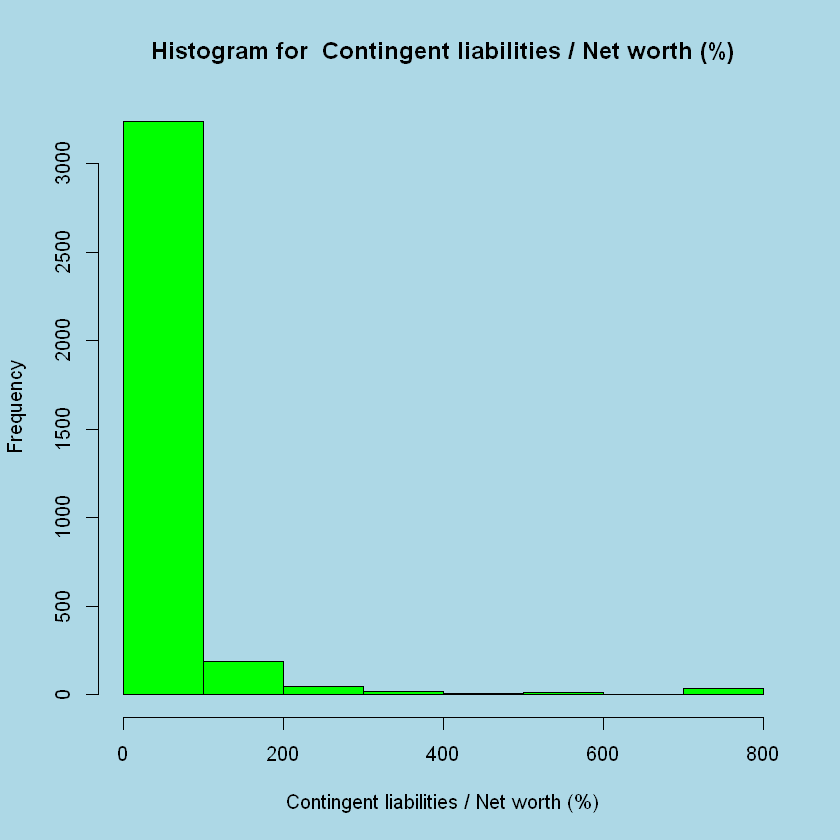

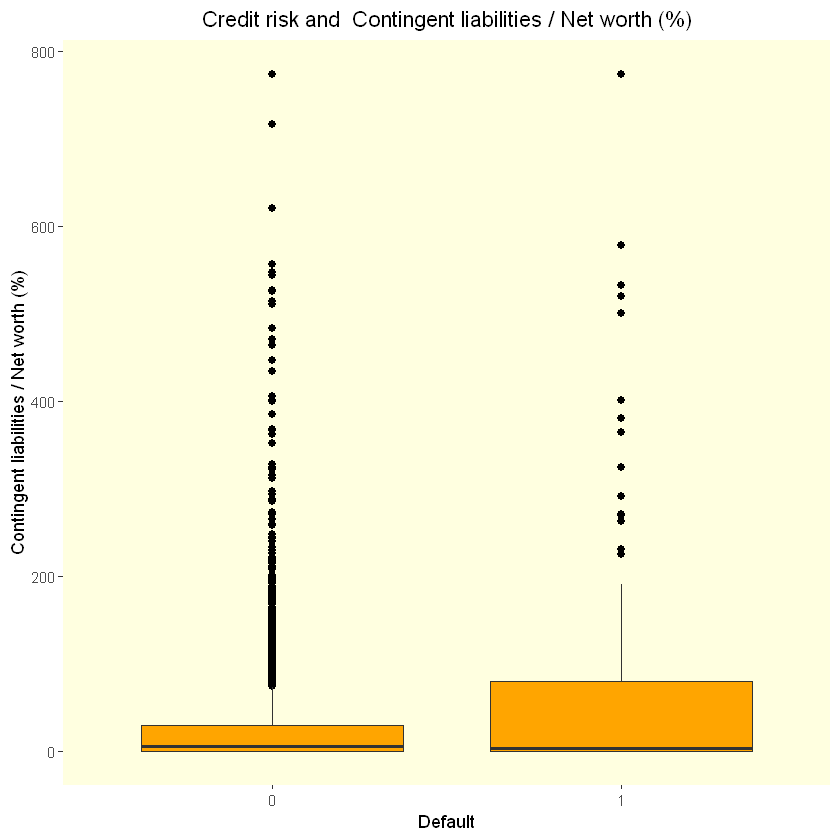

In [51]:
# Contingent liabilities / Net worth (%) #
par(bg="light blue")
cat(green$bold("The column is \"Contingent liabilities / Net worth (%)\""))
outlierpercentage(company1, `Contingent liabilities / Net worth (%)`)
cat("summary before treatment")
summary(company1$`Contingent liabilities / Net worth (%)`)
company1$`Contingent liabilities / Net worth (%)`<-treat_outliers(company1,`Contingent liabilities / Net worth (%)`)
cat("summary after treatment")
summary(company1$`Contingent liabilities / Net worth (%)`)
histogram(company1,`Contingent liabilities / Net worth (%)`,TRUE,"Contingent liabilities / Net worth (%)")
graphs(company1,`Contingent liabilities / Net worth (%)`,TRUE,"Contingent liabilities / Net worth (%)")

The column is "Debt to equity ratio (times)"Outliers identified:  310  from  3541  observations 
Proportion (%) of outliers:  8.755 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  22.0471935483871 
Mean without removing outliers:  2.78 
Mean if we remove outliers:  0.931 
summary before treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.22    0.79    2.78    1.75  456.00 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.220   0.790   1.954   1.750  37.104 

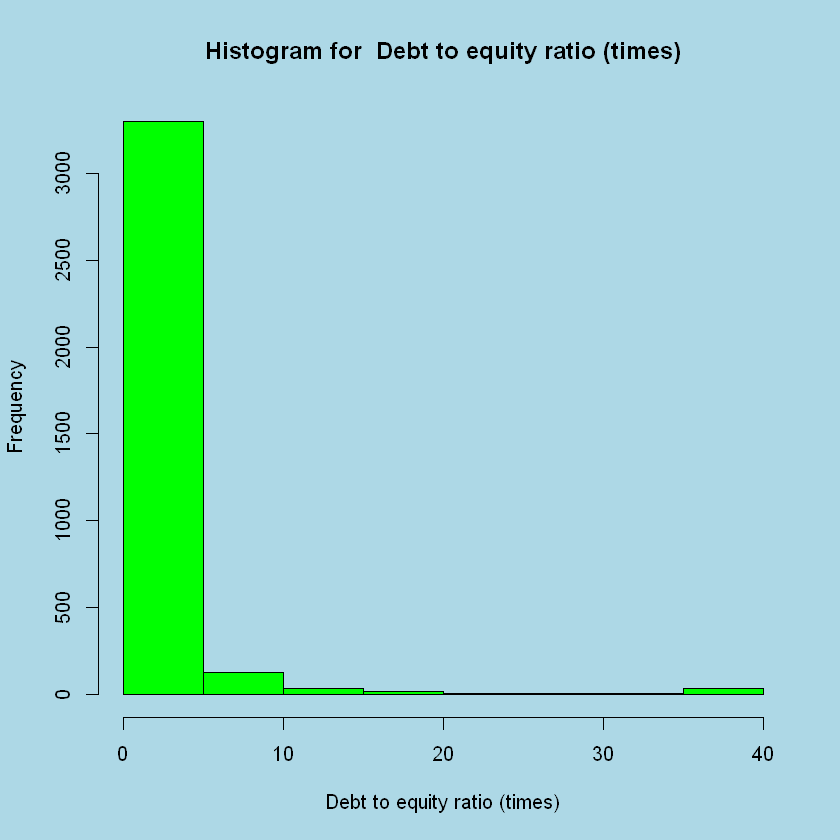

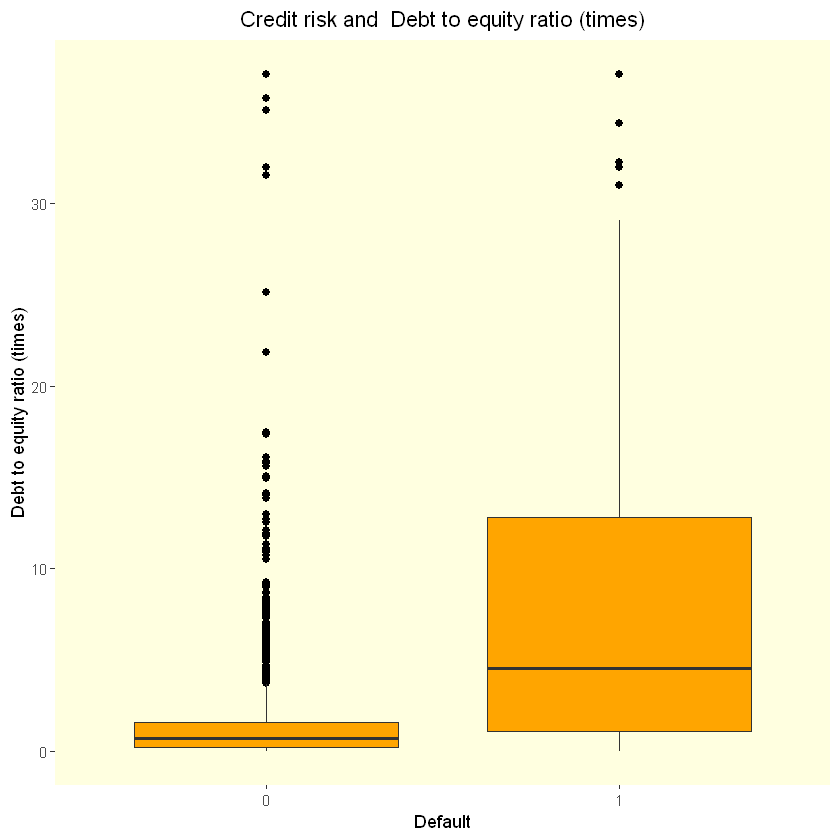

In [52]:
# Debt to equity ratio (times) #
par(bg="light blue")
cat(green$bold("The column is \"Debt to equity ratio (times)\""))
outlierpercentage(company1, `Debt to equity ratio (times)`)
cat("summary before treatment")
summary(company1$`Debt to equity ratio (times)`)
company1$`Debt to equity ratio (times)`<-treat_outliers(company1,`Debt to equity ratio (times)`)
cat("summary after treatment")
summary(company1$`Debt to equity ratio (times)`)
histogram(company1,`Debt to equity ratio (times)`,TRUE,"Debt to equity ratio (times)")
graphs(company1,`Debt to equity ratio (times)`,TRUE,"Debt to equity ratio (times)")


The column is "EPS"Outliers identified:  540  from  3541  observations 
Proportion (%) of outliers:  15.25 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  -1461.85388888889 
Mean without removing outliers:  -220.316 
Mean if we remove outliers:  3.086 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-843181.8       0.0       1.4    -220.3       9.6   34522.5 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -60.32    0.00    1.43   25.91    9.62  896.14 

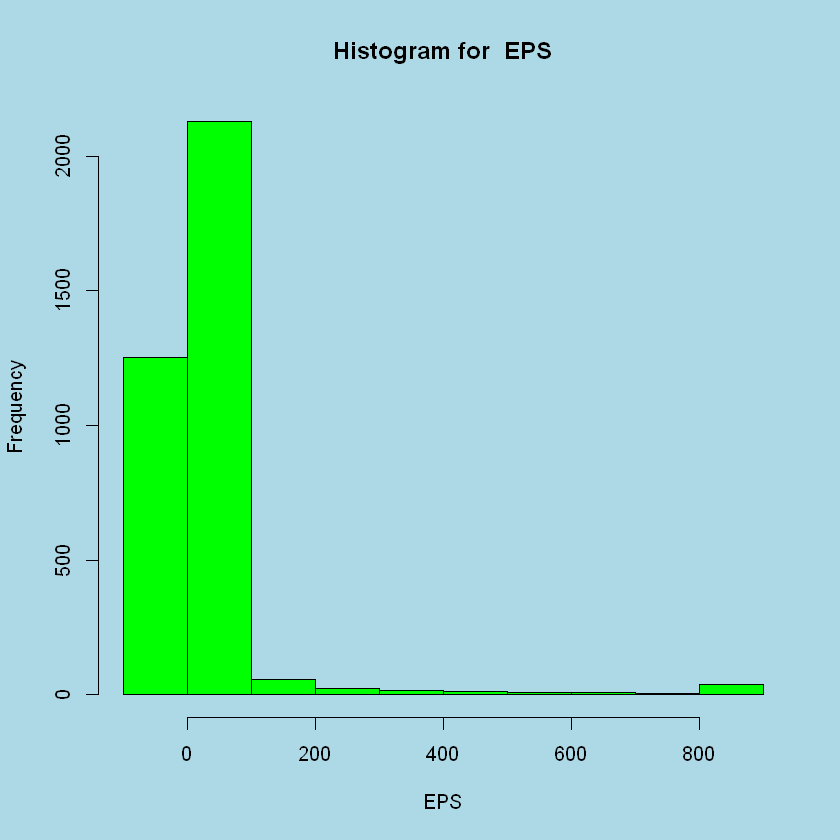

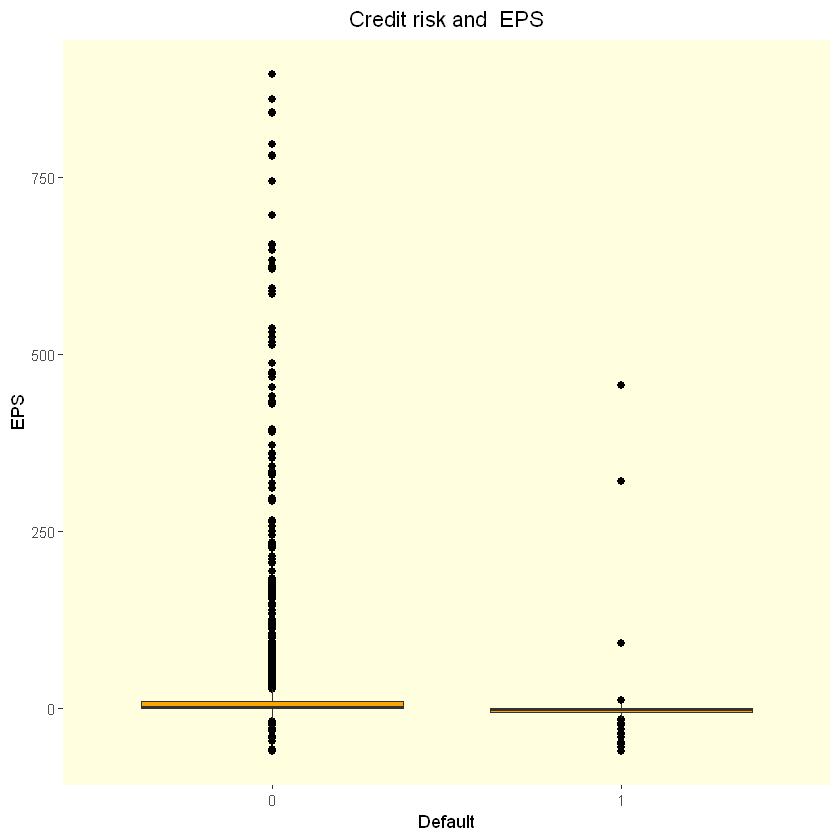

In [53]:
# EPS #
par(bg="light blue")
cat(green$bold("The column is \"EPS\""))
outlierpercentage(company1, EPS)
cat("summary before treatment")
summary(company1$EPS)
company1$EPS<-treat_outliers(company1,EPS)
cat("summary after treatment")
summary(company1$EPS)
histogram(company1,EPS,TRUE,"EPS")
graphs(company1,EPS,TRUE,"EPS")

The column is "Adjusted EPS"Outliers identified:  582  from  3541  observations 
Proportion (%) of outliers:  16.436 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  -1359.55128865979 
Mean without removing outliers:  -221.512 
Mean if we remove outliers:  2.326 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-843181.8       0.0       1.2    -221.5       7.5   34522.5 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -60.32    0.00    1.18   24.74    7.48  896.14 

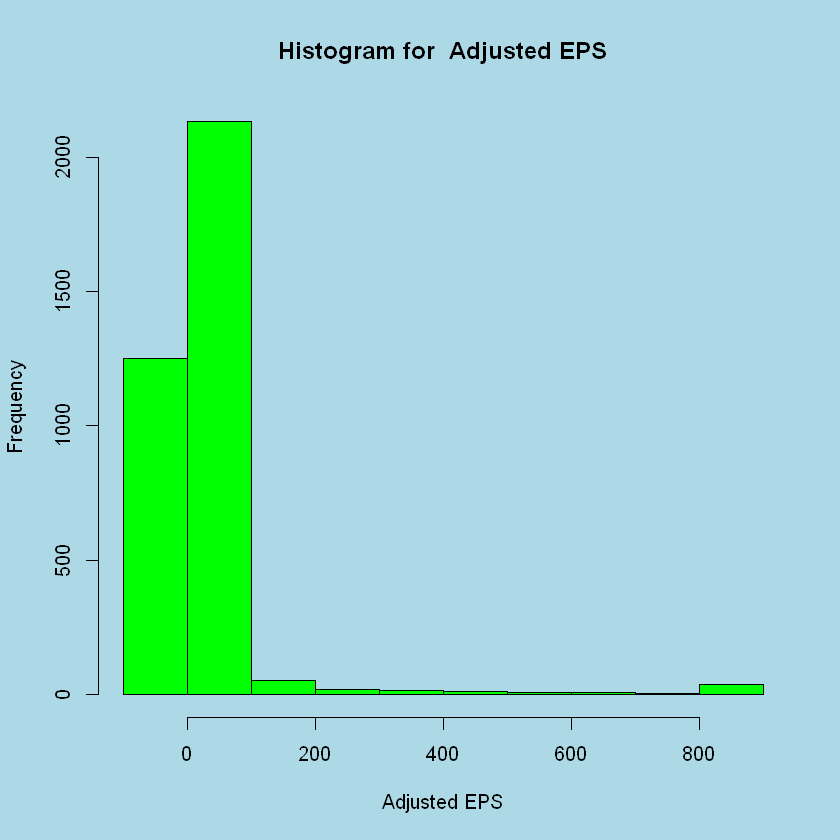

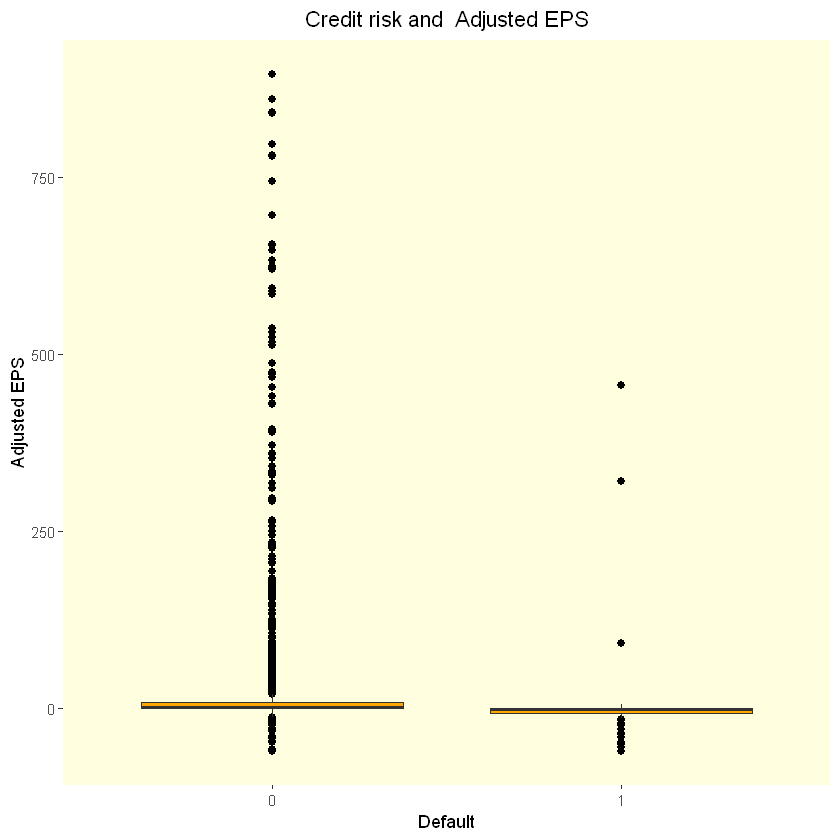

In [54]:
# Adjusted EPS #
par(bg="light blue")
cat(green$bold("The column is \"Adjusted EPS\""))
outlierpercentage(company1, `Adjusted EPS`)
cat("summary before treatment")
summary(company1$`Adjusted EPS`)
company1$`Adjusted EPS`<-treat_outliers(company1,`Adjusted EPS`)
cat("summary after treatment")
summary(company1$`Adjusted EPS`)
histogram(company1,`Adjusted EPS`,TRUE,"Adjusted EPS")
graphs(company1,`Adjusted EPS`,TRUE,"Adjusted EPS")

The column is "Total liabilities"Outliers identified:  484  from  3541  observations 
Proportion (%) of outliers:  13.668 
Number of NA's:  0 
NA percentage is: 0 
Mean of the outliers:  22276.6648760331 
Mean without removing outliers:  3443.382 
Mean if we remove outliers:  461.6 
summary before treatment

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      0.1      91.3     309.7    3443.4    1098.7 1176509.2 

summary after treatment

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.7    91.3   309.7  2051.0  1098.7 51658.8 

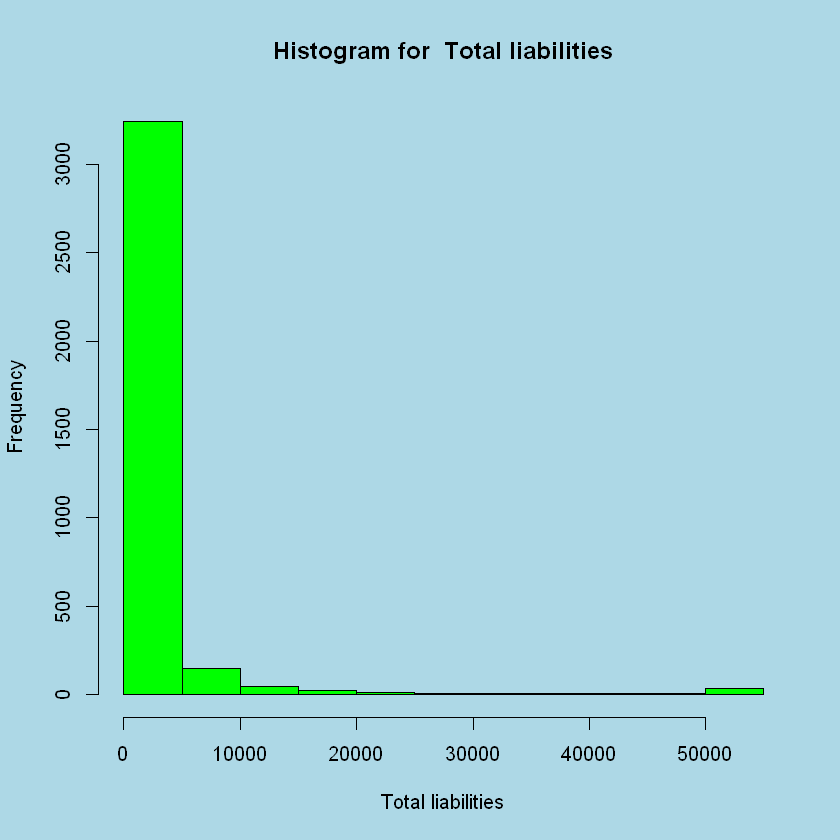

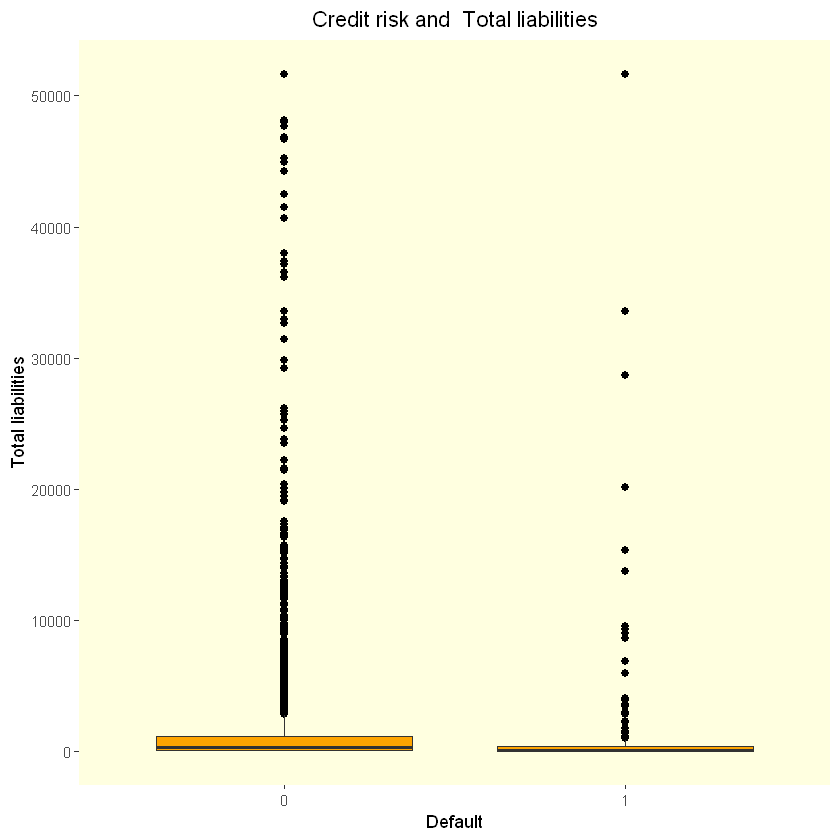

In [55]:
# Total liabilities #
par(bg="light blue")
cat(green$bold("The column is \"Total liabilities\""))
outlierpercentage(company1, `Total liabilities`)
cat("summary before treatment")
summary(company1$`Total liabilities`)
company1$`Total liabilities`<-treat_outliers(company1,`Total liabilities`)
cat("summary after treatment")
summary(company1$`Total liabilities`)
histogram(company1,`Total liabilities`,TRUE,"Total liabilities")
graphs(company1,`Total liabilities`,TRUE,"Total liabilities")

In [56]:
#removing the last two columns which are duplicate columns

names(company1)
company1 <- company1[,-c(46,47)]

[1] "Total assets"                               
 [2] "Net worth"                                  
 [3] "Total income"                               
 [4] "Change in stock"                            
 [5] "Total expenses"                             
 [6] "Profit after tax"                           
 [7] "PBDITA"                                     
 [8] "PBT"                                        
 [9] "Cash profit"                                
[10] "PBDITA as % of total income"                
[11] "PBT as % of total income"                   
[12] "PAT as % of total income"                   
[13] "Cash profit as % of total income"           
[14] "PAT as % of net worth"                      
[15] "Sales"                                      
[16] "Income from financial services"             
[17] "Total capital"                              
[18] "Reserves and funds"                         
[19] "Borrowings"                                 
[20] "Current liabilities & provisions"           
[21] "Shareholders funds"                         
[22] "Cumulative retained profits"                
[23] "Capital employed"                           
[24] "TOL/TNW"                                    
[25] "Total term liabilities / tangible net worth"
[26] "Contingent liabilities / Net worth (%)"     
[27] "Net fixed assets"                           
[28] "Current assets"                             
[29] "Net working capital"                        
[30] "Quick ratio (times)"                        
[31] "Current ratio (times)"                      
[32] "Debt to equity ratio (times)"               
[33] "Cash to current liabilities (times)"        
[34] "Cash to average cost of sales per day"      
[35] "Creditors turnover"                         
[36] "Debtors turnover"                           
[37] "Finished goods turnover"                    
[38] "WIP turnover"                               
[39] "Raw material turnover"                      
[40] "Shares outstanding"                         
[41] "Equity face value"                          
[42] "EPS"                                        
[43] "Adjusted EPS"                               
[44] "Total liabilities"                          
[45] "Default"                                    
[46] "Profit.after.tax"                           
[47] "Cash.profit"

In [57]:
#Correlation plot

cordata<- subset(company1, select = -c(Default))
vals=cor(cordata)
pdf("correlation_matrix.pdf",width = 10, height = 10)
corrplot(vals, method="circle")
dev.off()

png 
  2

In [59]:
#replacing the zeroes in the blank values of validation dataset

sapply(validation1, function(x){sum(is.na(x))})
validation1[is.na(validation1)]=0  #replace the zeroes in validation dataset
any(is.na(validation1)) #re-checking for null values

Default 
                                          0 
                               Total assets 
                                          0 
                                  Net worth 
                                          0 
                               Total income 
                                         33 
                            Change in stock 
                                         92 
                             Total expenses 
                                         26 
                           Profit after tax 
                                         23 
                                     PBDITA 
                                         23 
                                        PBT 
                                         23 
                                Cash profit 
                                         23 
                PBDITA as % of total income 
                                         11 
                   PBT as % of total income 
                                         11 
                   PAT as % of total income 
                                         11 
           Cash profit as % of total income 
                                         11 
                      PAT as % of net worth 
                                          0 
                                      Sales 
                                         46 
             Income from financial services 
                                        176 
                              Total capital 
                                          1 
                         Reserves and funds 
                                         13 
                                 Borrowings 
                                         65 
           Current liabilities & provisions 
                                         14 
                         Shareholders funds 
                                          0 
                Cumulative retained profits 
                                          7 
                           Capital employed 
                                          0 
                                    TOL/TNW 
                                          0 
Total term liabilities / tangible net worth 
                                          0 
     Contingent liabilities / Net worth (%) 
                                          0 
                           Net fixed assets 
                                         14 
                             Current assets 
                                         14 
                        Net working capital 
                                          5 
                        Quick ratio (times) 
                                         12 
                      Current ratio (times) 
                                         12 
               Debt to equity ratio (times) 
                                          0 
        Cash to current liabilities (times) 
                                         12 
      Cash to average cost of sales per day 
                                         15 
                         Creditors turnover 
                                         58 
                           Debtors turnover 
                                         57 
                    Finished goods turnover 
                                        134 
                               WIP turnover 
                                        124 
                      Raw material turnover 
                                         67 
                         Shares outstanding 
                                        118 
                          Equity face value 
                                        118 
                                        EPS 
                                          0 
                               Adjusted EPS 
                                          0 
                          Total liabilities 
                               

[1] FALSE

In [60]:
############LOGISTIC REGRESSION modelling################

#Model with all the columns

lg_model1 <- glm(Default~., data = company1, family = binomial())
summary(lg_model1)
vif(lg_model1)

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ ., family = binomial(), data = company1)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -8.49    0.00    0.00    0.00    8.49  

Coefficients: (1 not defined because of singularities)
                                                Estimate Std. Error    z value
(Intercept)                                   -4.330e+14  2.529e+06 -171183780
`Total assets`                                 5.474e+09  1.588e+02   34475303
`Net worth`                                    1.187e+11  8.925e+03   13297353
`Total income`                                 1.679e+11  9.225e+03   18200867
`Change in stock`                             -6.497e+09  1.645e+04    -395055
`Total expenses`                               5.351e+10  5.684e+03    9414768
`Profit after tax`                             4.136e+10  3.826e+03   10808249
PBDITA                                        -3.190e+11  9.155e+03  -34844369
PBT                                           -9.458e+09 

ERROR: Error in vif(lg_model1): could not find function "vif"


In [61]:
#Removing the "Total liabilities" column

lg_model2 <- glm(Default~. -`Total liabilities`, data = company1, family = binomial())
summary(lg_model2)
vif(lg_model2)

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ . - `Total liabilities`, family = binomial(), 
    data = company1)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -8.49    0.00    0.00    0.00    8.49  

Coefficients:
                                                Estimate Std. Error    z value
(Intercept)                                   -4.330e+14  2.529e+06 -171183780
`Total assets`                                 5.474e+09  1.588e+02   34475303
`Net worth`                                    1.187e+11  8.925e+03   13297353
`Total income`                                 1.679e+11  9.225e+03   18200867
`Change in stock`                             -6.497e+09  1.645e+04    -395055
`Total expenses`                               5.351e+10  5.684e+03    9414768
`Profit after tax`                             4.136e+10  3.826e+03   10808249
PBDITA                                        -3.190e+11  9.155e+03  -34844369
PBT                                           -9.458e+09  9.835e+03    

ERROR: Error in vif(lg_model2): could not find function "vif"


In [62]:
#Removing the Total income column

lg_model3 <- glm(Default~. -`Total liabilities` -`Total income`, data = company1, family = binomial())
summary(lg_model3)
vif(lg_model3)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ . - `Total liabilities` - `Total income`, 
    family = binomial(), data = company1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1455  -0.2977  -0.1906  -0.0527   3.9380  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                   -2.486e+00  1.952e-01 -12.735
`Total assets`                                 3.190e-04  1.672e-04   1.907
`Net worth`                                    5.437e-04  1.936e-03   0.281
`Change in stock`                              3.795e-04  2.931e-03   0.129
`Total expenses`                              -4.210e-04  8.023e-04  -0.525
`Profit after tax`                             1.787e-03  3.509e-03   0.509
PBDITA                                        -3.819e-03  2.640e-03  -1.447
PBT                                            2.802e-03  4.011e-03   0.698
`Cash profit`                                 -4.574e-03  2.259e-03  -2

ERROR: Error in vif(lg_model3): could not find function "vif"


In [63]:
#Removing the "Sales" column

lg_model4 <- glm(Default~. -`Total liabilities` -`Total income` -Sales, data = company1, family = binomial())
summary(lg_model4)
vif(lg_model4)

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ . - `Total liabilities` - `Total income` - 
    Sales, family = binomial(), data = company1)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -8.49    0.00    0.00    0.00    8.49  

Coefficients:
                                                Estimate Std. Error    z value
(Intercept)                                   -6.543e+13  2.524e+06  -25924425
`Total assets`                                 3.257e+09  1.585e+02   20545463
`Net worth`                                    8.681e+10  8.900e+03    9754354
`Change in stock`                              1.052e+10  1.533e+04     686148
`Total expenses`                              -8.702e+09  8.276e+02  -10515044
`Profit after tax`                            -2.176e+09  3.775e+03    -576334
PBDITA                                        -6.666e+10  7.930e+03   -8406763
PBT                                           -8.612e+10  8.659e+03   -9946095
`Cash profit`                                 

ERROR: Error in vif(lg_model4): could not find function "vif"


In [64]:
#Removing the "Net worth" column

lg_model5 <- glm(Default~. -`Total liabilities` -`Total income` -Sales -`Net worth`,
                 data = company1, family = binomial())
summary(lg_model5)
vif(lg_model5)

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ . - `Total liabilities` - `Total income` - 
    Sales - `Net worth`, family = binomial(), data = company1)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -8.49    0.00    0.00    0.00    8.49  

Coefficients:
                                                Estimate Std. Error    z value
(Intercept)                                   -1.821e+14  2.523e+06  -72188381
`Total assets`                                 8.850e+08  1.585e+02    5584272
`Change in stock`                             -3.079e+11  1.532e+04  -20103553
`Total expenses`                              -1.137e+10  8.275e+02  -13742770
`Profit after tax`                             4.927e+10  3.773e+03   13060377
PBDITA                                        -7.779e+10  7.872e+03   -9881345
PBT                                           -3.874e+10  8.638e+03   -4485259
`Cash profit`                                 -4.176e+10  3.343e+03  -12491489
`PBDITA as % of total income`   

ERROR: Error in vif(lg_model5): could not find function "vif"


In [65]:
#Removing the "Capital Employed" column

lg_model6 <- glm(Default~. -`Total liabilities` -`Total income` -Sales -`Net worth` -`Capital employed`,
                 data = company1, family = binomial())
summary(lg_model6)
vif(lg_model6)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ . - `Total liabilities` - `Total income` - 
    Sales - `Net worth` - `Capital employed`, family = binomial(), 
    data = company1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1790  -0.3005  -0.1951  -0.0614   3.8759  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                   -2.452e+00  1.907e-01 -12.859
`Total assets`                                 3.341e-04  1.046e-04   3.193
`Change in stock`                             -5.964e-04  2.669e-03  -0.223
`Total expenses`                              -7.073e-05  1.779e-04  -0.398
`Profit after tax`                             2.265e-03  2.539e-03   0.892
PBDITA                                        -1.956e-03  1.757e-03  -1.113
PBT                                            3.862e-04  2.721e-03   0.142
`Cash profit`                                 -3.939e-03  1.900e-03  -2.072
`PBDITA as % of total i

ERROR: Error in vif(lg_model6): could not find function "vif"


In [66]:
#Removing "Profit after tax" column

lg_model7 <- glm(Default~. -`Total liabilities` -`Total income` -Sales -`Net worth` -`Capital employed`
                 -`Profit after tax`, data = company1, family = binomial())
summary(lg_model7)
vif(lg_model7)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ . - `Total liabilities` - `Total income` - 
    Sales - `Net worth` - `Capital employed` - `Profit after tax`, 
    family = binomial(), data = company1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1824  -0.3007  -0.1952  -0.0618   3.8820  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                   -2.439e+00  1.898e-01 -12.853
`Total assets`                                 3.548e-04  1.094e-04   3.243
`Change in stock`                             -9.784e-04  2.532e-03  -0.386
`Total expenses`                              -9.534e-05  1.841e-04  -0.518
PBDITA                                        -1.777e-03  1.779e-03  -0.999
PBT                                            2.412e-03  1.931e-03   1.249
`Cash profit`                                 -3.291e-03  1.773e-03  -1.856
`PBDITA as % of total income`                  9.820e-06  6.162e-03   0.002
`P

ERROR: Error in vif(lg_model7): could not find function "vif"


In [67]:
#Removing "EPS" column

lg_model8 <- glm(Default~. -`Total liabilities` -`Total income` -Sales -`Net worth` -`Capital employed`
                 -`Profit after tax` -EPS, data = company1, family = binomial())
summary(lg_model8)
vif(lg_model8)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ . - `Total liabilities` - `Total income` - 
    Sales - `Net worth` - `Capital employed` - `Profit after tax` - 
    EPS, family = binomial(), data = company1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1823  -0.3007  -0.1952  -0.0619   3.8818  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                   -2.439e+00  1.898e-01 -12.853
`Total assets`                                 3.548e-04  1.094e-04   3.242
`Change in stock`                             -9.804e-04  2.531e-03  -0.387
`Total expenses`                              -9.524e-05  1.841e-04  -0.517
PBDITA                                        -1.776e-03  1.778e-03  -0.999
PBT                                            2.411e-03  1.930e-03   1.249
`Cash profit`                                 -3.292e-03  1.773e-03  -1.856
`PBDITA as % of total income`                  9.397e-06  6.162e-03   0.

ERROR: Error in vif(lg_model8): could not find function "vif"


In [68]:
#Removing "PBT as % of total income" column

lg_model9 <- glm(Default~. -`Total liabilities` -`Total income` -Sales -`Net worth` -`Capital employed`
                 -`Profit after tax` -EPS -`PBT as % of total income`, data = company1, family = binomial())
summary(lg_model9)
vif(lg_model9)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ . - `Total liabilities` - `Total income` - 
    Sales - `Net worth` - `Capital employed` - `Profit after tax` - 
    EPS - `PBT as % of total income`, family = binomial(), data = company1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1839  -0.3007  -0.1952  -0.0616   3.8843  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                   -2.439e+00  1.899e-01 -12.847
`Total assets`                                 3.560e-04  1.094e-04   3.253
`Change in stock`                             -1.005e-03  2.531e-03  -0.397
`Total expenses`                              -9.615e-05  1.845e-04  -0.521
PBDITA                                        -1.760e-03  1.783e-03  -0.987
PBT                                            2.387e-03  1.933e-03   1.235
`Cash profit`                                 -3.305e-03  1.772e-03  -1.865
`PBDITA as % of total income`              

ERROR: Error in vif(lg_model9): could not find function "vif"


In [69]:
#Removing "Total capital" column

lg_model10 <- glm(Default~. -`Total liabilities` -`Total income` -Sales -`Net worth` -`Capital employed`
                  -`Profit after tax` -EPS -`PBT as % of total income` -`Total capital`,
                  data = company1, family = binomial())
summary(lg_model10)
vif(lg_model10)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Default ~ . - `Total liabilities` - `Total income` - 
    Sales - `Net worth` - `Capital employed` - `Profit after tax` - 
    EPS - `PBT as % of total income` - `Total capital`, family = binomial(), 
    data = company1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1808  -0.3018  -0.1951  -0.0629   3.8376  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                   -2.459e+00  1.881e-01 -13.074
`Total assets`                                 3.708e-04  1.110e-04   3.342
`Change in stock`                             -1.266e-03  2.509e-03  -0.504
`Total expenses`                              -1.319e-04  1.780e-04  -0.741
PBDITA                                        -1.248e-03  1.790e-03  -0.697
PBT                                            1.890e-03  1.924e-03   0.982
`Cash profit`                                 -3.314e-03  1.730e-03  -1.916
`PBDITA as % of tota

ERROR: Error in vif(lg_model10): could not find function "vif"
